--------------------------
# Setting Up

In [284]:
import os
import time
from datetime import datetime
import glob
import re
import itertools
import random


import torch
from torch.optim import Adam, SparseAdam, RMSprop, SGD
from torch.utils.data import TensorDataset, DataLoader, random_split

import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy, Precision, Recall, MeanSquaredError

from torchview import draw_graph

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

from scipy.stats import zscore
import numpy as np
import fractions
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

from pathlib import Path
from tqdm import tqdm

import IPython
from IPython.display import Image, Audio

from midi2audio import FluidSynth
from music21 import corpus, converter, instrument, tempo, meter, note, pitch, stream, chord, duration, midi
import music21

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

**music21**

Ref: https://web.mit.edu/music21/doc/usersGuide

- **wiki set theory:** https://en.wikipedia.org/wiki/Set_theory_(music)
- **wiki pitch class:** https://en.wikipedia.org/wiki/Pitch_class

In [3]:
print(music21.__doc__)


The music21 Framework is Copyright © 2006-2022 Michael Scott Asato Cuthbert.

Some Rights Reserved
Released under the BSD (3-clause) license.  See license.txt.

See license.txt file for the full license which represents your legal
obligations in using, modifying, or distributing music21.

Roughly speaking, this means that anyone can use this software for
free, they can distribute it to anyone, so long as this acknowledgment
of copyright and ownership remain publicly accessible.  You may also
modify this software or use it in your own programs so long as you do
so long as you make your product available
under the same license.  You may also link to this code as a library
from your sold, proprietary commercial product so long as this code
remains open and accessible, this license is made accessible,
and the developers are credited.

The development of music21 was supported by grants
from the Seaver Institute and the NEH/Digging into Data Challenge,
with the support of the MIT
Music and 

In [4]:
#help(music21)

In [5]:
print(torch.__doc__)


The torch package contains data structures for multi-dimensional
tensors and defines mathematical operations over these tensors.
Additionally, it provides many utilities for efficient serialization of
Tensors and arbitrary types, and other useful utilities.

It has a CUDA counterpart, that enables you to run your tensor computations
on an NVIDIA GPU with compute capability >= 3.0.



In [6]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#DEVICE = 'cpu'

print(f'selcted tensor device: {DEVICE}')

selcted tensor device: cuda:0


# load files
load random sample of all files

In [7]:


path = Path.cwd().joinpath('archive')
files = list(path.glob('*.mid'))# ["JS_dontneednodoc", "Sham_Time", "slinky", "the_sight_of_spira", "john_sein_song", "ty_august"]


## VRAM is too small :'-)
n_files = 17 #len(files)

scores = []
scores_file = []

for n, f in enumerate(random.sample(files, n_files)):
    file = path.joinpath(f)
    
    midifile = midi.MidiFile()
    midifile.open(file)
    midifile.read()
    
    tracks = [t for t in midifile.tracks if not any([e.channel == 16 for e in t.events])]
    
    
    
    for track in tracks:
        score = stream.Score()
        midi.translate.midiTrackToStream(track,                                            
            inputM21=score,
            forceSource=False, 
            quantizePost=False,
            ticksPerQuarter=midifile.ticksPerQuarterNote,
            quarterLengthDivisors=(4,3),
        )
        scores.append(score)
        scores_file.append(f)
    
    print(f'file:{file} found {len(tracks)} tracks!')

file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\In_Zanarkand.mid found 3 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\godfather_theme.mid found 5 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\sandstorm.mid found 1 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Chameleon.mid found 2 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Come_Alive.mid found 2 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\The-House-Of-The-Rising-Sun.mid found 11 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Song of Storms.mid found 3 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\intro.mid found 1 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\JS_dontneednodoc.mid found 2 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\red_hot_chili_peppers_t

---------------------
# Extract the data


we should exclude time durations shorter than 64th notes (0.0625 timeunits)

In [8]:
## load note durations dict
NOTE_DURATIONS = duration.typeToDuration
NOTE_DURATIONS

{'duplex-maxima': 64.0,
 'maxima': 32.0,
 'longa': 16.0,
 'breve': 8.0,
 'whole': 4.0,
 'half': 2.0,
 'quarter': 1.0,
 'eighth': 0.5,
 '16th': 0.25,
 '32nd': 0.125,
 '64th': 0.0625,
 '128th': 0.03125,
 '256th': 0.015625,
 '512th': 0.0078125,
 '1024th': 0.00390625,
 '2048th': 0.001953125,
 'zero': 0.0}

In [9]:
filter_durations = True

if filter_durations:
    sl = slice(10, -1)
else:
    sl = slice(0)
    
print('durations to exclude:')
print(list(NOTE_DURATIONS.keys())[sl])
print(list(NOTE_DURATIONS.values())[sl])

def NOTE_SORT(value):
    sort = 0
    try:
        if isinstance(value, float):
            sort = np.argmax(np.isclose(value, list(NOTE_DURATIONS.values()), rtol=0.5))
        elif isinstance(value, str):    
            sort = list(NOTE_DURATIONS.keys()).index(value)
    except Exception as e:
        print(e)
    return sort    

durations to exclude:
['64th', '128th', '256th', '512th', '1024th', '2048th']
[0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125]


In [10]:
keys_keep = sorted(list(set(list(NOTE_DURATIONS.keys())) - set(list(NOTE_DURATIONS.keys())[sl])), key=NOTE_SORT) 
vals_keep = sorted(list(set(list(NOTE_DURATIONS.values())) - set(list(NOTE_DURATIONS.values())[sl])), key=NOTE_SORT) 
VALID_NOTE_DURATIONS = dict(itertools.zip_longest(*[keys_keep], *[vals_keep], fillvalue="-1"))
print('keeping durations:', VALID_NOTE_DURATIONS)

keeping durations: {'duplex-maxima': 64.0, 'maxima': 32.0, 'longa': 16.0, 'breve': 8.0, 'whole': 4.0, 'half': 2.0, 'quarter': 1.0, 'eighth': 0.5, '16th': 0.25, '32nd': 0.125, 'zero': 0.0}


### read scores into dataframes

In [11]:
score_dataframes = []

#head = scores[0]
#print(dir(head))
itr = enumerate(zip(scores_file, scores))

for score_n,(fn, original_score) in itr:

    #original_score = score.chordify()
    
    ## laufender idx für note oder chords + rest
    idx = 0
    ## laufender idx für note oder chords
    last_idx = 0
    ## letzter erfolgreicher idx für note oder chords
    last_idx_ok = 0
    
    elements = []
    notes = []
    root_notes = []
    root_pitch = []
    cardinalities = [] 
    forteClasses = []
    inversions = []
    pcOriginals = []
    cardinalities_step = [] 
    forteClasses_step = []
    inversions_step = []
    pcOriginals_step = []
    pitches = []
    root_step = []
    seconds = []
    duration_step = []
    durations = []
    chord_intervals = []
    chords = []
    df_name = ""
    df_bpm = 0
    
    for element in original_score.flatten():    
        elements.append(element)
        if isinstance(element, instrument.Instrument):
            #print(score_n, idx, element)
            if 'perc' in str(element).lower():
                    #next(itr)
                break
            elif 'drum' in str(element).lower():
                    #next(itr)
                break
            if idx <= 1:
                df_name = f'{fn}  - {element}'

        elif isinstance(element, chord.Chord):      
            c = chord.Chord(element.pitches, duration=element.duration)     
            chords.append(c)  ### append(element) enough??
            chord_intervals.append(c.commonName)
            (cardinality, forteClass, inversion, pcOriginal) = c.chordTablesAddress
            cardinalities.append(cardinality)
            forteClasses.append(forteClass)
            inversions.append(inversion)
            pcOriginals.append(pcOriginal)
            d_o = float(element.duration.quarterLength)
            d_idx = np.argmax(np.isclose(d_o, sorted(VALID_NOTE_DURATIONS.values()), rtol=0.5))
            d = sorted(VALID_NOTE_DURATIONS.values())[d_idx]
            durations.append(d)
            try:    
                duration_step.append(d - durations[idx - 2])
                
            except IndexError:
                duration_step.append(0)
                
            notes.append([n.nameWithOctave for n in element.pitches])
            pitches.append(np.array([p.ps for p in element.pitches]))
            root_notes.append(c.root().nameWithOctave)
            root_pitch.append(c.root().ps)
            try:
                root_step.append(c.root().ps - chords[last_idx].root().ps)
                cardinalities_step.append(cardinality - cardinalities[last_idx])
                forteClasses_step.append(forteClass - forteClasses[last_idx])
                inversions_step.append(inversion - inversions[last_idx])
                pcOriginals_step.append(pcOriginal - pcOriginals[last_idx])
            except chord.ChordException:
                root_step.append(0)
                cardinalities_step.append(0)
                forteClasses_step.append(0)
                inversions_step.append(0)
                pcOriginals_step.append(0)
            last_idx = idx 
            idx += 1
    
        elif isinstance(element, (note.Note, note.Rest)):
            idx += 1
            if element.isRest:
                r = str(element.name)
                chords.append(chord.Chord(None, duration=element.duration))
                chord_intervals.append(r)
                cardinalities.append(np.nan)
                forteClasses.append(np.nan)
                inversions.append(np.nan)
                pcOriginals.append(np.nan)
                cardinalities_step.append(np.nan)
                forteClasses_step.append(np.nan)
                inversions_step.append(np.nan)
                pcOriginals_step.append(np.nan)
                notes.append(r)
                pitches.append(np.nan)
                root_pitch.append(np.nan)
                root_notes.append(r)
                root_step.append(np.nan)
                #last_idx += 1
                ## fix durations
                d_o = float(element.duration.quarterLength.__round__(1))
                d_idx = np.argmax(np.isclose(d_o, sorted(VALID_NOTE_DURATIONS.values()), rtol=0.5))
                d = sorted(VALID_NOTE_DURATIONS.values())[d_idx]

            else:
                
                c = chord.Chord(element.nameWithOctave, duration=element.duration)
                chords.append(c)
                chord_intervals.append(c.commonName)
                (cardinality, forteClass, inversion, pcOriginal) = c.chordTablesAddress
                cardinalities.append(cardinality)
                forteClasses.append(forteClass)
                inversions.append(inversion)
                pcOriginals.append(pcOriginal)
                notes.append(str(element.nameWithOctave))
                pitches.append(np.array([element.pitch.ps]))
                root_notes.append(c.root().nameWithOctave)
                root_pitch.append(c.root().ps)
                
                try:
                    root_step.append(c.root().ps - chords[last_idx].root().ps)
                    cardinalities_step.append(cardinality - cardinalities[last_idx])
                    forteClasses_step.append(forteClass - forteClasses[last_idx])
                    inversions_step.append(inversion - inversions[last_idx])
                    pcOriginals_step.append(pcOriginal - pcOriginals[last_idx])
                    last_idx = idx - 1
                except chord.ChordException:
                    root_step.append(0)
                    cardinalities_step.append(0)
                    forteClasses_step.append(0)
                    inversions_step.append(0)
                    pcOriginals_step.append(0)
                    if last_idx <= 6:
                        last_idx += 1

                d_o = float(element.duration.quarterLength)
                d_idx = np.argmax(np.isclose(d_o, sorted(VALID_NOTE_DURATIONS.values()), rtol=0.5))
                d = sorted(VALID_NOTE_DURATIONS.values())[d_idx]
            durations.append(d)
            try:    
                duration_step.append(d - durations[idx - 2])
            except IndexError:
                duration_step.append(0)
        
                
        elif isinstance(element, tempo.MetronomeMark):
           
            df_bpm = element.getQuarterBPM()

        elif isinstance(element,meter.TimeSignature):
            pass
        else:
            pass

    
    if len(chords) <= 1:
        print(f'{df_name} error! len(chords) <= 1')
        continue
    #c.pitchedCommonName
    d = {
         'notes': notes,
         'note_pitches' : pitches, 
         'duration': durations,
         'duration_step': duration_step,
         'root_note': root_notes,
         'root_pitch': root_pitch,
         'root_step': root_step,
        'chord_interval': chord_intervals,
        'cardinality': cardinalities,
        'cardinality_step': cardinalities_step,
        'forteClass': forteClasses,
        'forteClass_step': forteClasses_step,
        'inversion': inversions,
        'inversion_step': inversions_step,
        'pcOriginal': pcOriginals,
        'pcOriginal_step': pcOriginals_step
        }
    dataframe = pd.DataFrame(data=d) #pd.concat([dataframe_1, dataframe_2], axis=1)
    dataframe.name = df_name
    dataframe.bpm = df_bpm
    score_dataframes.append(dataframe)
    print(f'{df_name} processed! shape={dataframe.shape}')

#score_dataframes[0].head(15)

 error! len(chords) <= 1
D:\Documents\Uni\Maschinelles Lernen\music generation\archive\In_Zanarkand.mid  - Piano processed! shape=(580, 16)
D:\Documents\Uni\Maschinelles Lernen\music generation\archive\In_Zanarkand.mid  - Piano processed! shape=(576, 16)
D:\Documents\Uni\Maschinelles Lernen\music generation\archive\godfather_theme.mid  - Theme from the Godfather:  error! len(chords) <= 1
D:\Documents\Uni\Maschinelles Lernen\music generation\archive\godfather_theme.mid  - SLASH: Electric Guitar processed! shape=(536, 16)
D:\Documents\Uni\Maschinelles Lernen\music generation\archive\godfather_theme.mid  - Piano: Piano processed! shape=(304, 16)
D:\Documents\Uni\Maschinelles Lernen\music generation\archive\godfather_theme.mid  - Electric Bass processed! shape=(213, 16)
 error! len(chords) <= 1
D:\Documents\Uni\Maschinelles Lernen\music generation\archive\sandstorm.mid  - Electric Guitar error! len(chords) <= 1
D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Chameleon.mid  - 

# explore individual MIDI scores

In [12]:
print(score_dataframes[0].name)
score_dataframes[0].head(20)

D:\Documents\Uni\Maschinelles Lernen\music generation\archive\In_Zanarkand.mid  - Piano


notes  note_pitches  duration  duration_step root_note  root_pitch  \
0          F6        [89.0]       0.5            0.0        F6        89.0   
1        rest           NaN       2.0            1.5      rest         NaN   
2        rest           NaN       0.0           -2.0      rest         NaN   
3          F5        [77.0]       0.5            0.5        F5        77.0   
4        rest           NaN       0.0           -0.5      rest         NaN   
5         G#5        [80.0]       0.5            0.5       G#5        80.0   
6        rest           NaN       0.0           -0.5      rest         NaN   
7          C6        [84.0]       0.5            0.5        C6        84.0   
8          F6        [89.0]       0.5            0.0        F6        89.0   
9        rest           NaN       0.5            0.0      rest         NaN   
10       rest           NaN       0.5            0.0      rest         NaN   
11  [G6, E-6]  [91.0, 87.0]       0.5            0.0       E-6        87.0   
12  [F6, G#6]  [89.0, 92.0]       1.0            0.5       G#6        92.0   
13       rest           NaN       1.0            0.0      rest         NaN   
14       rest           NaN       2.0            1.0      rest         NaN   
15       rest           NaN       2.0            0.0      rest         NaN   
16  [F6, G#6]  [89.0, 92.0]       2.0            0.0       G#6        92.0   
17        E-6        [87.0]       0.5           -1.5       E-6        87.0   
18        E-5        [75.0]       0.5            0.0       E-5        75.0   
19       rest           NaN       0.5            0.0      rest         NaN   

    root_step    chord_interval  cardinality  cardinality_step  forteClass  \
0         0.0              note          1.0               0.0         1.0   
1         NaN              rest          NaN               NaN         NaN   
2         NaN              rest          NaN               NaN         NaN   
3       -12.0              note          1.0               0.0         1.0   
4         NaN              rest          NaN               NaN         NaN   
5         3.0              note          1.0               0.0         1.0   
6         NaN              rest          NaN               NaN         NaN   
7         4.0              note          1.0               0.0         1.0   
8         5.0              note          1.0               0.0         1.0   
9         NaN              rest          NaN               NaN         NaN   
10        NaN              rest          NaN               NaN         NaN   
11       -2.0       Major Third          2.0               1.0         4.0   
12        5.0  Augmented Second          2.0               0.0         3.0   
13        NaN              rest          NaN               NaN         NaN   
14        NaN              rest          NaN               NaN         NaN   
15        NaN              rest          NaN               NaN         NaN   
16        0.0  Augmented Second          2.0               0.0         3.0   
17       -5.0              note          1.0              -1.0         1.0   
18      -12.0              note          1.0               0.0         1.0   
19        NaN              rest          NaN               NaN         NaN   

    forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
0               0.0        0.0             0.0         5.0              0.0  
1               NaN        NaN             NaN         NaN              NaN  
2               NaN        NaN             NaN         NaN              NaN  
3               0.0        0.0             0.0         5.0              0.0  
4               NaN        NaN             NaN         NaN              NaN  
5               0.0        0.0             0.0         8.0              3.0  
6               NaN        NaN             NaN         NaN              NaN  
7               0.0        0.0             0.0         0.0             -8.0  
8               0.0        0

In [13]:
print(score_dataframes[2].name)
score_dataframes[2].head(20)

D:\Documents\Uni\Maschinelles Lernen\music generation\archive\godfather_theme.mid  - SLASH: Electric Guitar


notes note_pitches  duration  duration_step root_note  root_pitch  \
0   rest          NaN     2.000          0.000      rest         NaN   
1     A4       [69.0]     0.500         -1.500        A4        69.0   
2     D5       [74.0]     0.500          0.000        D5        74.0   
3     F5       [77.0]     0.500          0.000        F5        77.0   
4     E5       [76.0]     0.500          0.000        E5        76.0   
5     D5       [74.0]     0.500          0.000        D5        74.0   
6     F5       [77.0]     0.500          0.000        F5        77.0   
7     D5       [74.0]     0.250         -0.250        D5        74.0   
8     D5       [74.0]     0.125         -0.125        D5        74.0   
9     E5       [76.0]     0.500          0.375        E5        76.0   
10    D5       [74.0]     0.500          0.000        D5        74.0   
11   B-4       [70.0]     0.500          0.000       B-4        70.0   
12    C5       [72.0]     0.250         -0.250        C5        72.0   
13    A4       [69.0]     2.000          1.750        A4        69.0   
14    A4       [69.0]     0.500         -1.500        A4        69.0   
15    D5       [74.0]     0.500          0.000        D5        74.0   
16    F5       [77.0]     0.500          0.000        F5        77.0   
17    E5       [76.0]     0.500          0.000        E5        76.0   
18    D5       [74.0]     0.500          0.000        D5        74.0   
19    F5       [77.0]     0.500          0.000        F5        77.0   

    root_step chord_interval  cardinality  cardinality_step  forteClass  \
0         NaN           rest          NaN               NaN         NaN   
1         0.0           note          1.0               0.0         1.0   
2         5.0           note          1.0               0.0         1.0   
3         3.0           note          1.0               0.0         1.0   
4        -1.0           note          1.0               0.0         1.0   
5        -2.0           note          1.0               0.0         1.0   
6         3.0           note          1.0               0.0         1.0   
7        -3.0           note          1.0               0.0         1.0   
8         0.0           note          1.0               0.0         1.0   
9         2.0           note          1.0               0.0         1.0   
10       -2.0           note          1.0               0.0         1.0   
11       -4.0           note          1.0               0.0         1.0   
12        2.0           note          1.0               0.0         1.0   
13       -3.0           note          1.0               0.0         1.0   
14        0.0           note          1.0               0.0         1.0   
15        5.0           note          1.0               0.0         1.0   
16        3.0           note          1.0               0.0         1.0   
17       -1.0           note          1.0               0.0         1.0   
18       -2.0           note          1.0               0.0         1.0   
19        3.0           note          1.0               0.0         1.0   

    forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
0               NaN        NaN             NaN         NaN              NaN  
1               0.0        0.0             0.0         9.0              0.0  
2               0.0        0.0             0.0         2.0             -7.0  
3               0.0        0.0             0.0         5.0              3.0  
4               0.0        0.0             0.0         4.0             -1.0  
5               0.0        0.0             0.0         2.0             -2.0  
6               0.0        0.0             0.0         5.0              3.0  
7               0.0        0.0             0.0         2.0             -3.0  
8               0.0        0.0             0.0         2.0              0.0  
9               0.0        0.0             0.0         4.0              2.0  
10              0.0        0.0             0.0         2

In [14]:
print(score_dataframes[8].name)
score_dataframes[8].head(20)

D:\Documents\Uni\Maschinelles Lernen\music generation\archive\The-House-Of-The-Rising-Sun.mid  - FINGERDBAS: Electric Bass


notes note_pitches  duration  duration_step root_note  root_pitch  \
0   rest          NaN      0.25           0.00      rest         NaN   
1     A1       [33.0]      2.00           1.75        A1        33.0   
2     B1       [35.0]      0.25          -1.75        B1        35.0   
3   rest          NaN      0.00          -0.25      rest         NaN   
4     C2       [36.0]      2.00           2.00        C2        36.0   
5    C#2       [37.0]      0.25          -1.75       C#2        37.0   
6   rest          NaN      0.00          -0.25      rest         NaN   
7     D2       [38.0]      2.00           2.00        D2        38.0   
8     E2       [40.0]      0.25          -1.75        E2        40.0   
9   rest          NaN      0.00          -0.25      rest         NaN   
10    F2       [41.0]      1.00           1.00        F2        41.0   
11    G1       [31.0]      0.25          -0.75        G1        31.0   
12  rest          NaN      0.00          -0.25      rest         NaN   
13   G#1       [32.0]      0.25           0.25       G#1        32.0   
14  rest          NaN      0.00          -0.25      rest         NaN   
15    A1       [33.0]      2.00           2.00        A1        33.0   
16    E1       [28.0]      2.00           0.00        E1        28.0   
17    A1       [33.0]      2.00           0.00        A1        33.0   
18    A1       [33.0]      0.25          -1.75        A1        33.0   
19  rest          NaN      0.00          -0.25      rest         NaN   

    root_step chord_interval  cardinality  cardinality_step  forteClass  \
0         NaN           rest          NaN               NaN         NaN   
1         0.0           note          1.0               0.0         1.0   
2         2.0           note          1.0               0.0         1.0   
3         NaN           rest          NaN               NaN         NaN   
4         1.0           note          1.0               0.0         1.0   
5         1.0           note          1.0               0.0         1.0   
6         NaN           rest          NaN               NaN         NaN   
7         1.0           note          1.0               0.0         1.0   
8         2.0           note          1.0               0.0         1.0   
9         NaN           rest          NaN               NaN         NaN   
10        1.0           note          1.0               0.0         1.0   
11      -10.0           note          1.0               0.0         1.0   
12        NaN           rest          NaN               NaN         NaN   
13        1.0           note          1.0               0.0         1.0   
14        NaN           rest          NaN               NaN         NaN   
15        1.0           note          1.0               0.0         1.0   
16       -5.0           note          1.0               0.0         1.0   
17        5.0           note          1.0               0.0         1.0   
18        0.0           note          1.0               0.0         1.0   
19        NaN           rest          NaN               NaN         NaN   

    forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
0               NaN        NaN             NaN         NaN              NaN  
1               0.0        0.0             0.0         9.0              0.0  
2               0.0        0.0             0.0        11.0              2.0  
3               NaN        NaN             NaN         NaN              NaN  
4               0.0        0.0             0.0         0.0            -11.0  
5               0.0        0.0             0.0         1.0              1.0  
6               NaN        NaN             NaN         NaN              NaN  
7               0.0        0.0             0.0         2.0              1.0  
8               0.0        0.0             0.0         4.0              2.0  
9               NaN        NaN             NaN         NaN              NaN  
10              0.0        0.0             0.0         5

In [15]:
print(score_dataframes[-1].name)
score_dataframes[-1].head(20)

D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Dr_Dre_Still_Dre.mid  - TabIt MIDI - Track 3: Electric Guitar


notes  note_pitches  duration  duration_step root_note  root_pitch  \
0   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
1   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
2   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
3   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
4   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
5   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
6   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
7   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
8   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
9   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
10  [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
11  [B4, G5]  [71.0, 79.0]       0.5            0.0        G5        79.0   
12  [B4, G5]  [71.0, 79.0]       0.5            0.0        G5        79.0   
13  [B4, G5]  [71.0, 79.0]       0.5            0.0        G5        79.0   
14  [B4, G5]  [71.0, 79.0]       0.5            0.0        G5        79.0   
15  [B4, G5]  [71.0, 79.0]       0.5            0.0        G5        79.0   
16  [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
17  [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
18  [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
19  [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   

    root_step chord_interval  cardinality  cardinality_step  forteClass  \
0         0.0    Major Sixth          2.0               0.0         3.0   
1         0.0    Major Sixth          2.0               0.0         3.0   
2         0.0    Major Sixth          2.0               0.0         3.0   
3         0.0    Major Sixth          2.0               0.0         3.0   
4         0.0    Major Sixth          2.0               0.0         3.0   
5         0.0    Major Sixth          2.0               0.0         3.0   
6         0.0    Major Sixth          2.0               0.0         3.0   
7         0.0    Major Sixth          2.0               0.0         3.0   
8         0.0    Major Sixth          2.0               0.0         3.0   
9         0.0    Major Sixth          2.0               0.0         3.0   
10        0.0    Major Sixth          2.0               0.0         3.0   
11       -2.0    Minor Sixth          2.0               0.0         4.0   
12        0.0    Minor Sixth          2.0               0.0         4.0   
13        0.0    Minor Sixth          2.0               0.0         4.0   
14        0.0    Minor Sixth          2.0               0.0         4.0   
15        0.0    Minor Sixth          2.0               0.0         4.0   
16        2.0    Major Sixth          2.0               0.0         3.0   
17        0.0    Major Sixth          2.0               0.0         3.0   
18        0.0    Major Sixth          2.0               0.0         3.0   
19        0.0    Major Sixth          2.0               0.0         3.0   

    forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
0               0.0        0.0             0.0         9.0              0.0  
1               0.0        0.0             0.0         9.0              0.0  
2               0.0        0.0             0.0         9.0              0.0  
3               0.0        0.0             0.0         9.0              0.0  
4               0.0        0.0             0.0         9.0              0.0  
5               0.0        0.0             0.0         9.0              0.0  
6               0.0        0.0             0.0         9.0              0.0  
7               0.0        0.0             0.0         9.0              0.0  
8               0.0        0.0             0.0         9.0              0.0  
9               0.0        0.0   

## shuffle MIDI score sequence

In [17]:
random.shuffle(score_dataframes)

# process data

## cancat all dataframes

In [18]:
dataframe_all = pd.concat(score_dataframes).reset_index(drop=True)
dataframe_all.name = 'alle Daten'
dataframe_all

notes note_pitches  duration  duration_step root_note  root_pitch  \
0       F#2       [42.0]     0.250          0.000       F#2        42.0   
1       F#2       [42.0]     0.250          0.000       F#2        42.0   
2       F#2       [42.0]     0.250          0.000       F#2        42.0   
3        E3       [52.0]     0.500          0.250        E3        52.0   
4       F#2       [42.0]     0.250         -0.250       F#2        42.0   
...     ...          ...       ...            ...       ...         ...   
18639   C#5       [73.0]     0.125          0.000       C#5        73.0   
18640    D5       [74.0]     2.000          1.875        D5        74.0   
18641    D5       [74.0]     1.000         -1.000        D5        74.0   
18642    B3       [59.0]     1.000          0.000        B3        59.0   
18643  rest          NaN     1.000          0.000      rest         NaN   

       root_step chord_interval  cardinality  cardinality_step  forteClass  \
0            0.0           note          1.0               0.0         1.0   
1            0.0           note          1.0               0.0         1.0   
2            0.0           note          1.0               0.0         1.0   
3           10.0           note          1.0               0.0         1.0   
4          -10.0           note          1.0               0.0         1.0   
...          ...            ...          ...               ...         ...   
18639        0.0           note          1.0               0.0         1.0   
18640        1.0           note          1.0               0.0         1.0   
18641        0.0           note          1.0               0.0         1.0   
18642      -15.0           note          1.0               0.0         1.0   
18643        NaN           rest          NaN               NaN         NaN   

       forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
0                  0.0        0.0             0.0         6.0              0.0  
1                  0.0        0.0             0.0         6.0              0.0  
2                  0.0        0.0             0.0         6.0              0.0  
3                  0.0        0.0             0.0         4.0             -2.0  
4                  0.0        0.0             0.0         6.0              2.0  
...                ...        ...             ...         ...              ...  
18639              0.0        0.0             0.0         1.0              0.0  
18640              0.0        0.0             0.0         2.0              1.0  
18641              0.0        0.0             0.0         2.0              0.0  
18642              0.0        0.0             0.0        11.0              9.0  
18643              NaN        NaN             NaN         NaN              NaN  

[18644 rows x 16 columns]

## data cleaning

In [19]:
where = np.where(np.logical_and(dataframe_all['root_step'].isna(), ~dataframe_all['root_pitch'].isna()))

dataframe_all = dataframe_all.drop(index = where[0], axis = 0)
dataframe_all.name = 'alle Daten'

dataframe_all

In [20]:
dataframe_all

notes note_pitches  duration  duration_step root_note  root_pitch  \
0       F#2       [42.0]     0.250          0.000       F#2        42.0   
1       F#2       [42.0]     0.250          0.000       F#2        42.0   
2       F#2       [42.0]     0.250          0.000       F#2        42.0   
3        E3       [52.0]     0.500          0.250        E3        52.0   
4       F#2       [42.0]     0.250         -0.250       F#2        42.0   
...     ...          ...       ...            ...       ...         ...   
18639   C#5       [73.0]     0.125          0.000       C#5        73.0   
18640    D5       [74.0]     2.000          1.875        D5        74.0   
18641    D5       [74.0]     1.000         -1.000        D5        74.0   
18642    B3       [59.0]     1.000          0.000        B3        59.0   
18643  rest          NaN     1.000          0.000      rest         NaN   

       root_step chord_interval  cardinality  cardinality_step  forteClass  \
0            0.0           note          1.0               0.0         1.0   
1            0.0           note          1.0               0.0         1.0   
2            0.0           note          1.0               0.0         1.0   
3           10.0           note          1.0               0.0         1.0   
4          -10.0           note          1.0               0.0         1.0   
...          ...            ...          ...               ...         ...   
18639        0.0           note          1.0               0.0         1.0   
18640        1.0           note          1.0               0.0         1.0   
18641        0.0           note          1.0               0.0         1.0   
18642      -15.0           note          1.0               0.0         1.0   
18643        NaN           rest          NaN               NaN         NaN   

       forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
0                  0.0        0.0             0.0         6.0              0.0  
1                  0.0        0.0             0.0         6.0              0.0  
2                  0.0        0.0             0.0         6.0              0.0  
3                  0.0        0.0             0.0         4.0             -2.0  
4                  0.0        0.0             0.0         6.0              2.0  
...                ...        ...             ...         ...              ...  
18639              0.0        0.0             0.0         1.0              0.0  
18640              0.0        0.0             0.0         2.0              1.0  
18641              0.0        0.0             0.0         2.0              0.0  
18642              0.0        0.0             0.0        11.0              9.0  
18643              NaN        NaN             NaN         NaN              NaN  

[18644 rows x 16 columns]

### remove rows with root step > 48 (>4 octaves)

In [21]:
where_h = dataframe_all['root_step'] > 48

dataframe_all[where_h]

Empty DataFrame
Columns: [notes, note_pitches, duration, duration_step, root_note, root_pitch, root_step, chord_interval, cardinality, cardinality_step, forteClass, forteClass_step, inversion, inversion_step, pcOriginal, pcOriginal_step]
Index: []

In [22]:
where_l = dataframe_all['root_step'] < -48

dataframe_all[where_l]

notes  note_pitches  duration  duration_step root_note  root_pitch  \
1841  [F1, F2]  [29.0, 41.0]       1.0            1.0        F1        29.0   
2311  [F1, F2]  [29.0, 41.0]       1.0            1.0        F1        29.0   

      root_step  chord_interval  cardinality  cardinality_step  forteClass  \
1841      -52.0  Perfect Octave          1.0               0.0         1.0   
2311      -52.0  Perfect Octave          1.0               0.0         1.0   

      forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
1841              0.0        0.0             0.0         5.0             -4.0  
2311              0.0        0.0             0.0         5.0             -4.0

In [23]:
where = np.logical_or(where_h, where_l)


dataframe_all = dataframe_all.drop(index=dataframe_all[where].index, axis=0)
dataframe_all

notes note_pitches  duration  duration_step root_note  root_pitch  \
0       F#2       [42.0]     0.250          0.000       F#2        42.0   
1       F#2       [42.0]     0.250          0.000       F#2        42.0   
2       F#2       [42.0]     0.250          0.000       F#2        42.0   
3        E3       [52.0]     0.500          0.250        E3        52.0   
4       F#2       [42.0]     0.250         -0.250       F#2        42.0   
...     ...          ...       ...            ...       ...         ...   
18639   C#5       [73.0]     0.125          0.000       C#5        73.0   
18640    D5       [74.0]     2.000          1.875        D5        74.0   
18641    D5       [74.0]     1.000         -1.000        D5        74.0   
18642    B3       [59.0]     1.000          0.000        B3        59.0   
18643  rest          NaN     1.000          0.000      rest         NaN   

       root_step chord_interval  cardinality  cardinality_step  forteClass  \
0            0.0           note          1.0               0.0         1.0   
1            0.0           note          1.0               0.0         1.0   
2            0.0           note          1.0               0.0         1.0   
3           10.0           note          1.0               0.0         1.0   
4          -10.0           note          1.0               0.0         1.0   
...          ...            ...          ...               ...         ...   
18639        0.0           note          1.0               0.0         1.0   
18640        1.0           note          1.0               0.0         1.0   
18641        0.0           note          1.0               0.0         1.0   
18642      -15.0           note          1.0               0.0         1.0   
18643        NaN           rest          NaN               NaN         NaN   

       forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
0                  0.0        0.0             0.0         6.0              0.0  
1                  0.0        0.0             0.0         6.0              0.0  
2                  0.0        0.0             0.0         6.0              0.0  
3                  0.0        0.0             0.0         4.0             -2.0  
4                  0.0        0.0             0.0         6.0              2.0  
...                ...        ...             ...         ...              ...  
18639              0.0        0.0             0.0         1.0              0.0  
18640              0.0        0.0             0.0         2.0              1.0  
18641              0.0        0.0             0.0         2.0              0.0  
18642              0.0        0.0             0.0        11.0              9.0  
18643              NaN        NaN             NaN         NaN              NaN  

[18642 rows x 16 columns]

### remove rows with very short durations (everything shorter than 64th notes)

In [24]:
sl = slice(10, -1)

print('durations to exclude:')

print(list(NOTE_DURATIONS.keys())[sl])
print(list(NOTE_DURATIONS.values())[sl])


where = dataframe_all[dataframe_all['duration'].isin(list(NOTE_DURATIONS.values())[sl])]

where

durations to exclude:
['64th', '128th', '256th', '512th', '1024th', '2048th']
[0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125]


Empty DataFrame
Columns: [notes, note_pitches, duration, duration_step, root_note, root_pitch, root_step, chord_interval, cardinality, cardinality_step, forteClass, forteClass_step, inversion, inversion_step, pcOriginal, pcOriginal_step]
Index: []

In [25]:
where = dataframe_all[dataframe_all['duration_step'] > 4.]
where

Empty DataFrame
Columns: [notes, note_pitches, duration, duration_step, root_note, root_pitch, root_step, chord_interval, cardinality, cardinality_step, forteClass, forteClass_step, inversion, inversion_step, pcOriginal, pcOriginal_step]
Index: []

## additional synthetic features

# explore concat data distributions

In [26]:
dataframe_all.name = 'alle Daten'

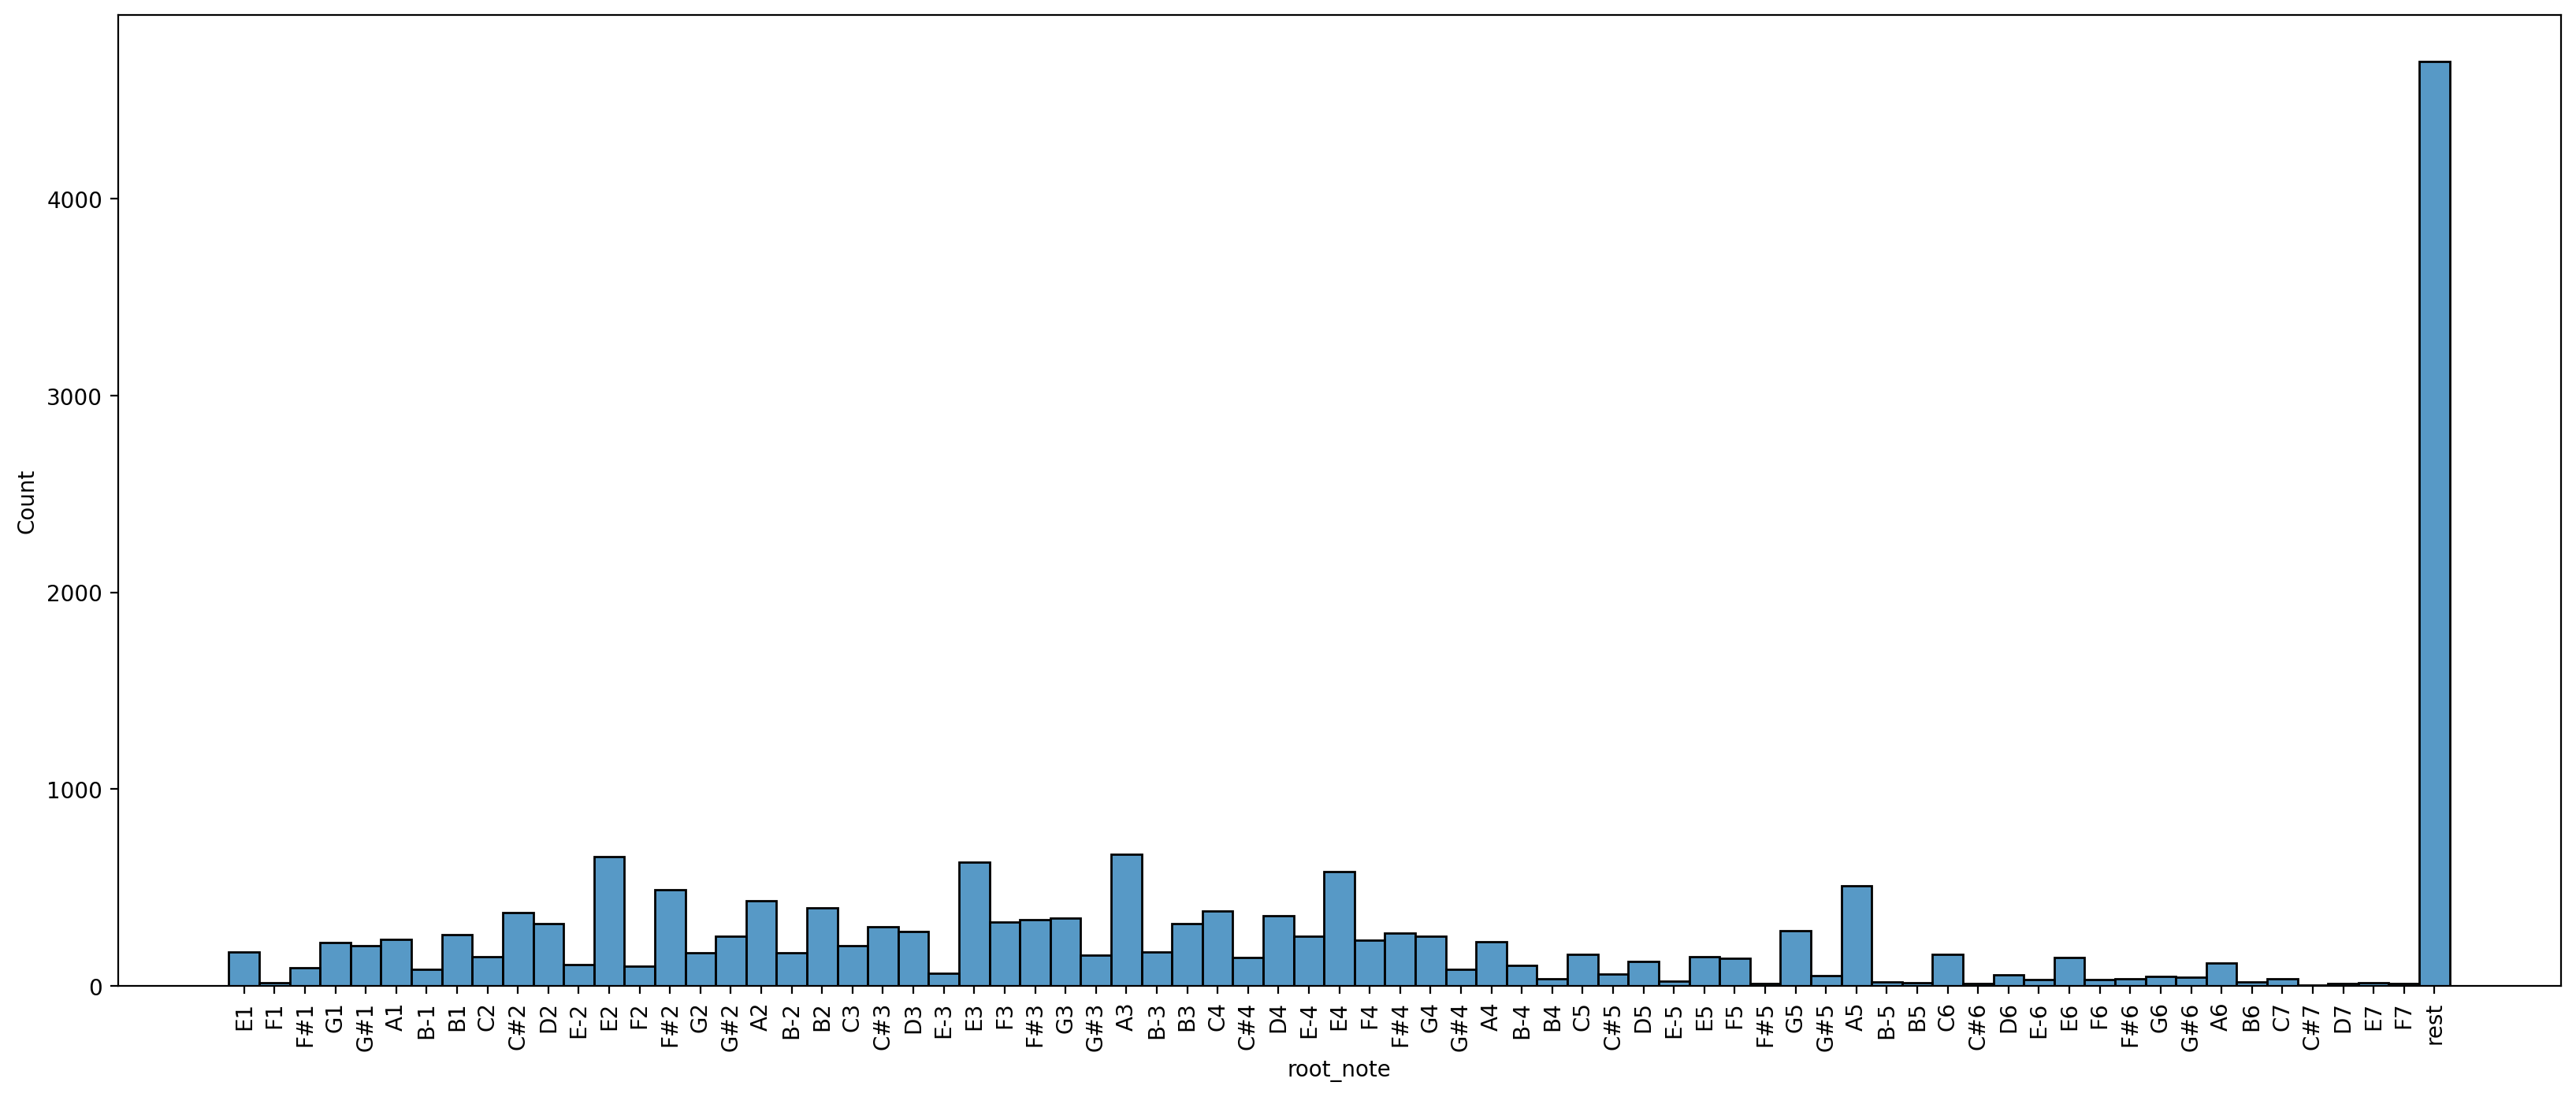

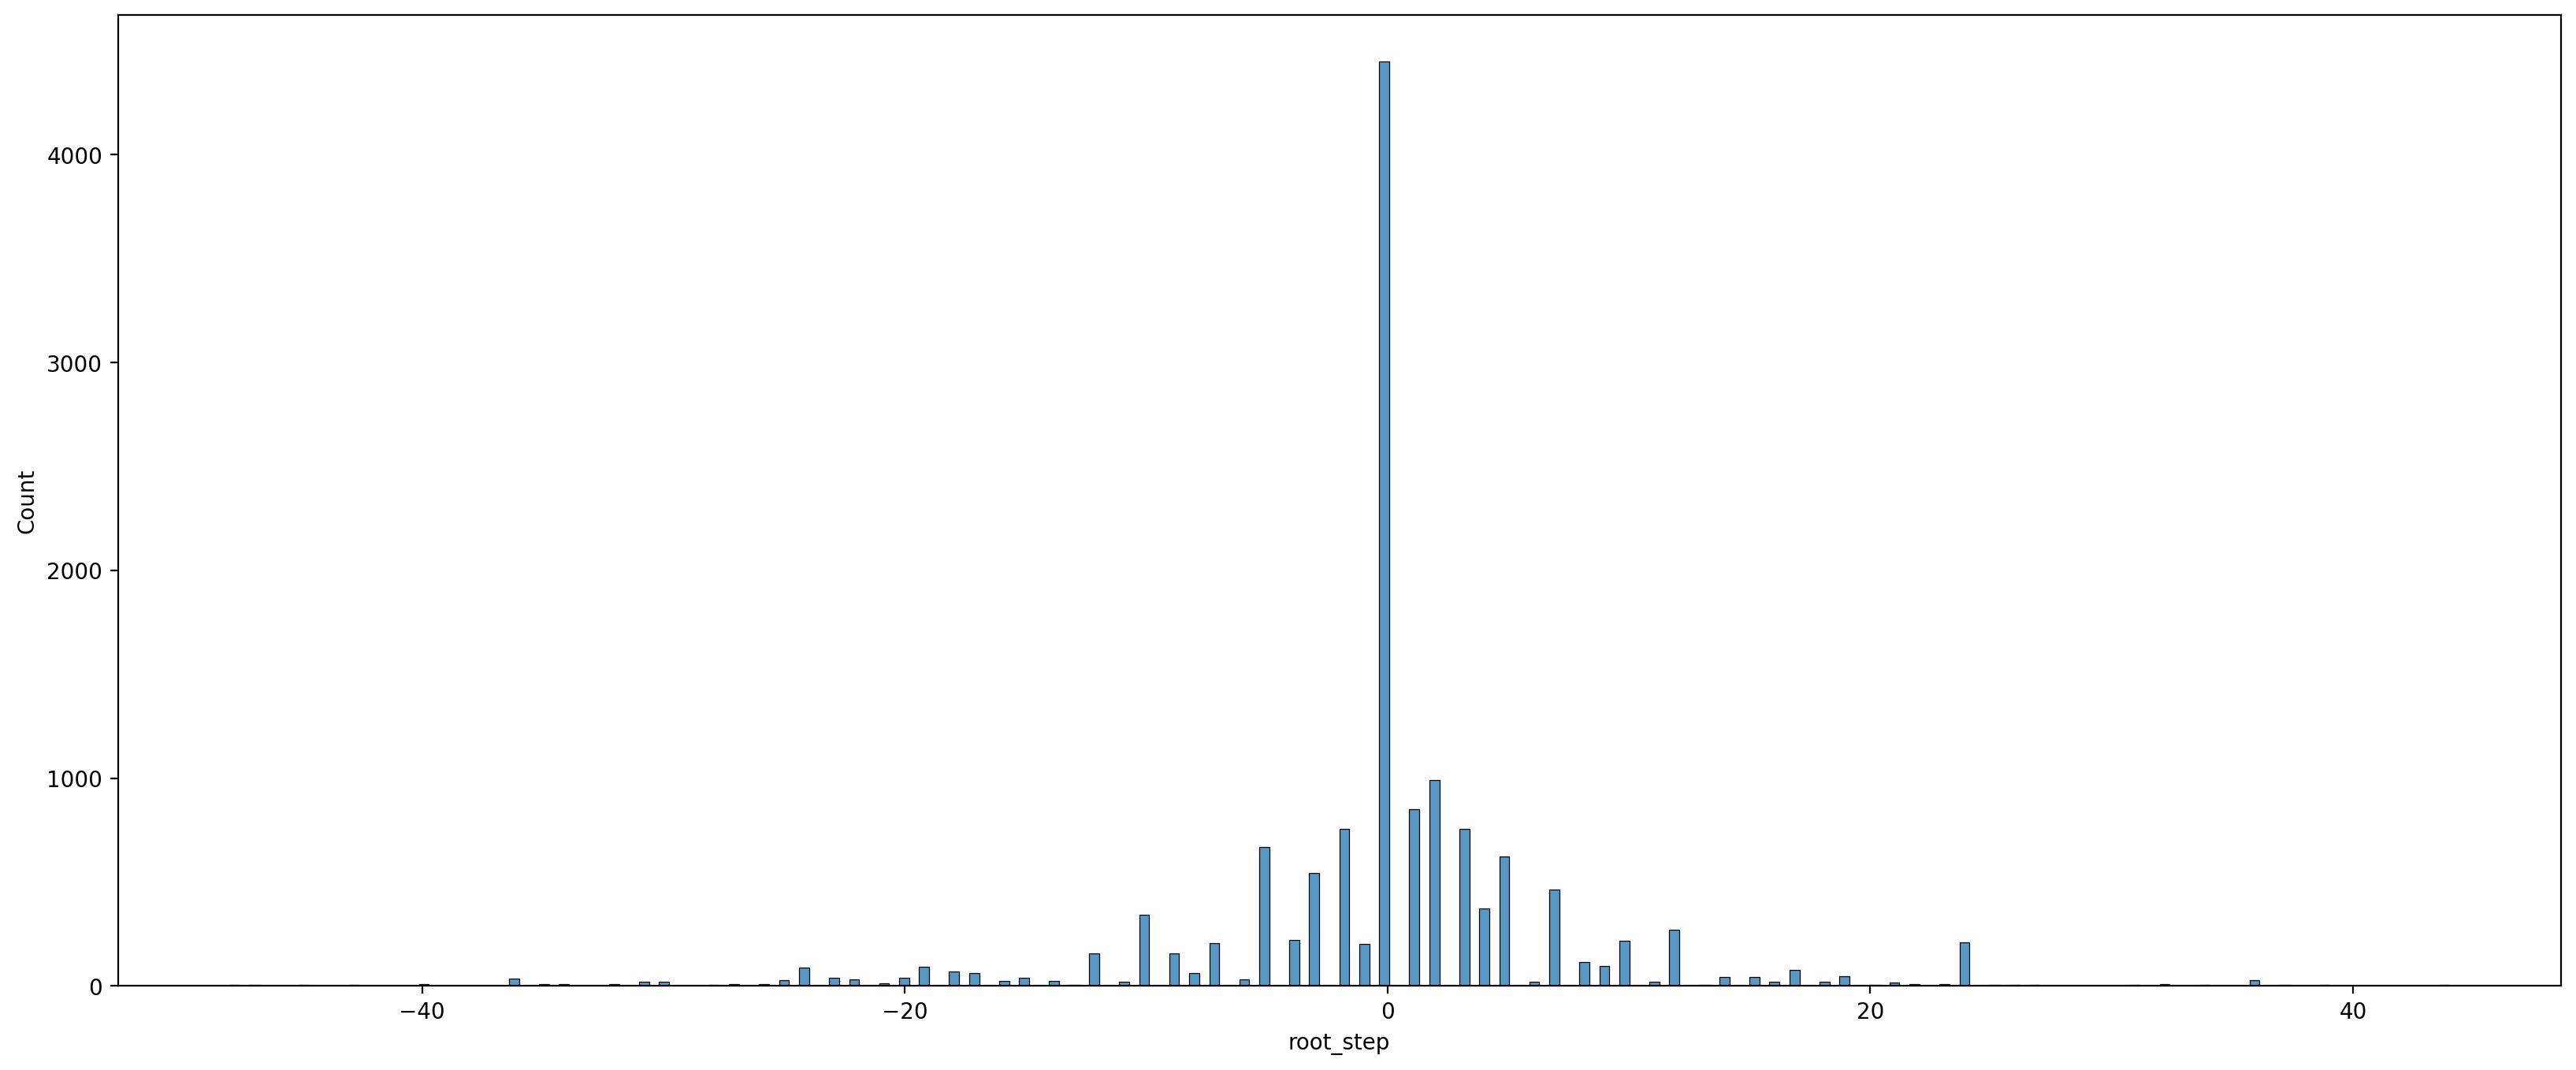

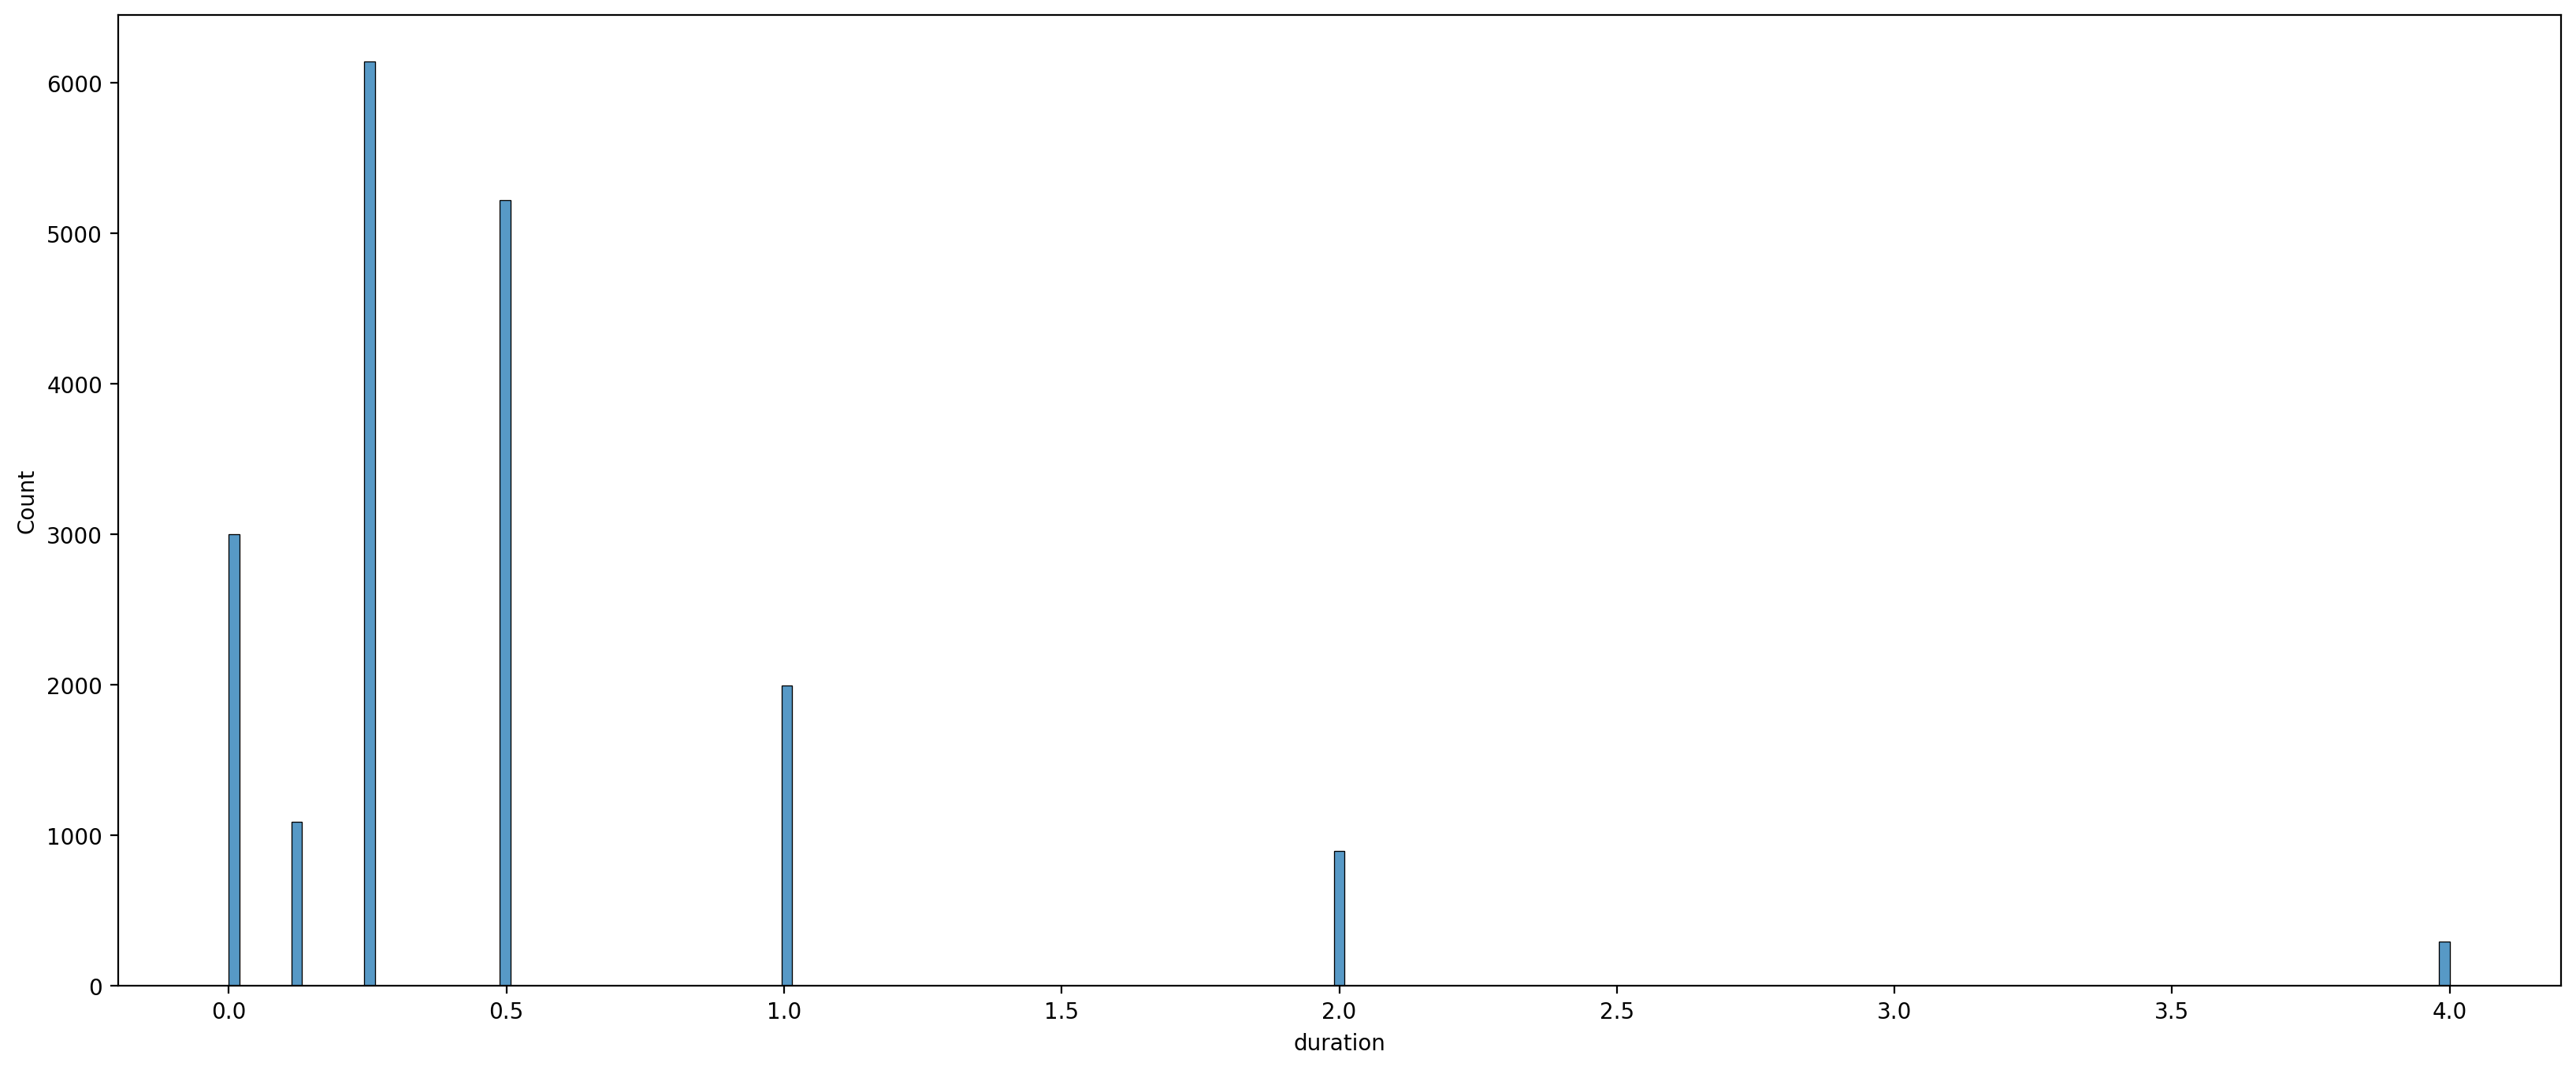

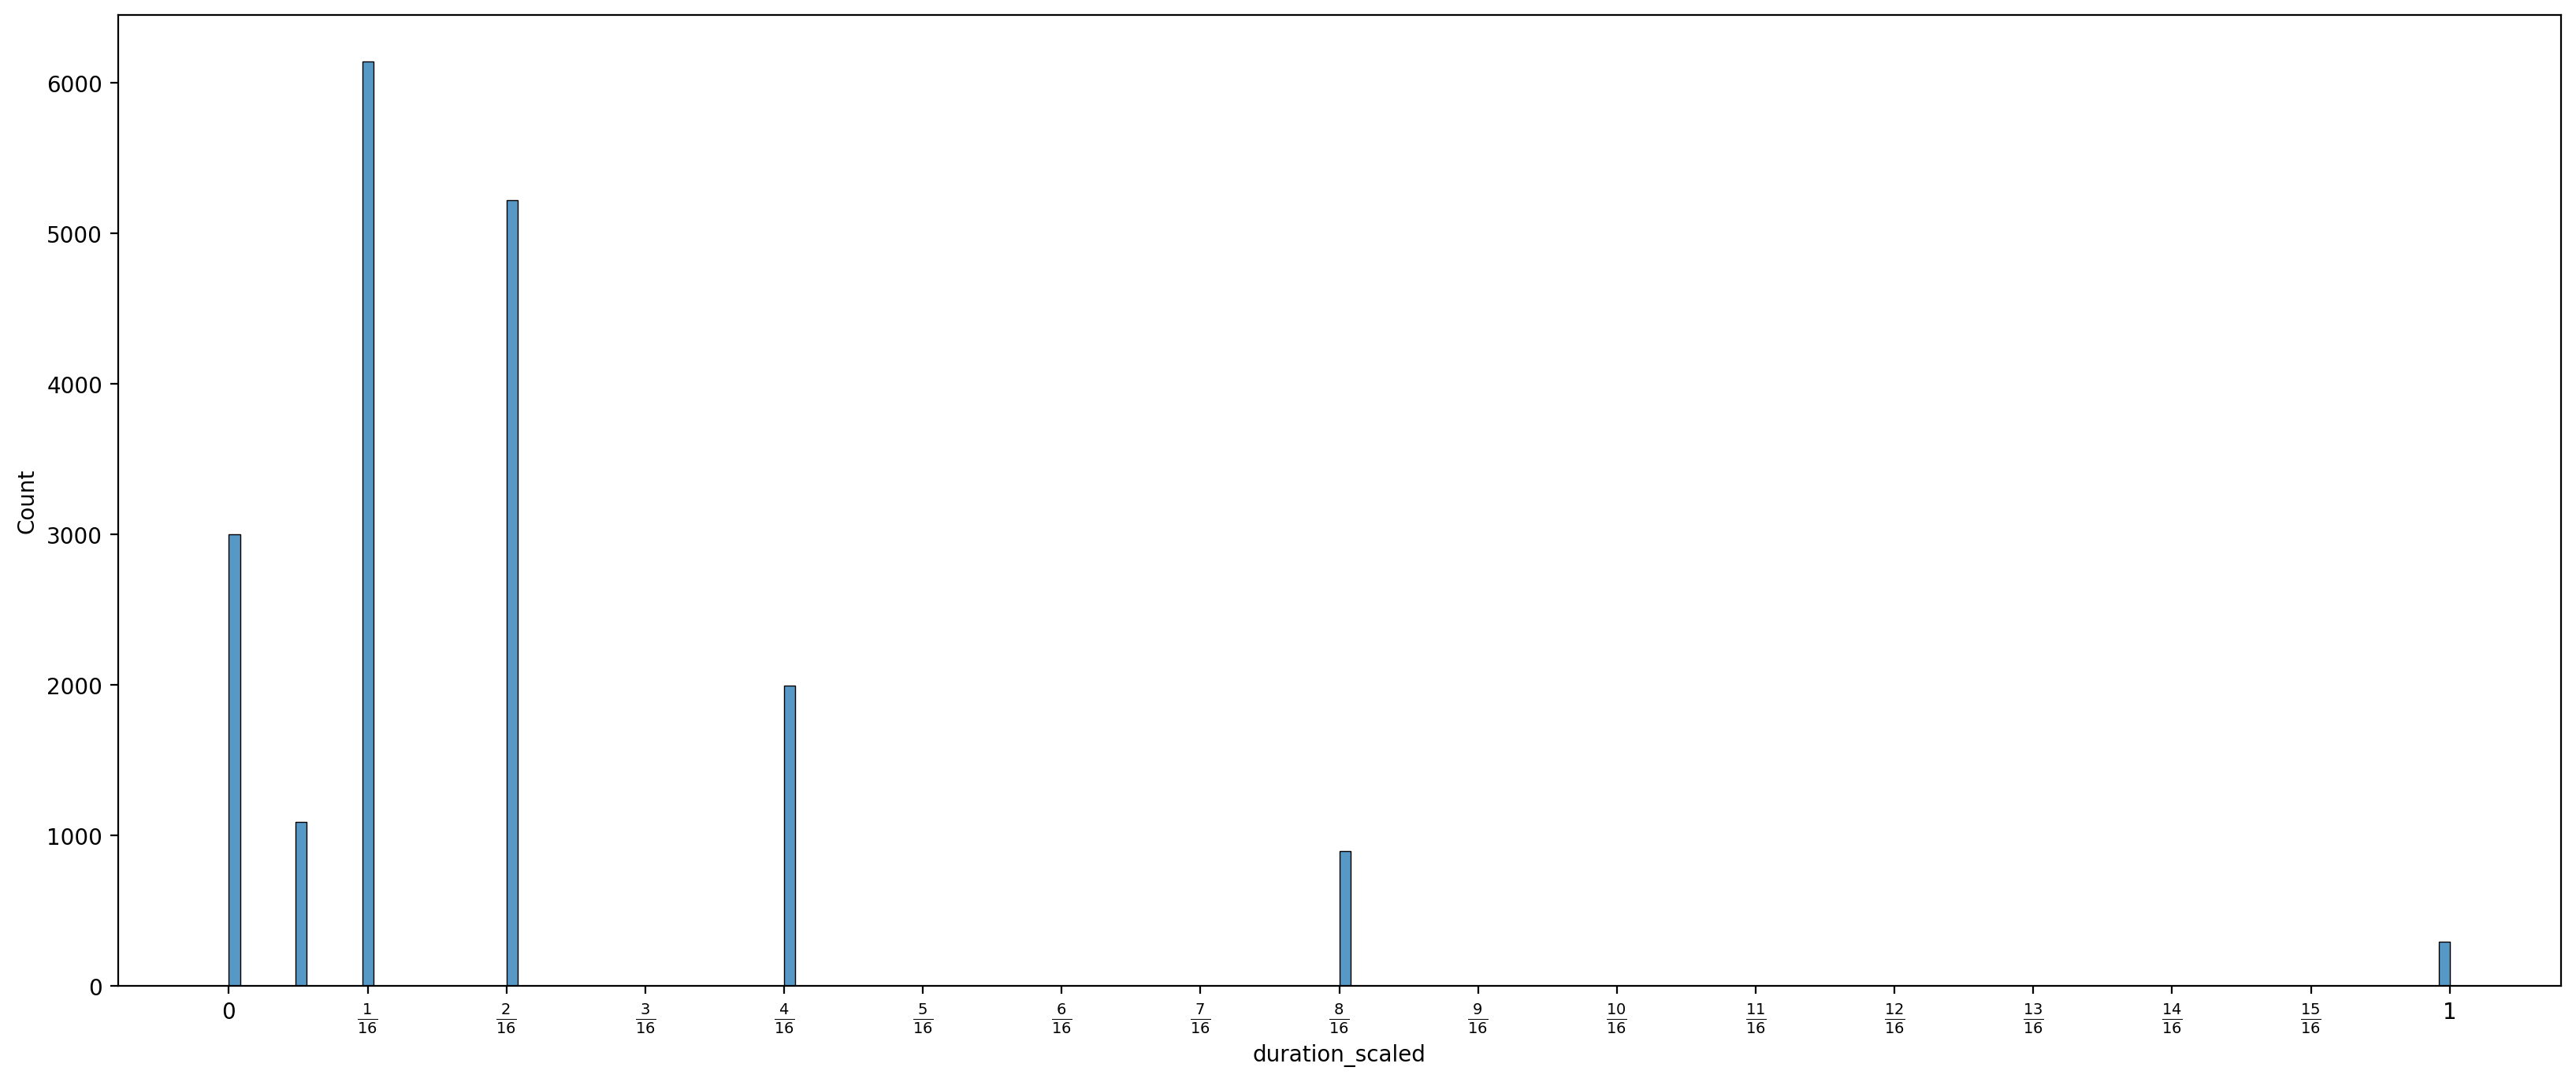

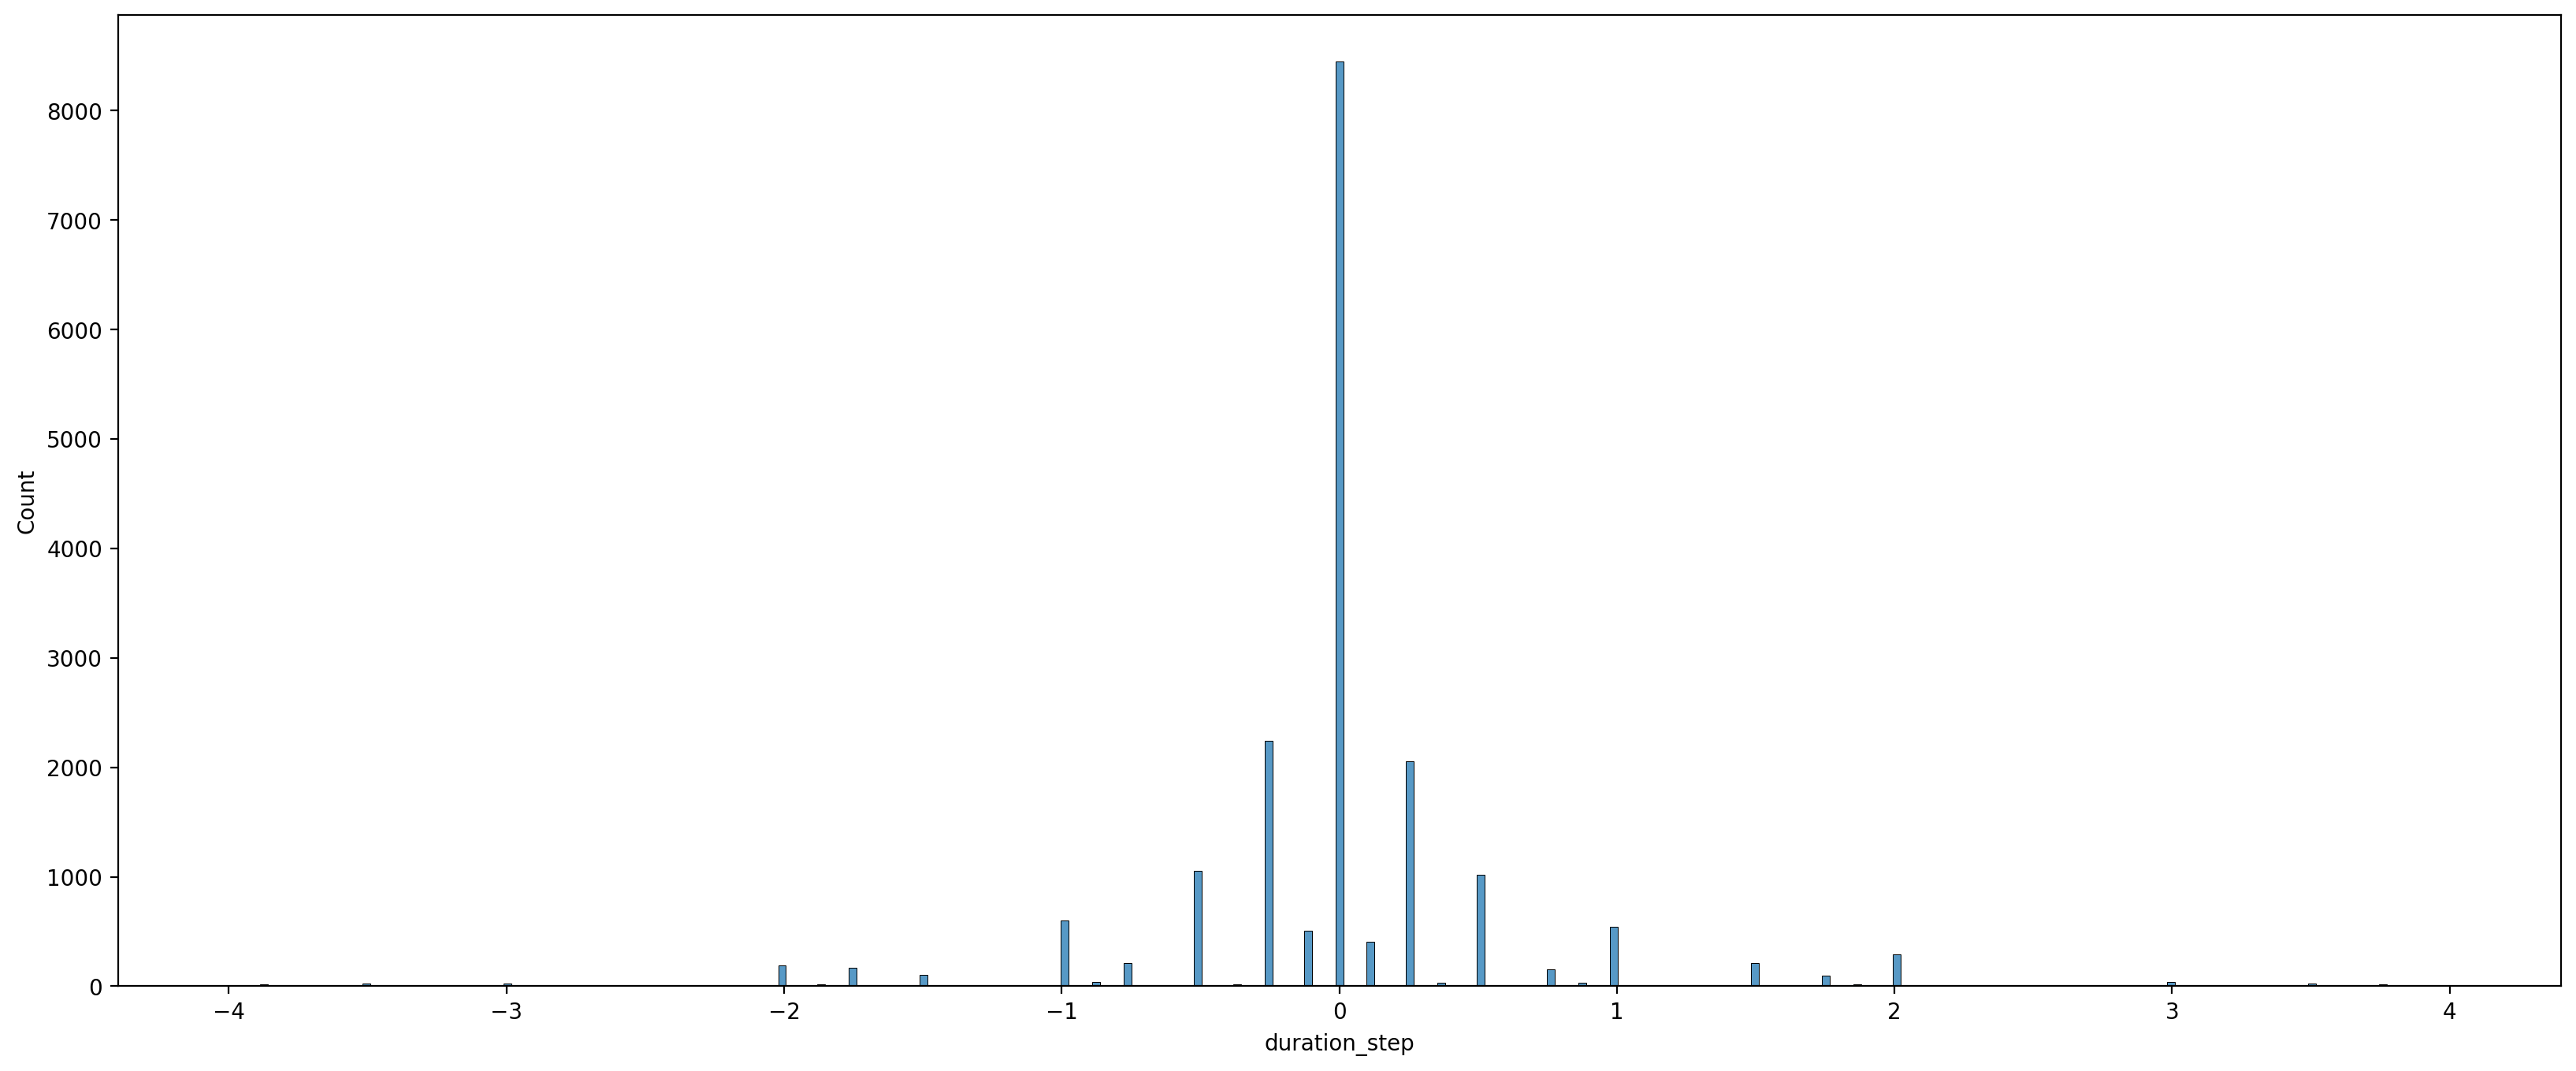

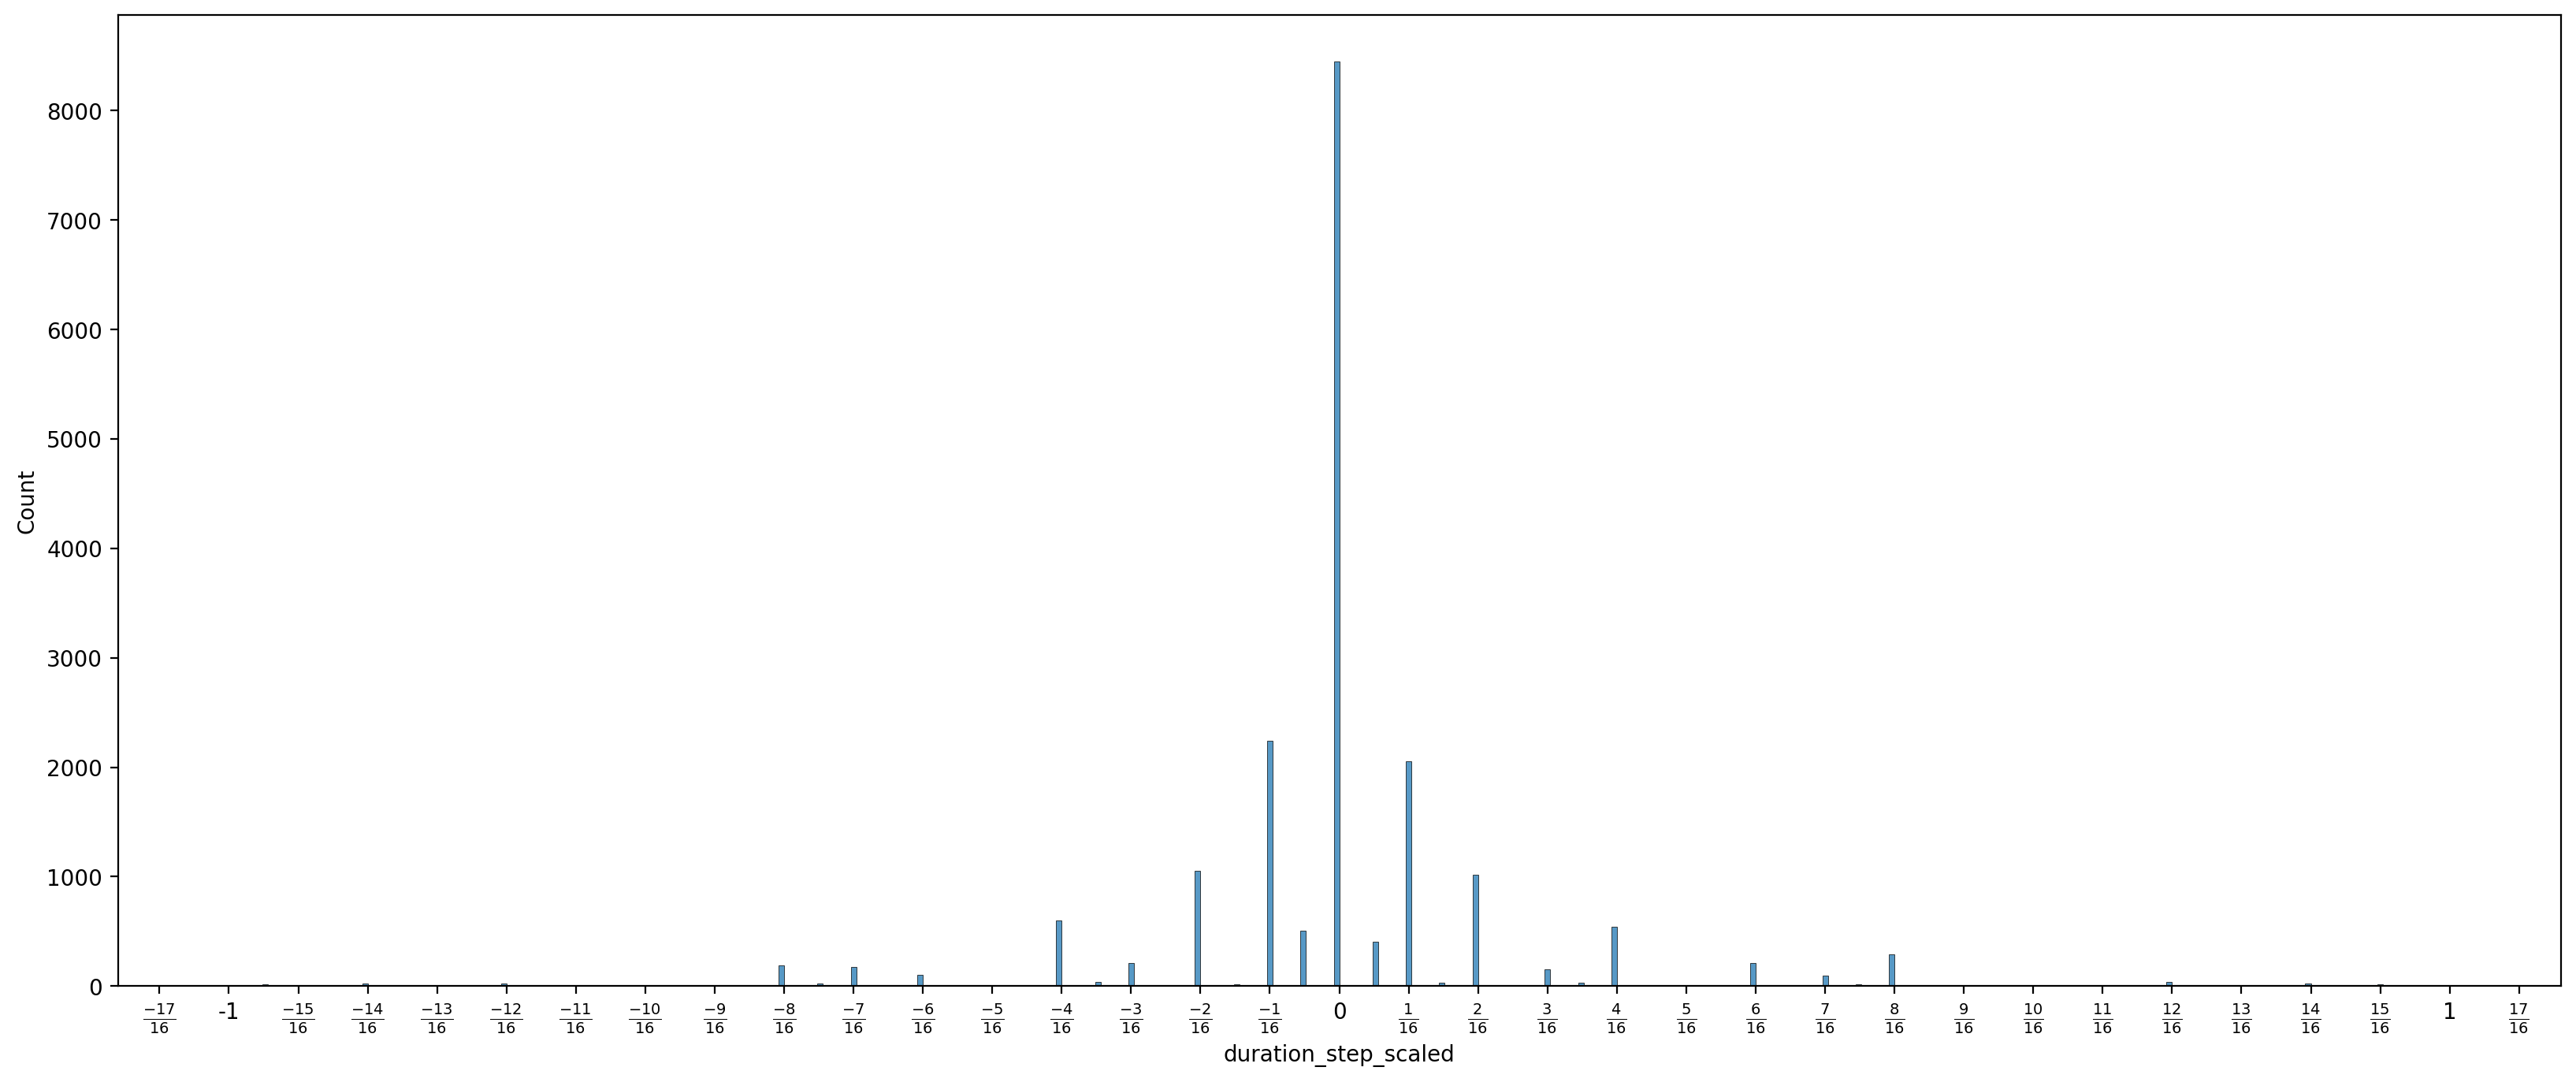

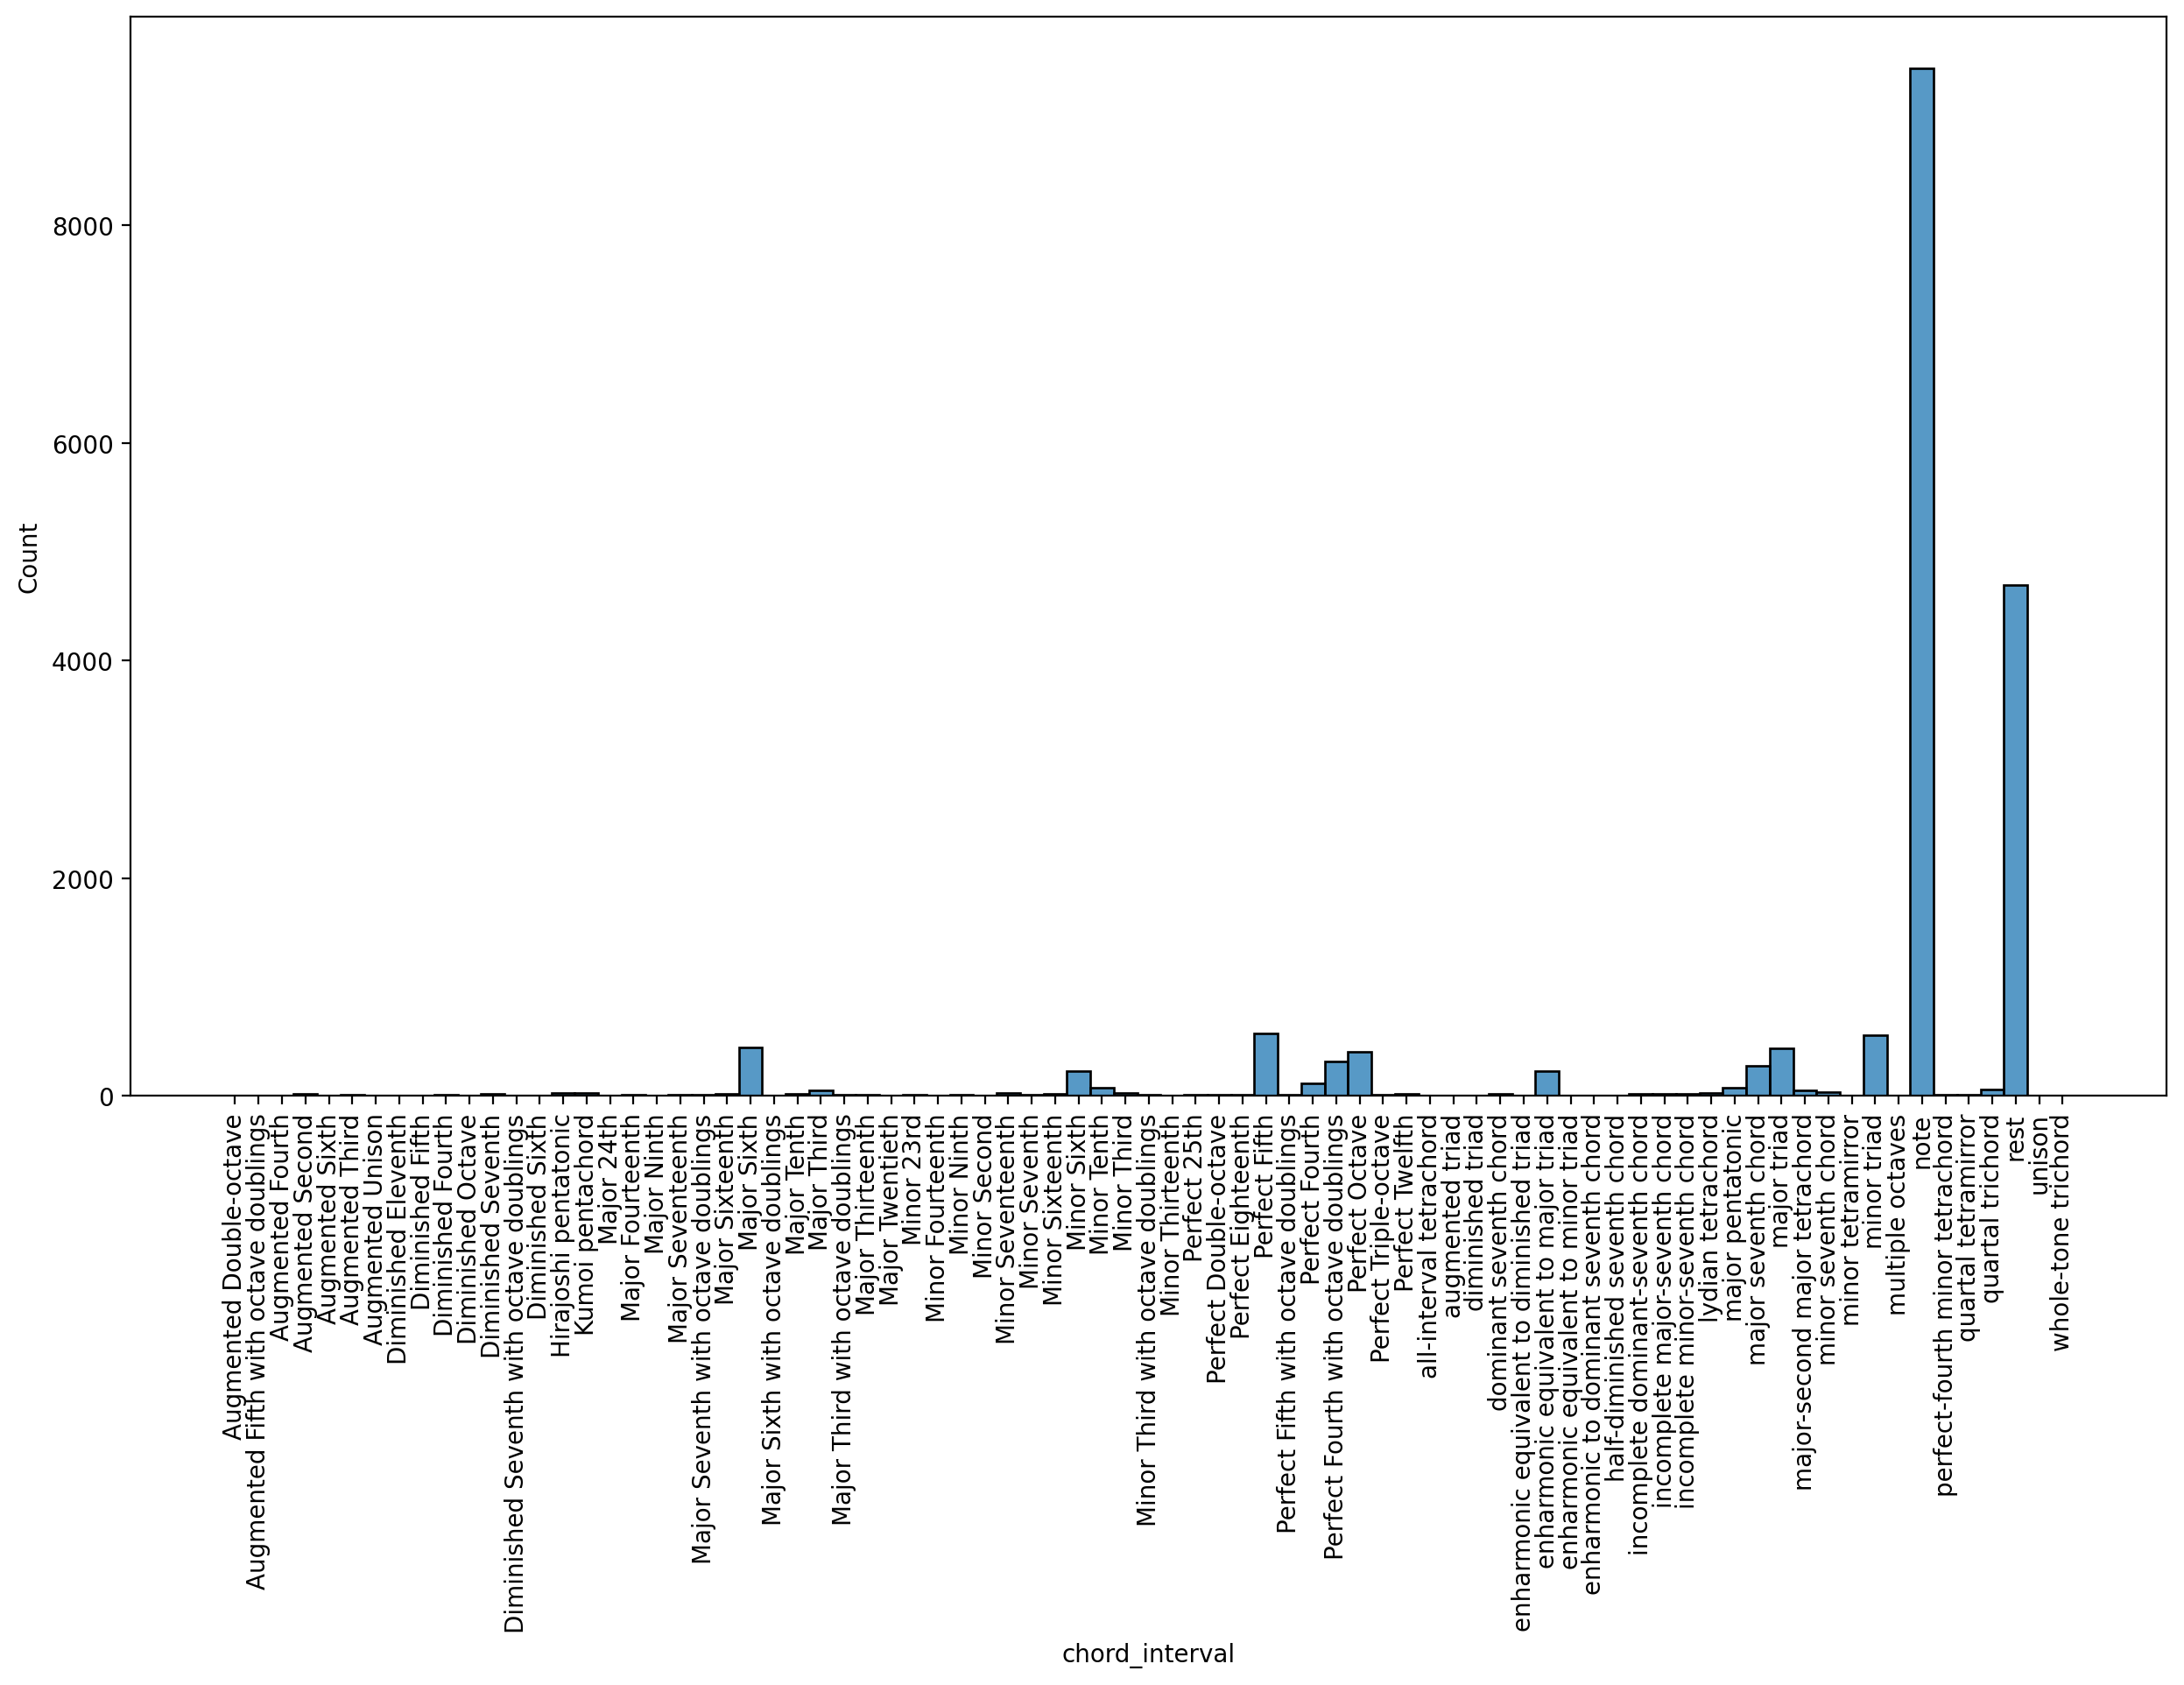

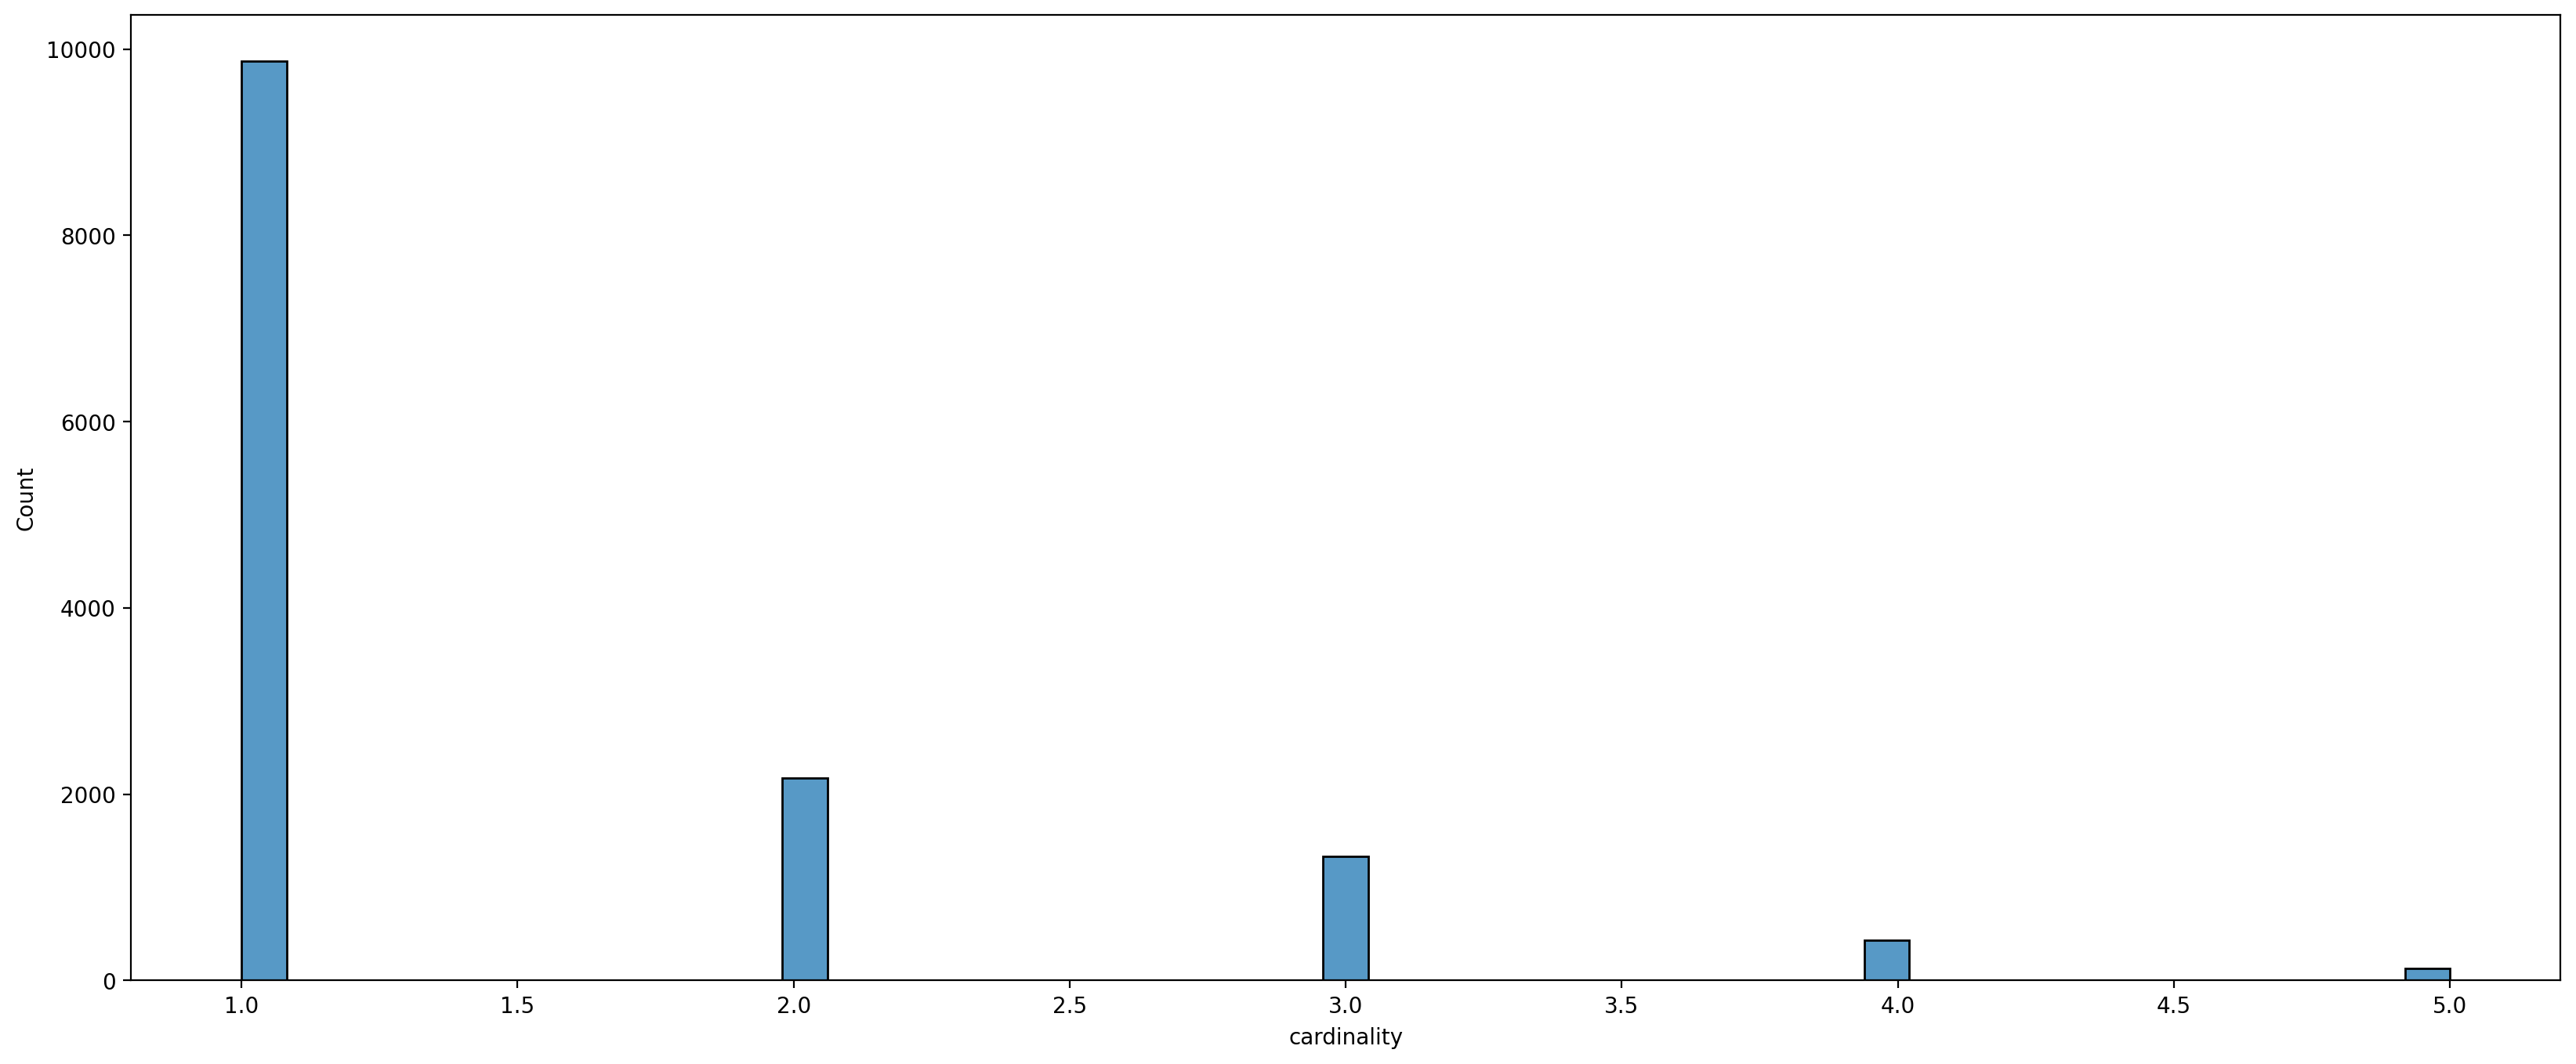

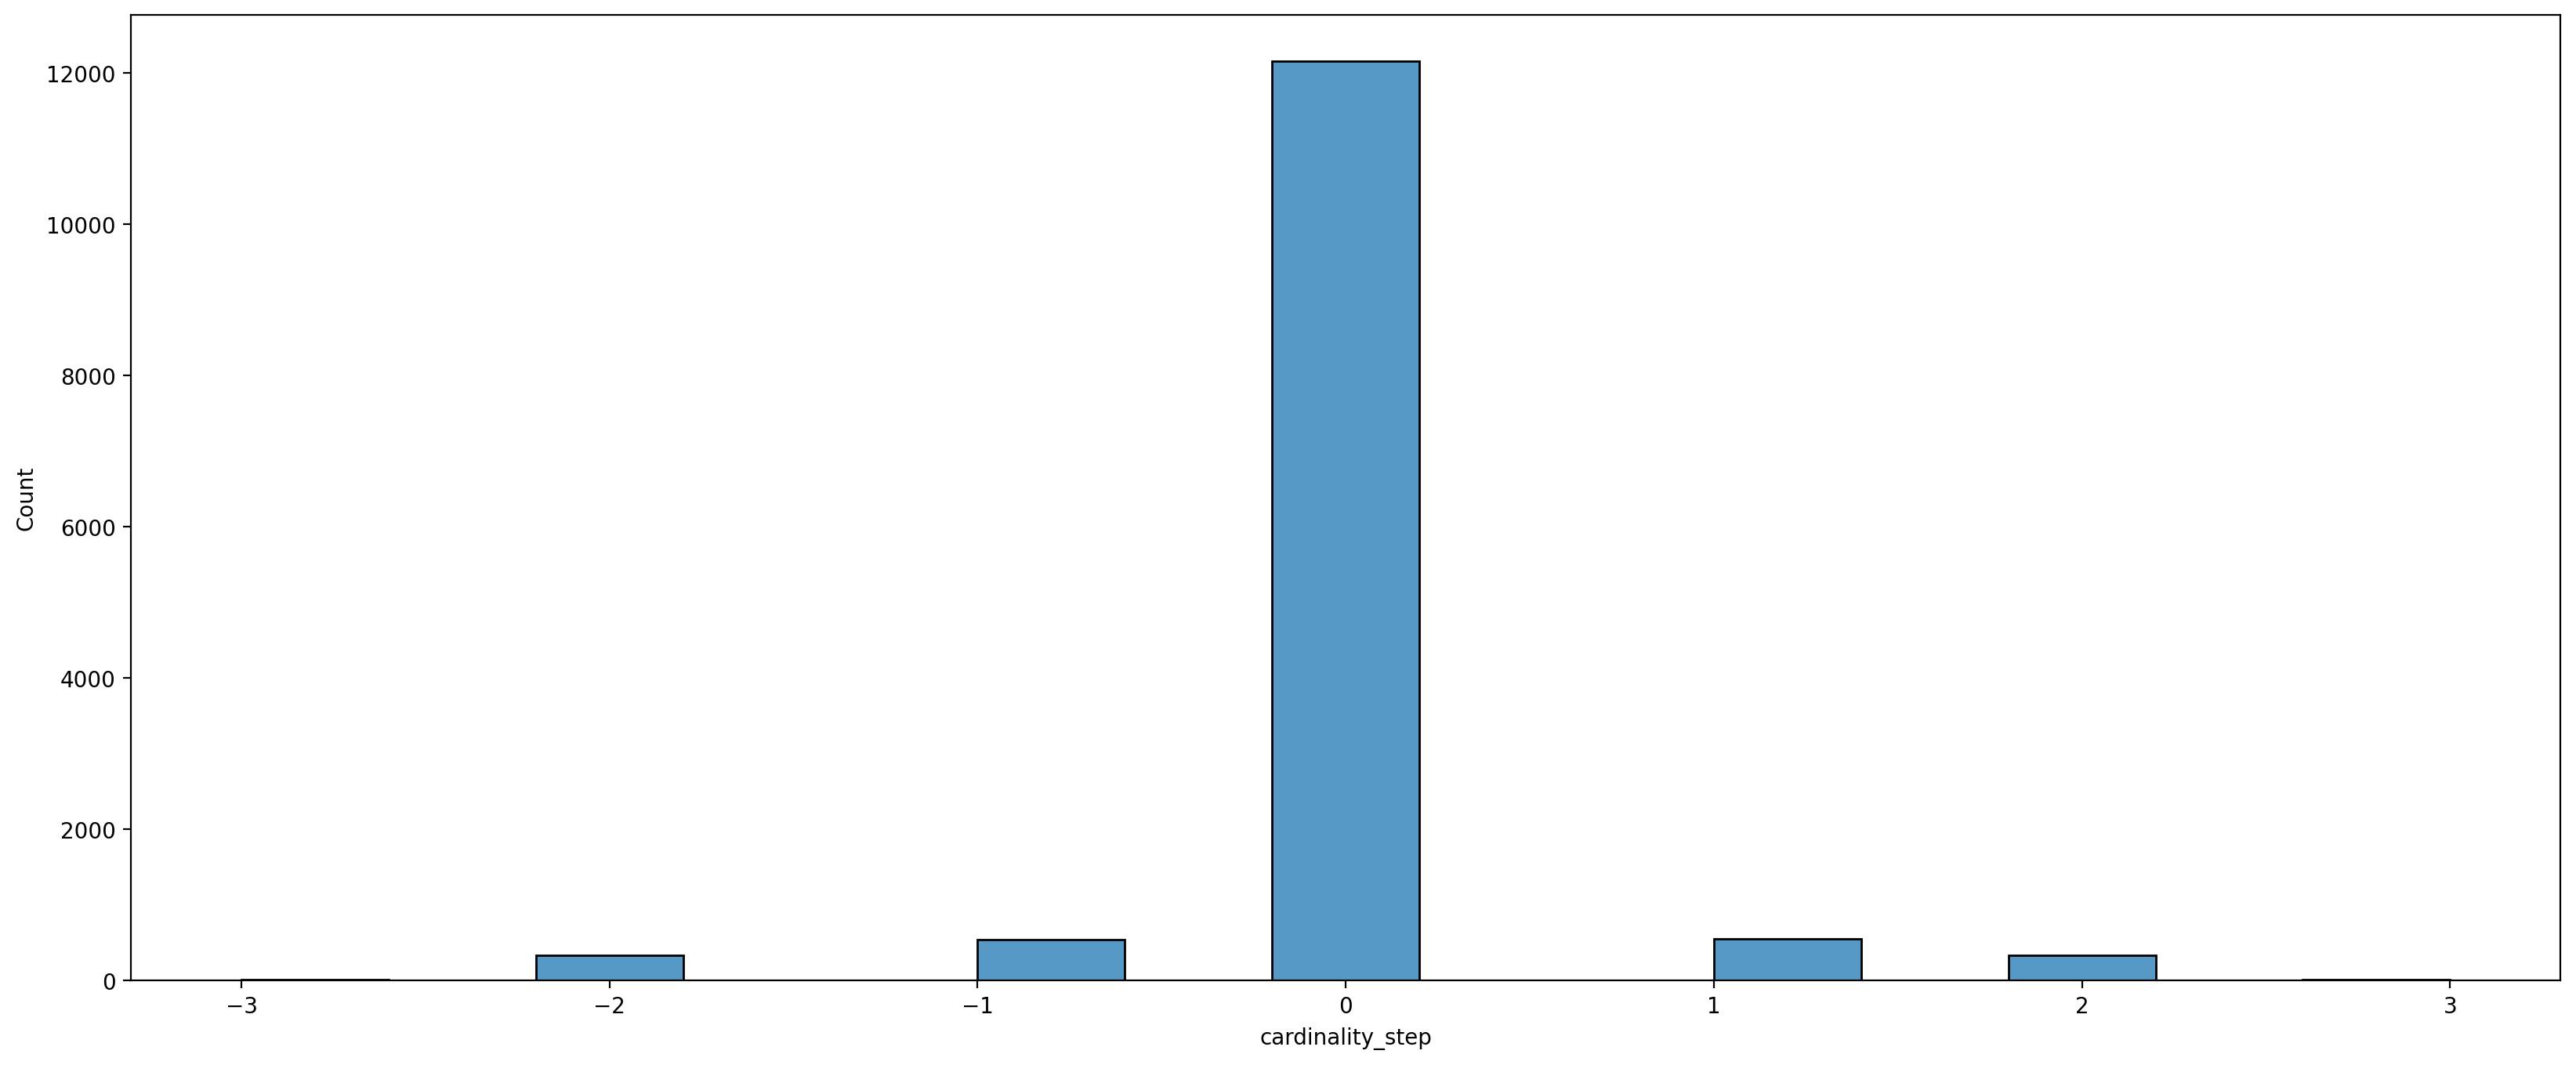

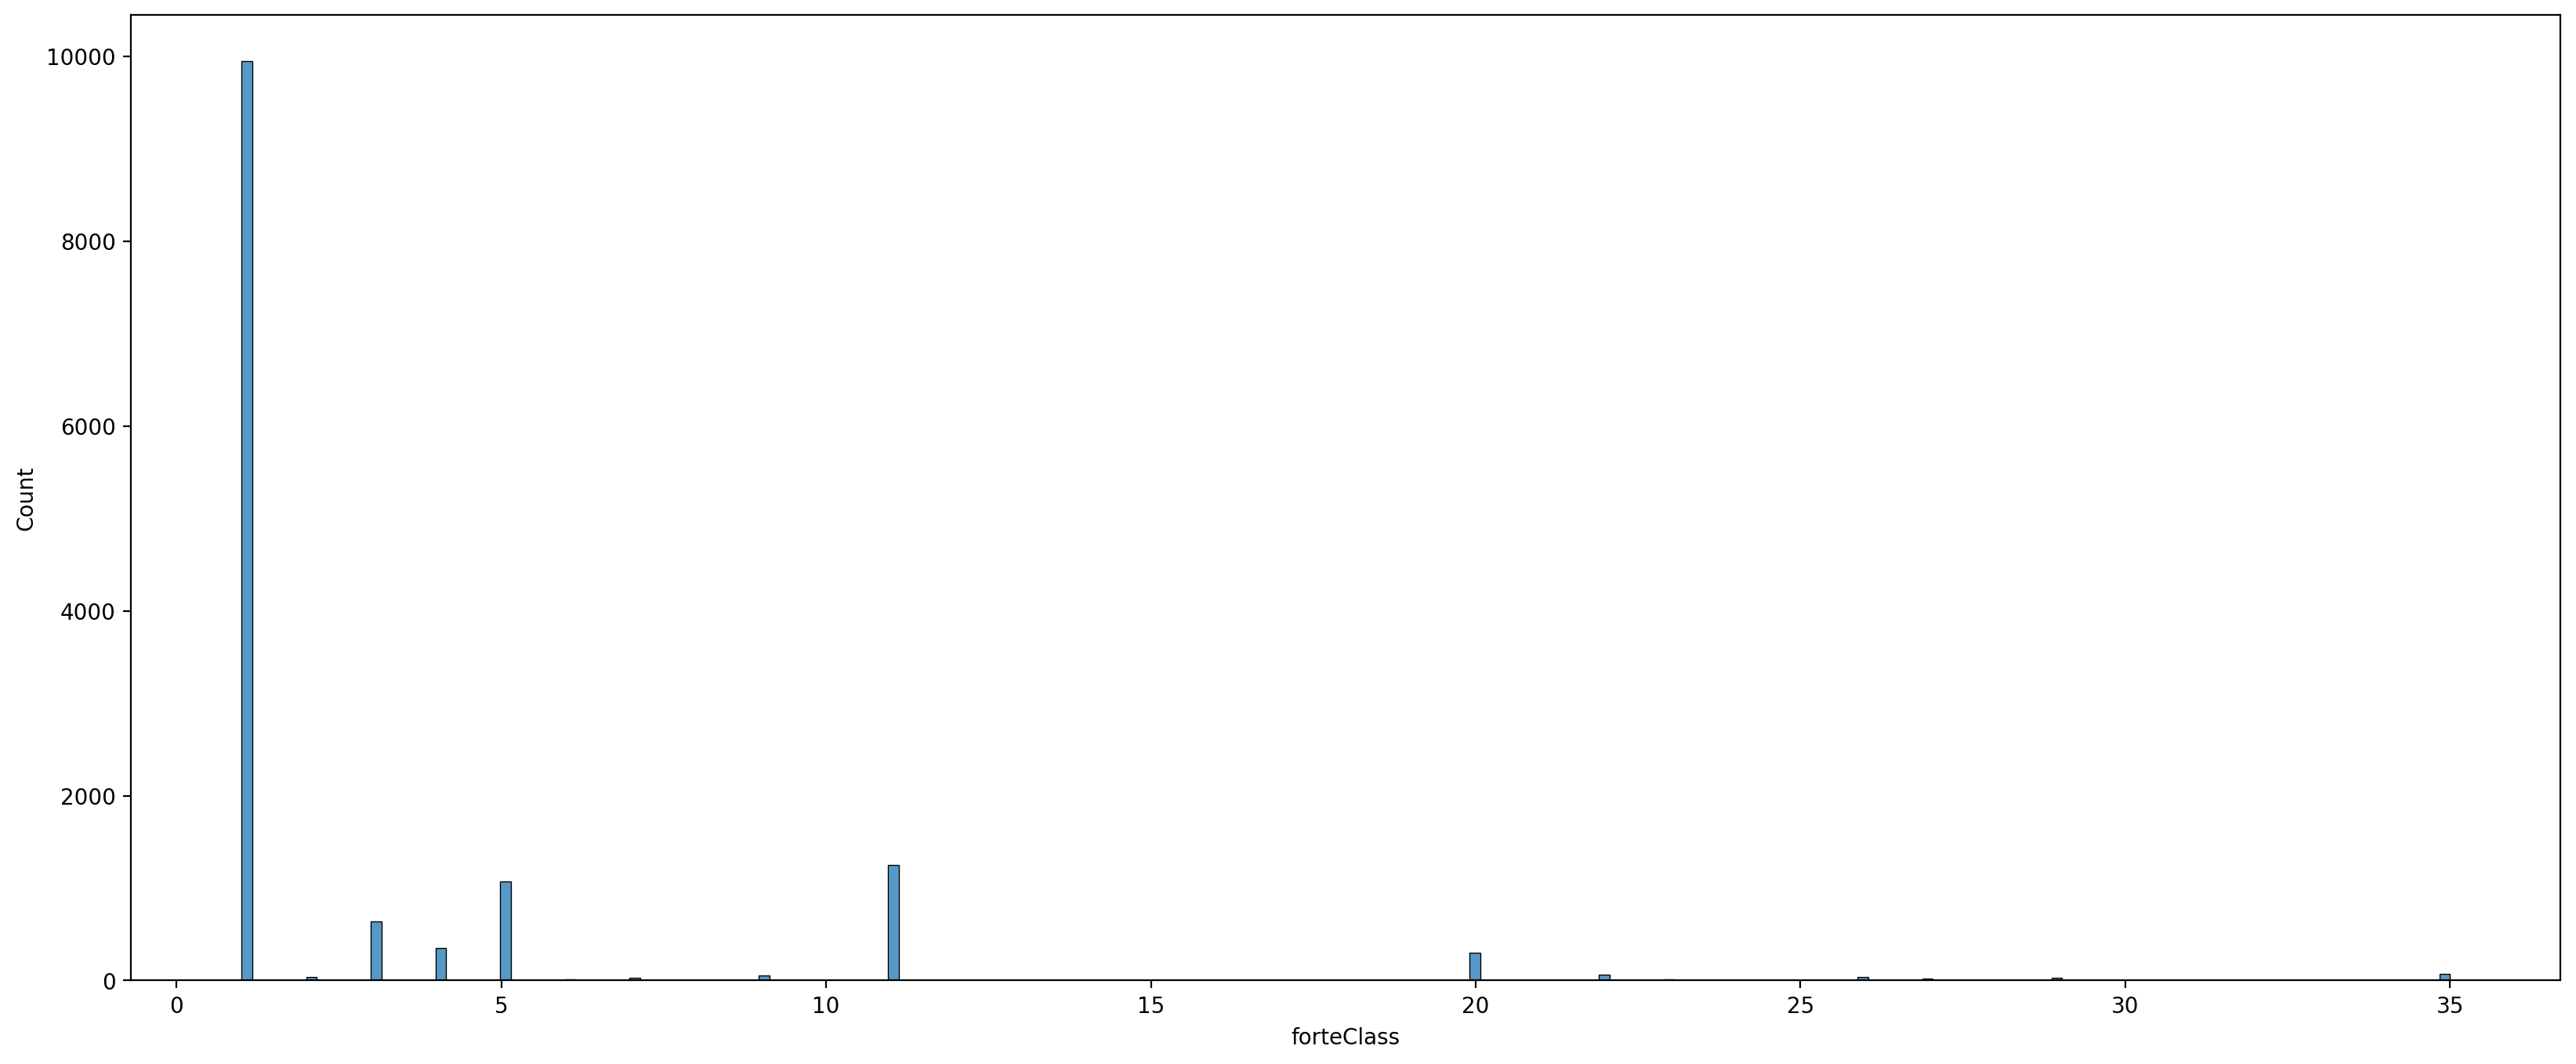

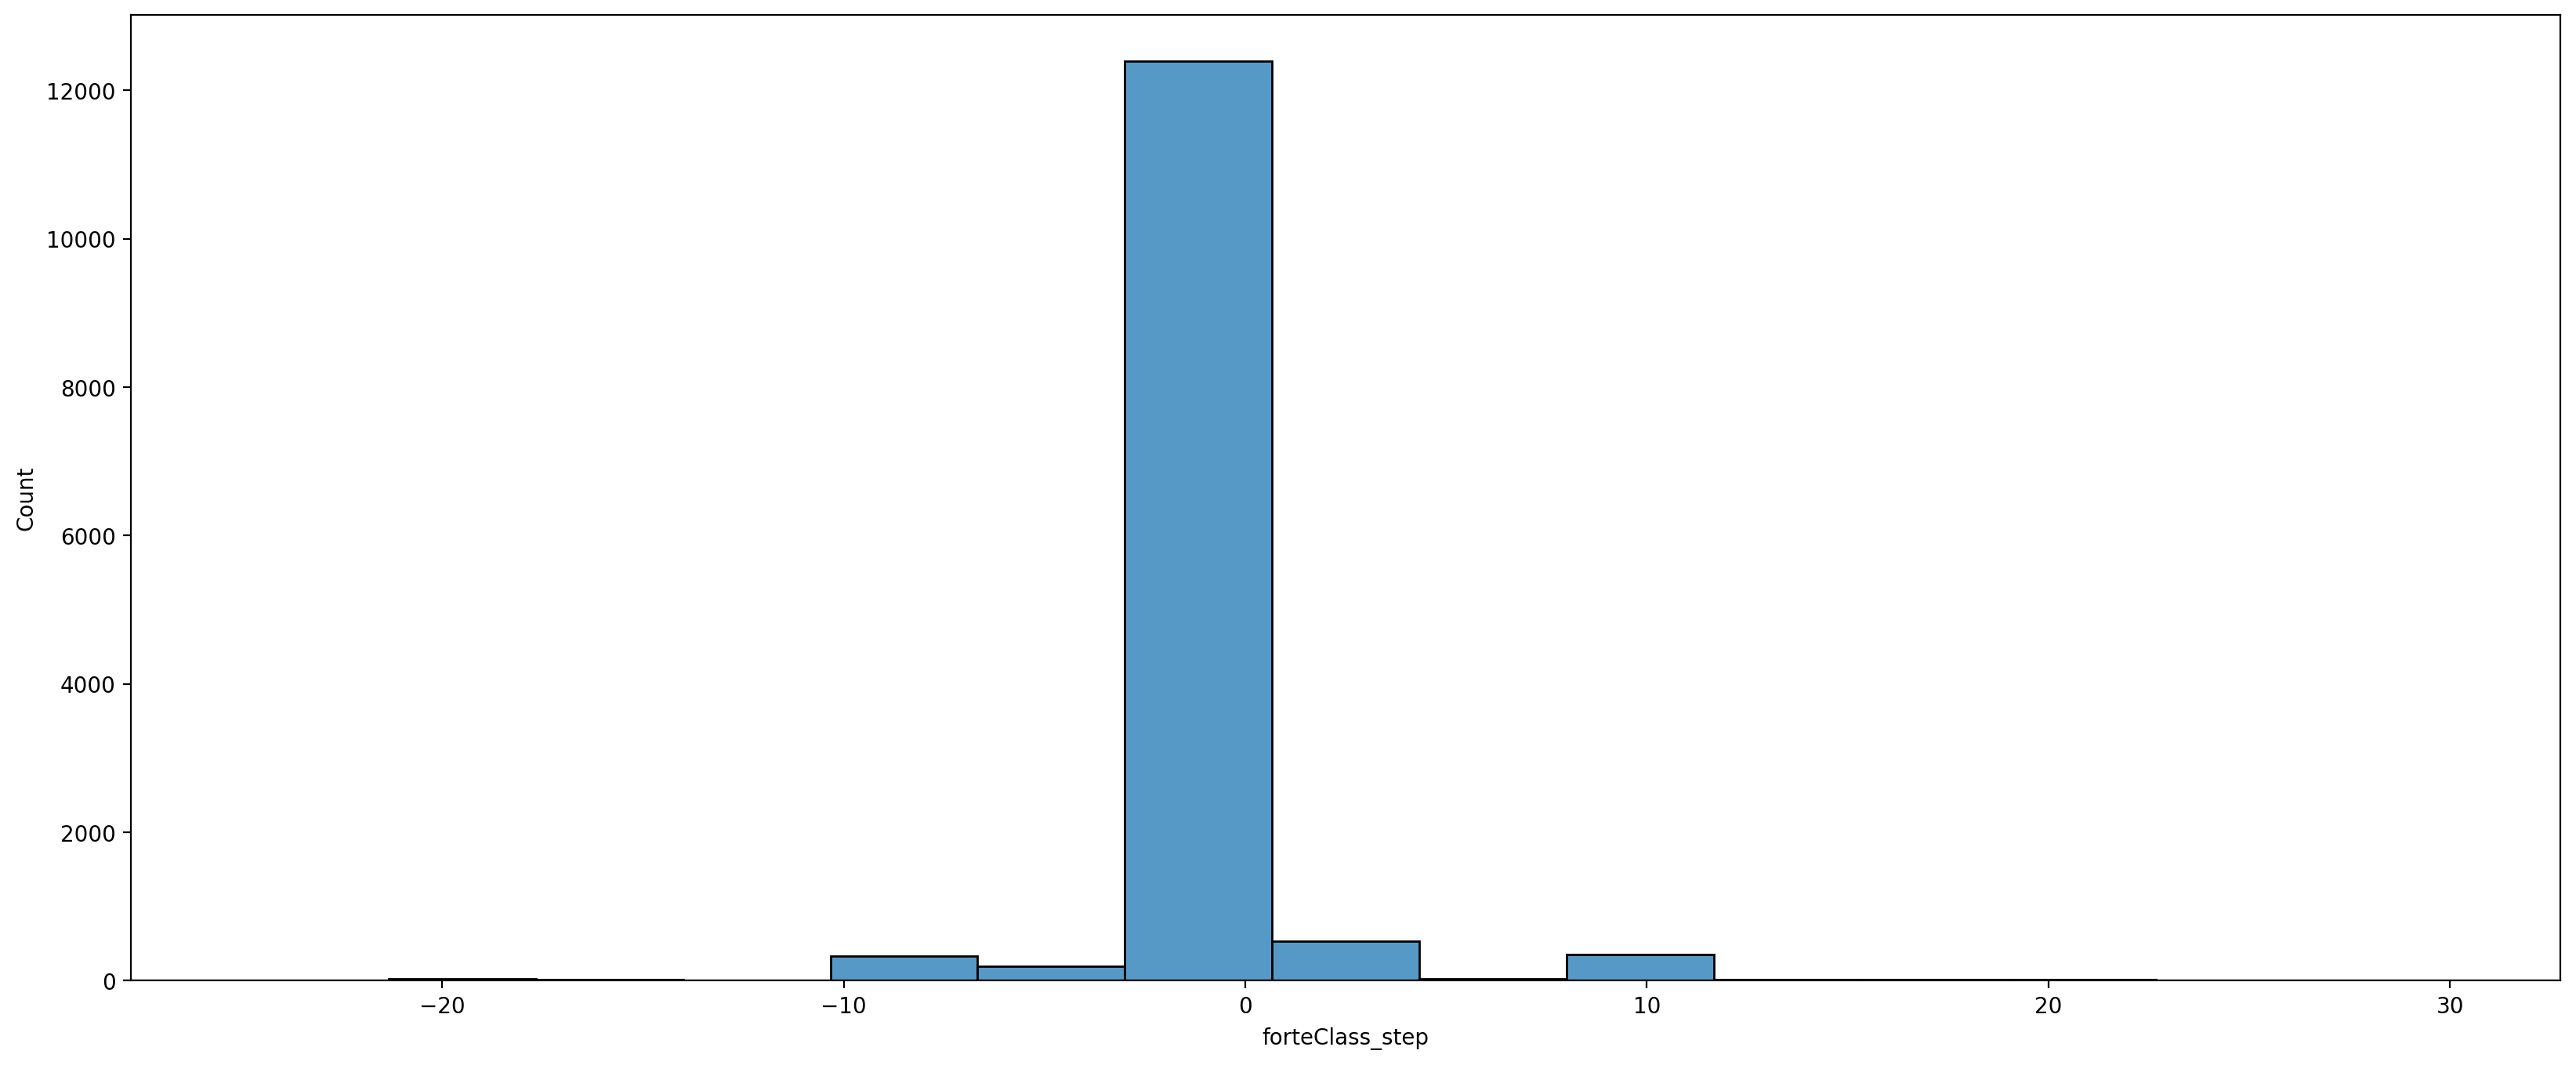

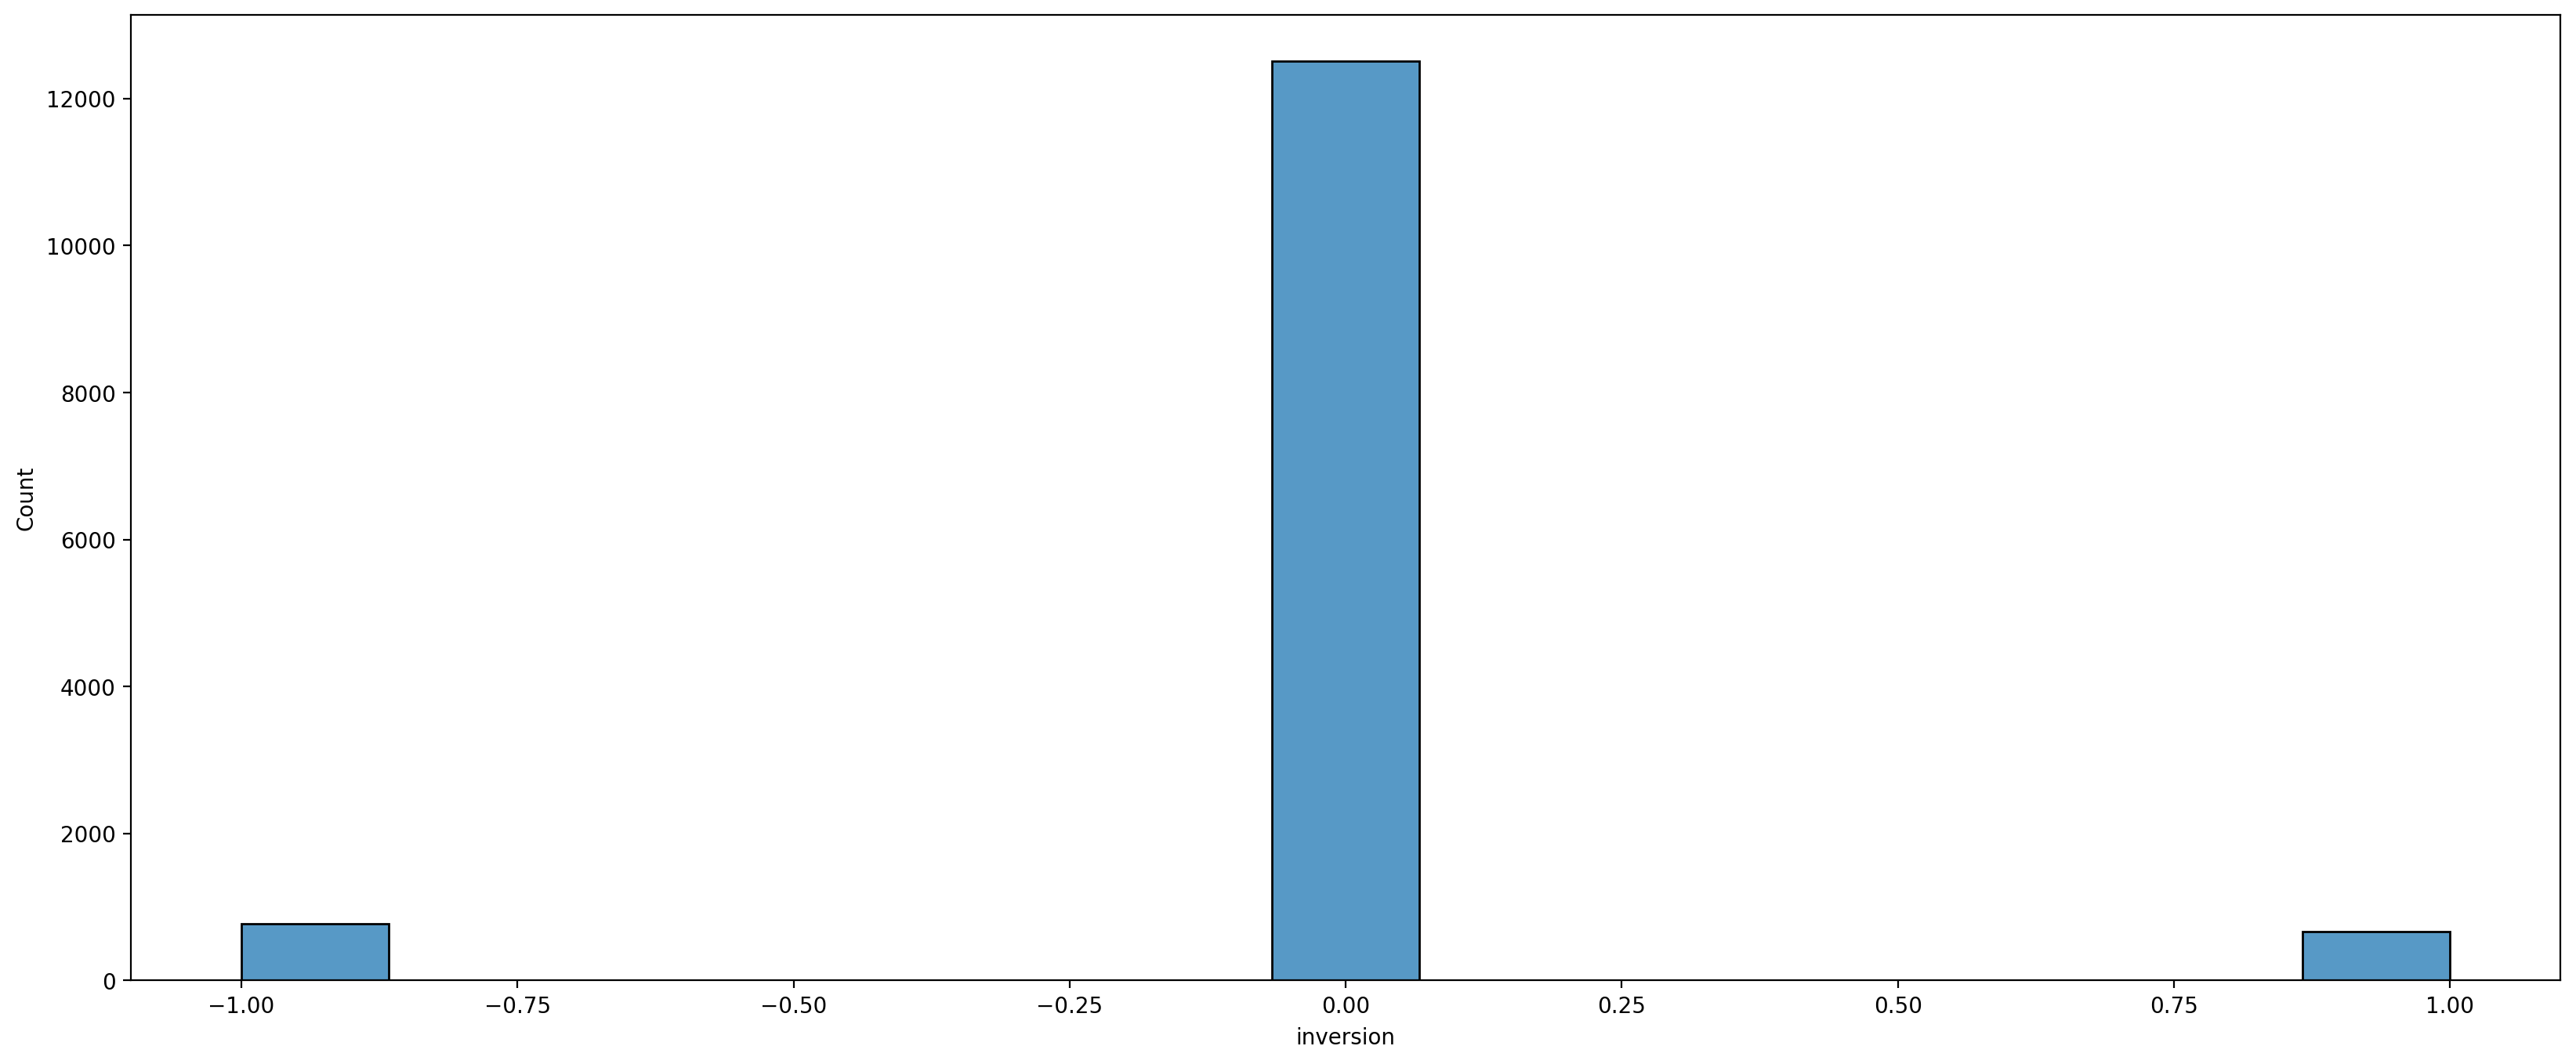

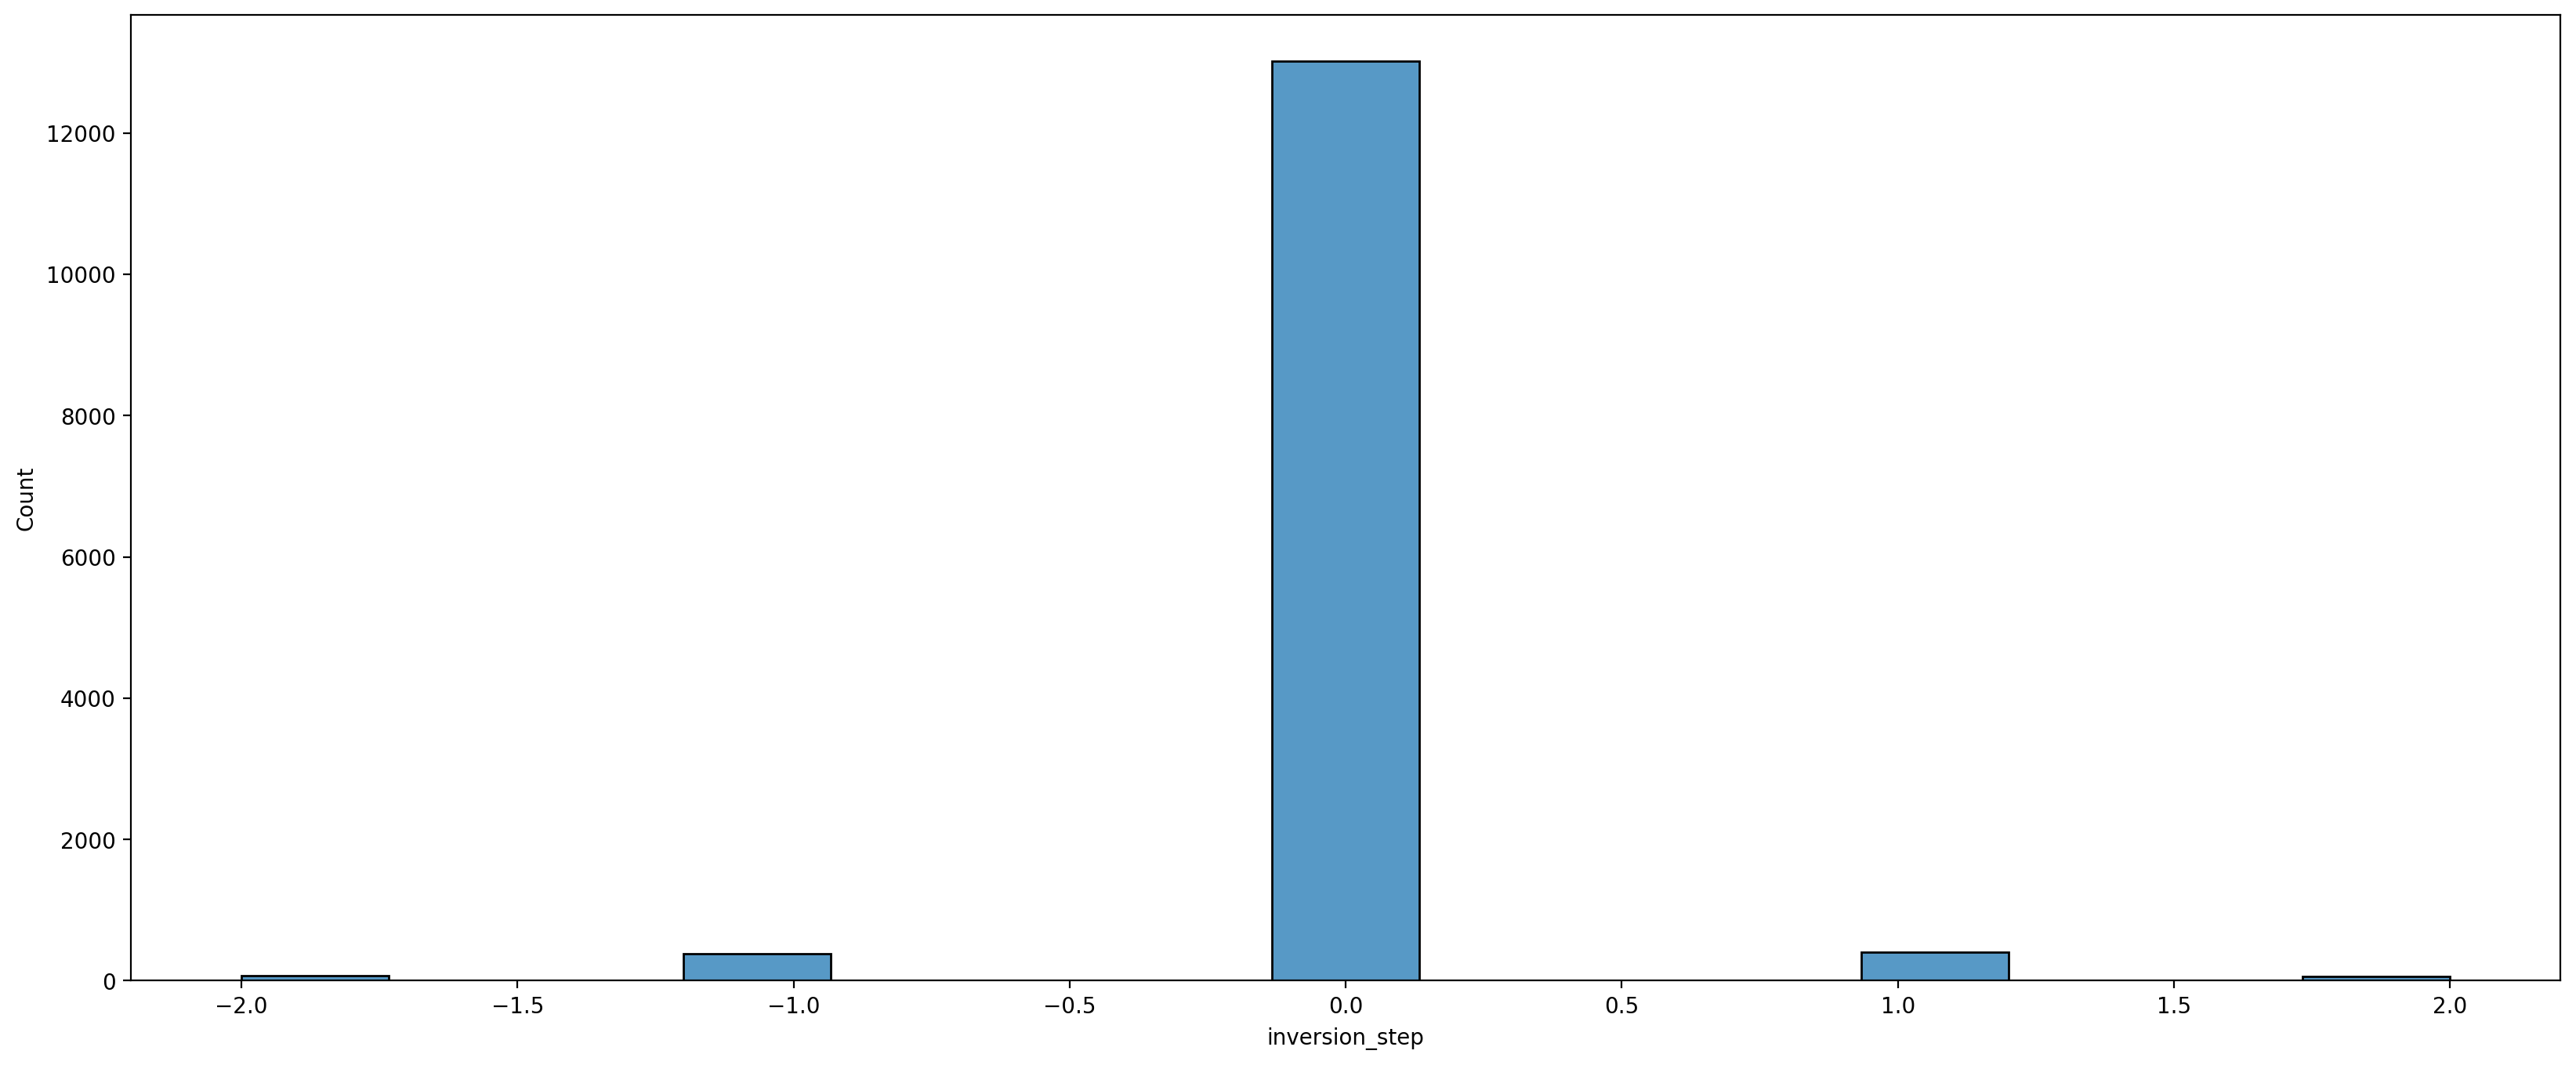

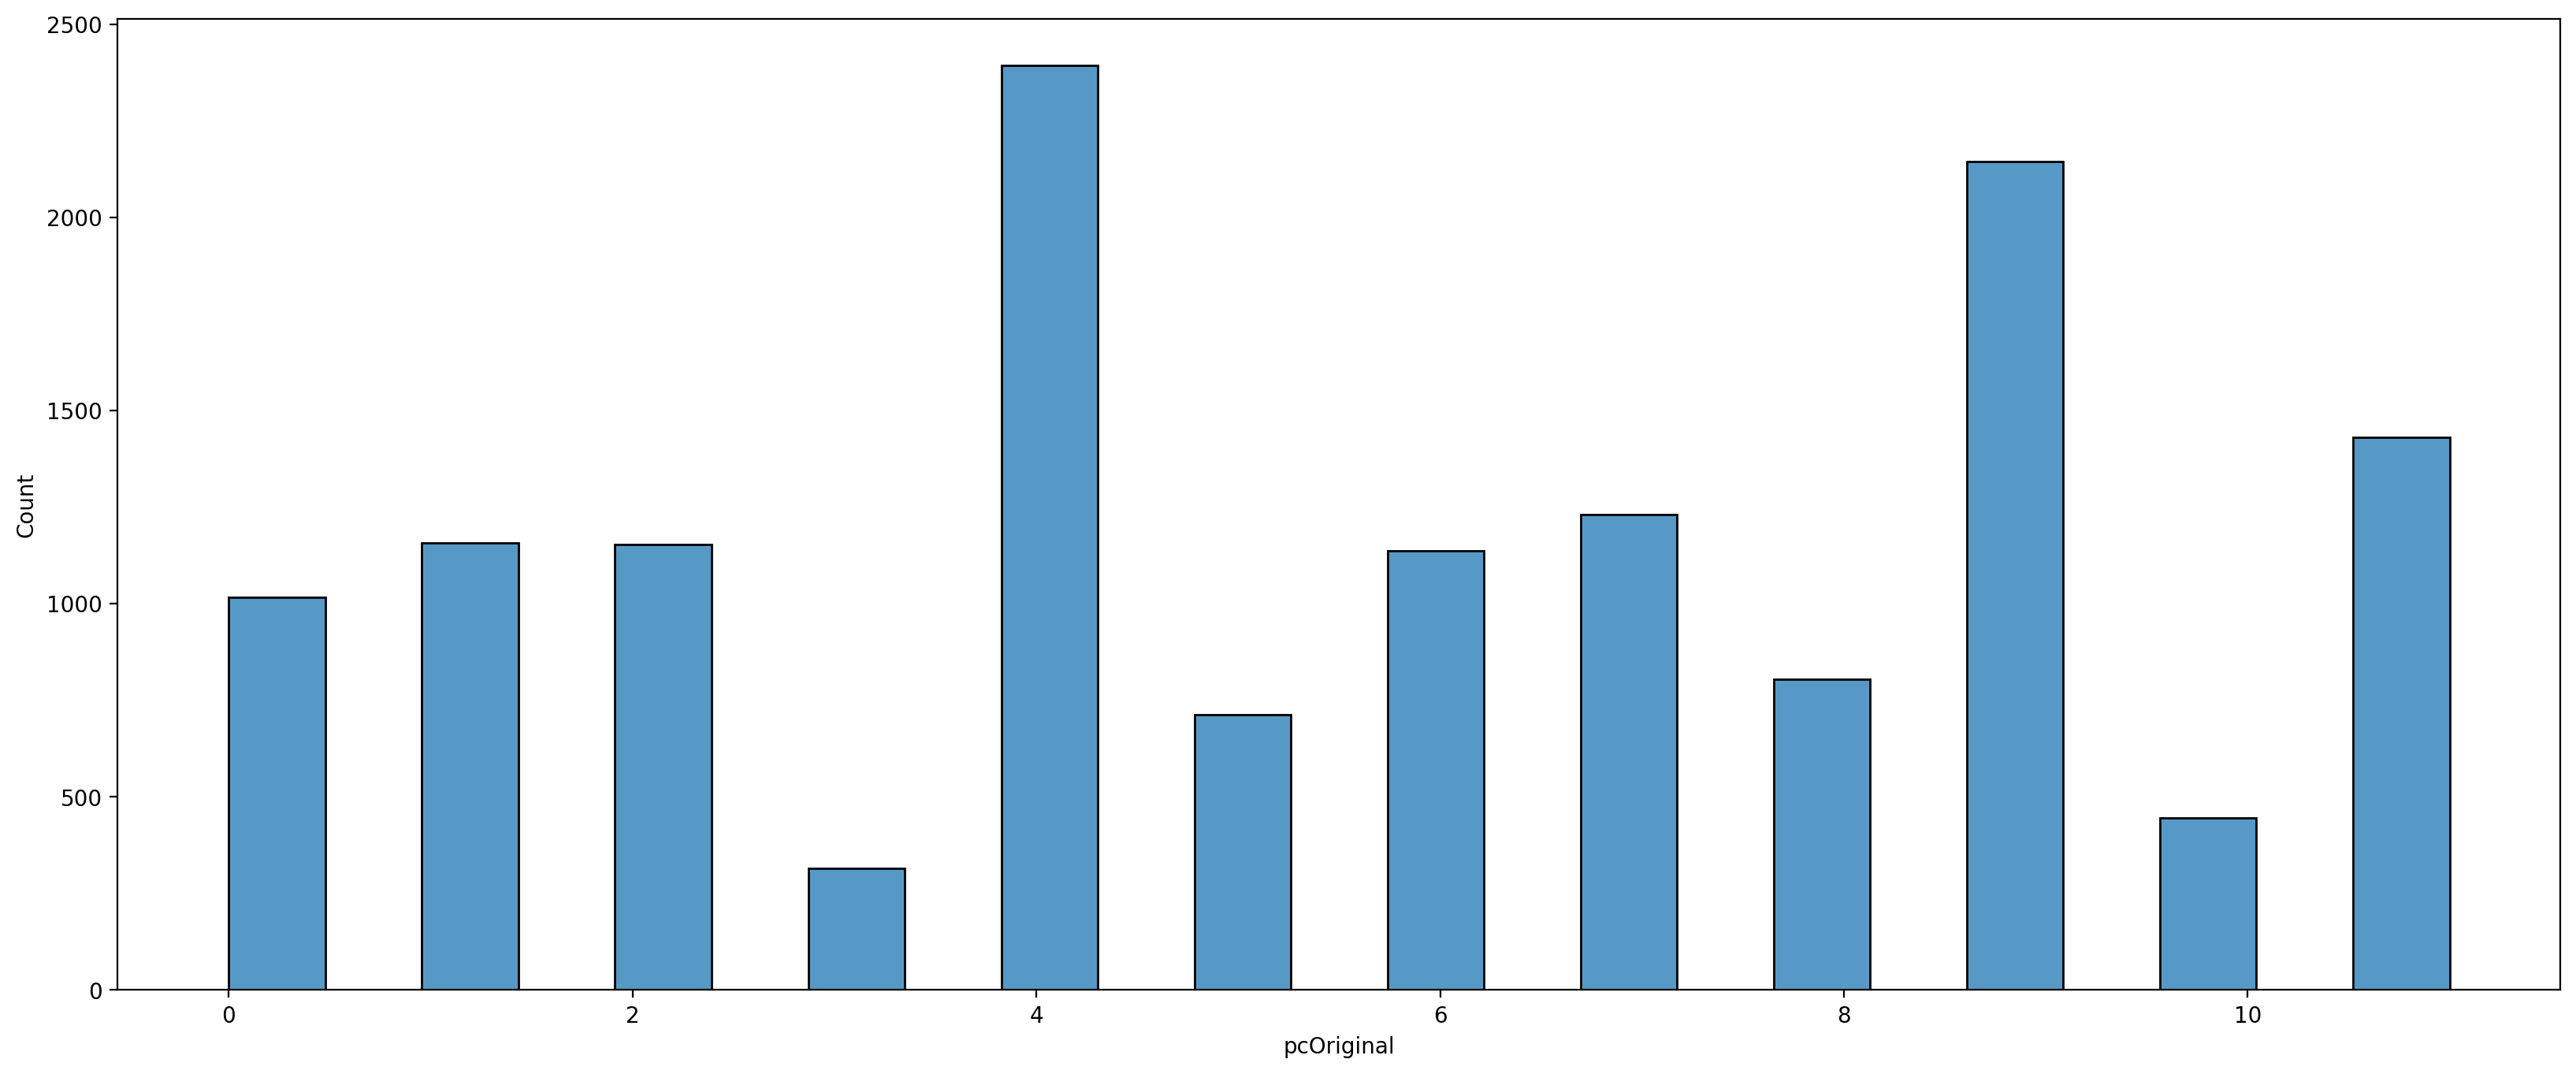

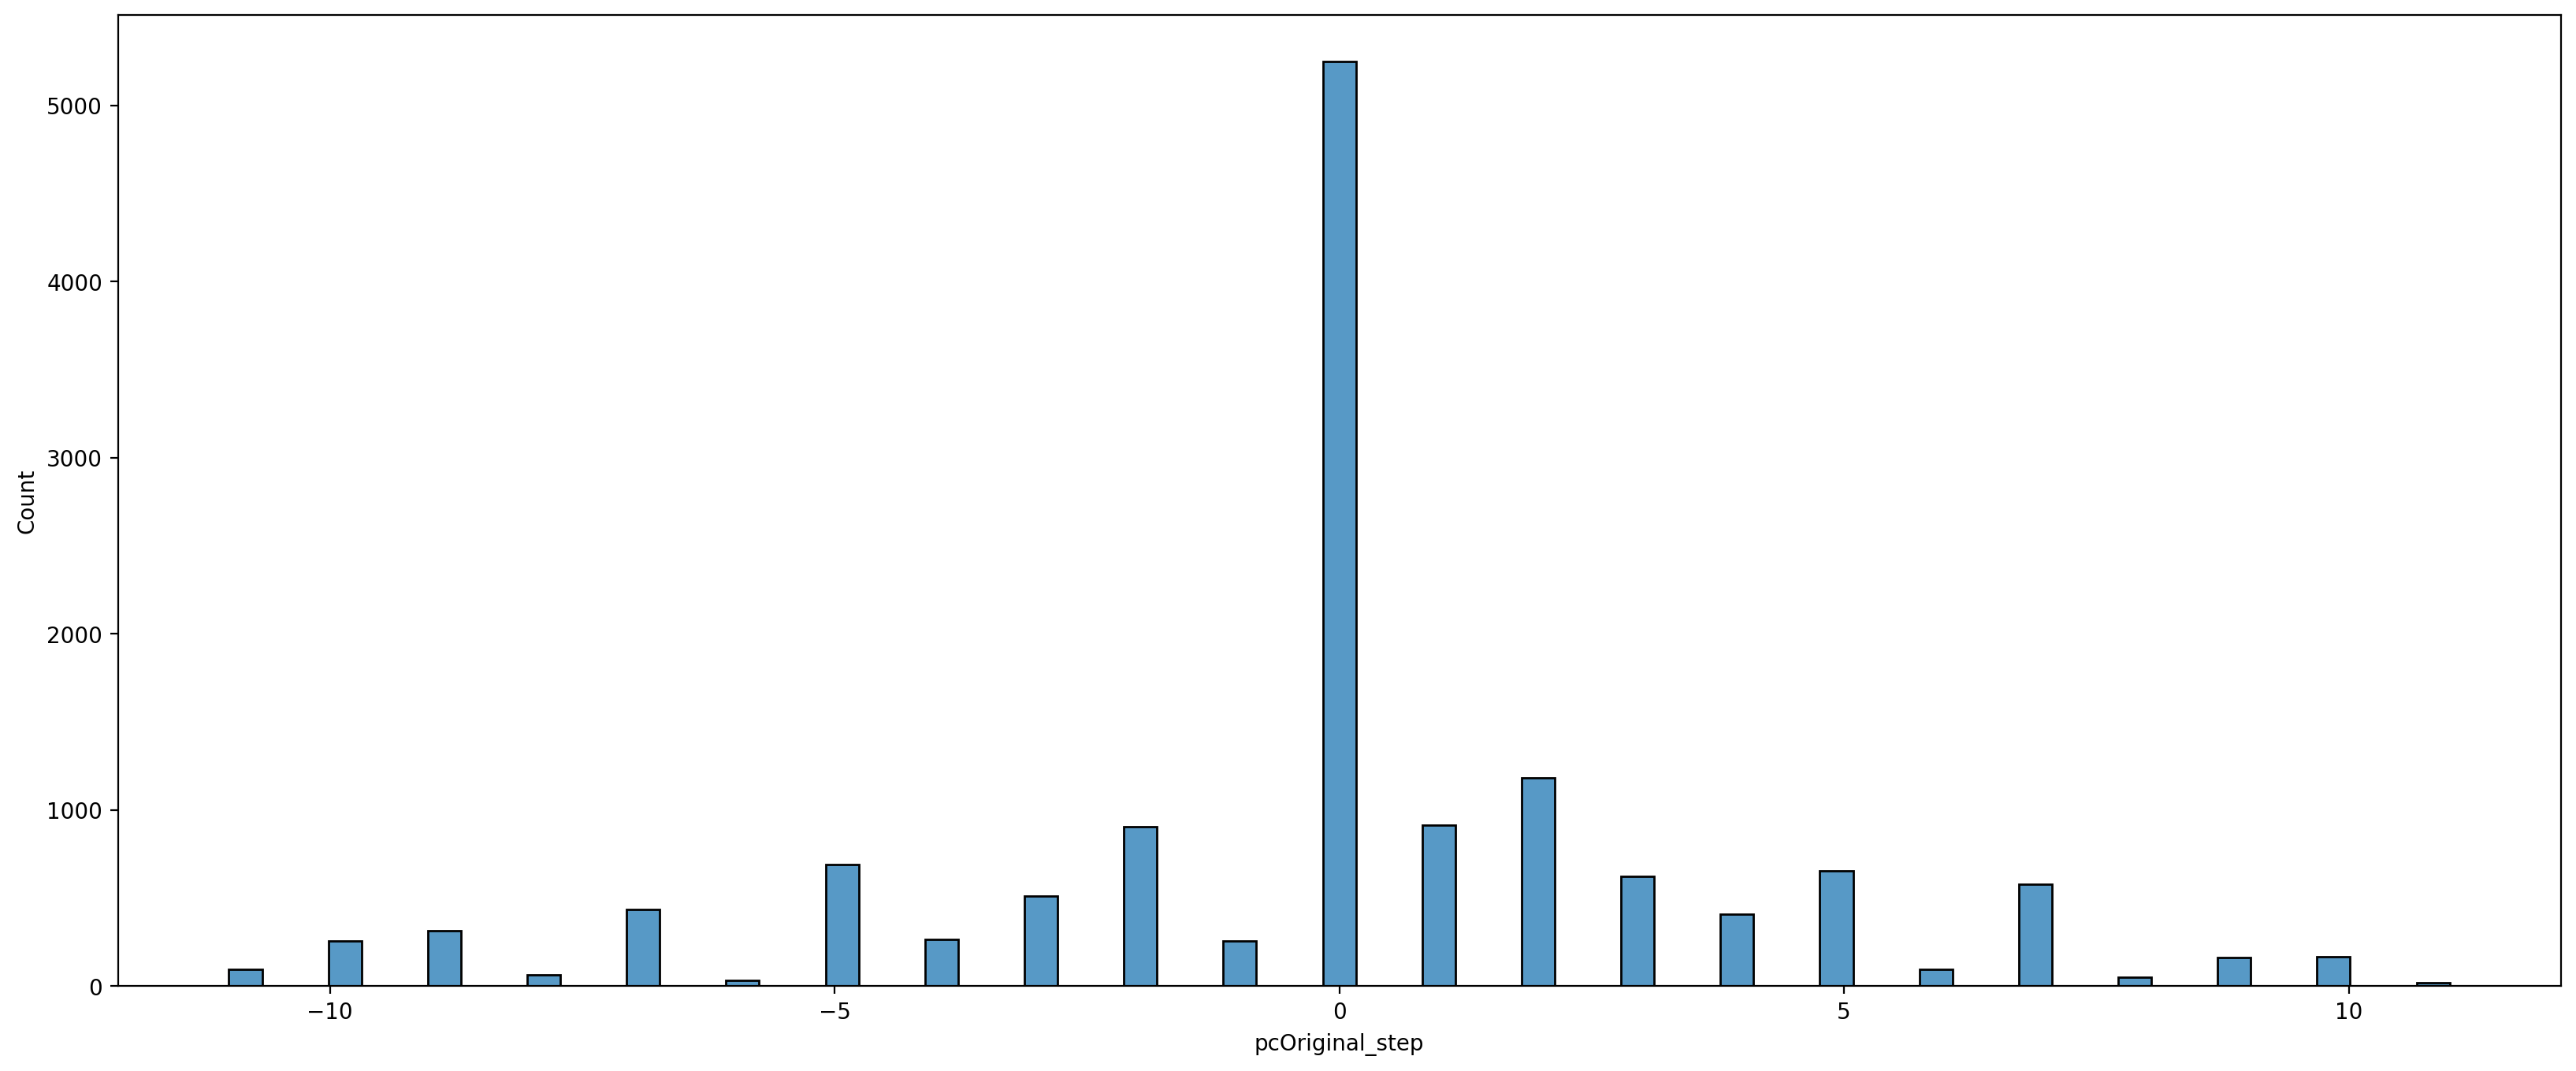

In [27]:
df = dataframe_all.sort_values(by='root_pitch')
plt.figure(figsize=[20, 8])
'''
def splitnote(val):
    if isinstance(val, list):
        return '.'.join(val)
    else:
        return str(val)
'''    
sns.histplot(df['root_note'])
plt.xticks(rotation = 90)
plt.show()

df = dataframe_all.sort_values(by='root_step')
plt.figure(figsize=[20, 8])    
sns.histplot(df['root_step'])
plt.show()

df = dataframe_all.sort_values(by='duration')
plt.figure(figsize=[20, 8])     
sns.histplot(df['duration'])
plt.show()



step = 1./16.
    
def fractions(x, pos):
    # https://stackoverflow.com/questions/33780678/how-to-label-the-x-axis-in-fraction-numbers
    if np.isclose((x/step)%(1./step),0.):
        # x is an integer, so just return that
        return '{:.0f}'.format(x)
    else:
        # this returns a latex formatted fraction
        return '$\\frac{{{:2.0f}}}{{{:2.0f}}}$'.format(x/step,1./step)
        # if you don't want to use latex, you could use this commented
        # line, which formats the fraction as "1/13"
        ### return '{:2.0f}/{:2.0f}'.format(x/step,1./step)

df['duration_scaled'] = df['duration'] / 4
plt.figure(figsize=[20, 8])
hist = sns.histplot(df, x="duration_scaled", binwidth=0.005)
hist.xaxis.set_major_locator(mticker.MultipleLocator(step))
hist.xaxis.set_major_formatter(mticker.FuncFormatter(fractions))


df = dataframe_all.sort_values(by='duration_step')
plt.figure(figsize=[20, 8])
sns.histplot(df['duration_step'])
plt.show()

df['duration_step_scaled'] = df['duration_step'] / 4
plt.figure(figsize=[20, 8])
hist = sns.histplot(df, x="duration_step_scaled", binwidth=0.005)
hist.xaxis.set_major_locator(mticker.MultipleLocator(step))
hist.xaxis.set_major_formatter(mticker.FuncFormatter(fractions))

df = dataframe_all.sort_values(by='chord_interval')
plt.figure(figsize=[15, 8])
sns.histplot(df['chord_interval'])
plt.xticks(rotation = 90)
plt.show()

df = dataframe_all.sort_values(by='cardinality')
plt.figure(figsize=[20, 8])
sns.histplot(df['cardinality'])
plt.show()

df = dataframe_all.sort_values(by='cardinality_step')
plt.figure(figsize=[20, 8])
sns.histplot(df['cardinality_step'])
plt.show()

df = dataframe_all.sort_values(by='forteClass')
plt.figure(figsize=[20, 8])
sns.histplot(df['forteClass'])
plt.show()

df = dataframe_all.sort_values(by='forteClass_step')
plt.figure(figsize=[20, 8])
sns.histplot(df['forteClass_step'])
plt.show()

df = dataframe_all.sort_values(by='inversion')
plt.figure(figsize=[20, 8])
sns.histplot(df['inversion'])
plt.show()

df = dataframe_all.sort_values(by='inversion_step')
plt.figure(figsize=[20, 8])
sns.histplot(df['inversion_step'])
plt.show()

df = dataframe_all.sort_values(by='pcOriginal')
plt.figure(figsize=[20, 8])       
sns.histplot(df['pcOriginal'])
plt.show()

df = dataframe_all.sort_values(by='pcOriginal_step')
plt.figure(figsize=[20, 8])       
sns.histplot(df['pcOriginal_step'])
plt.show()


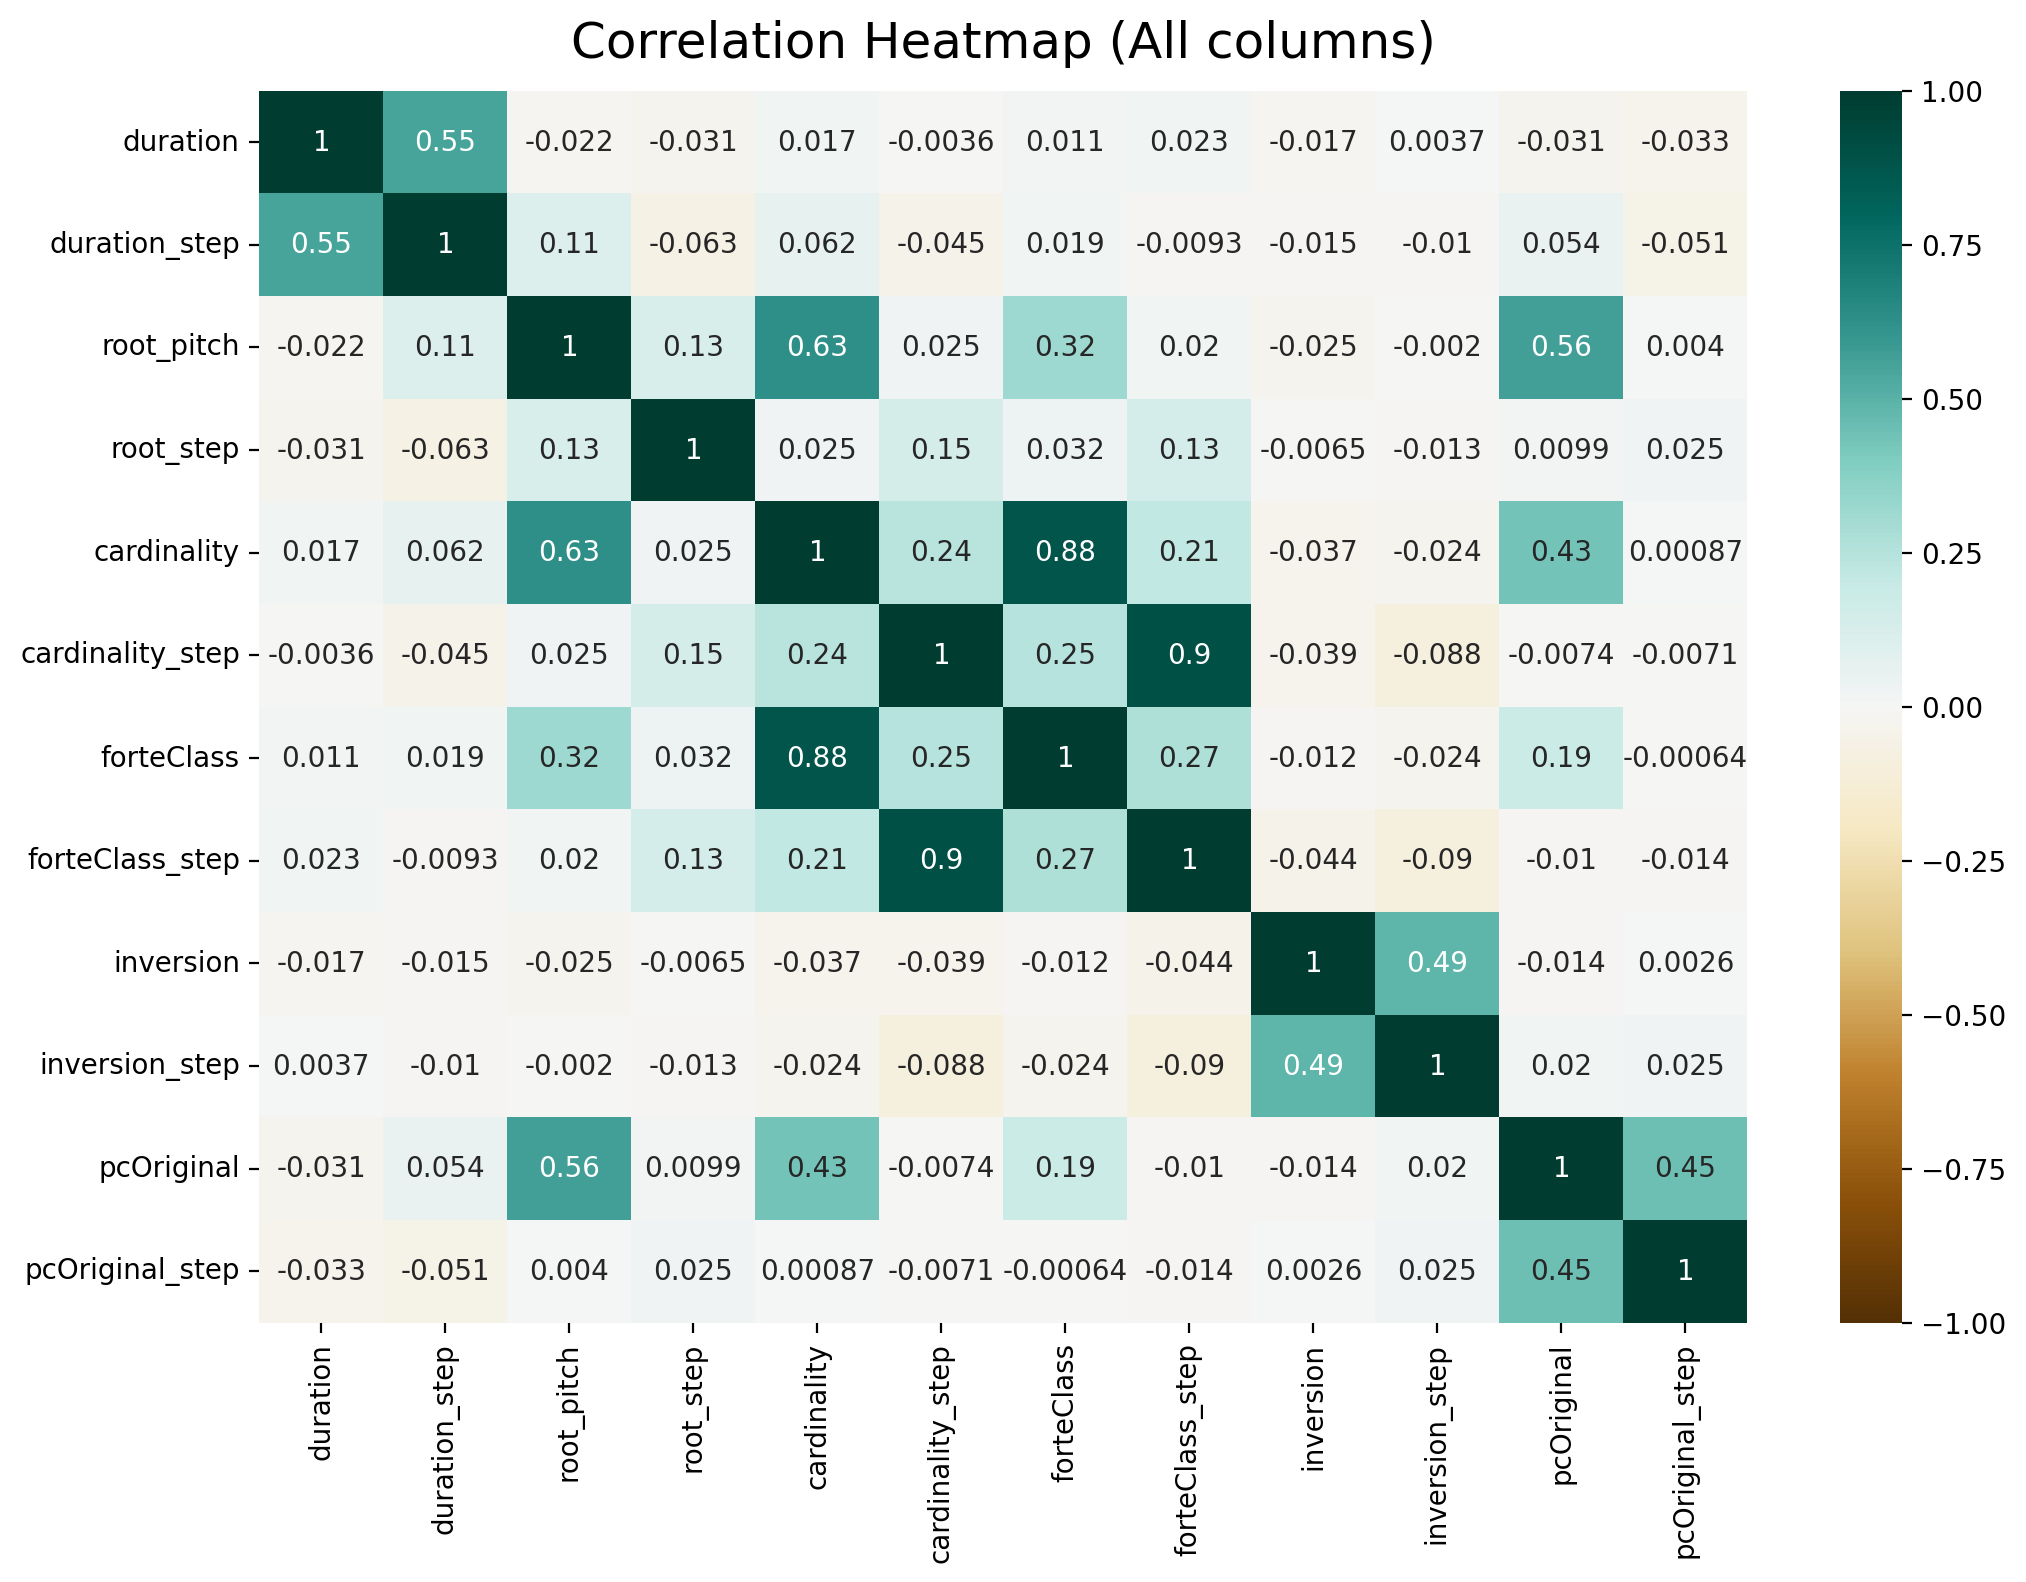

In [28]:
dataframe_corr = dataframe_all.drop(columns=['chord_interval','notes', 'note_pitches', 'root_note']).fillna(value=0)
correlation_all = dataframe_corr.corr()

plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(correlation_all, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap (All columns)', fontdict={'fontsize':18}, pad=12);
plt.show()

# plot piano roll of all MIDI data

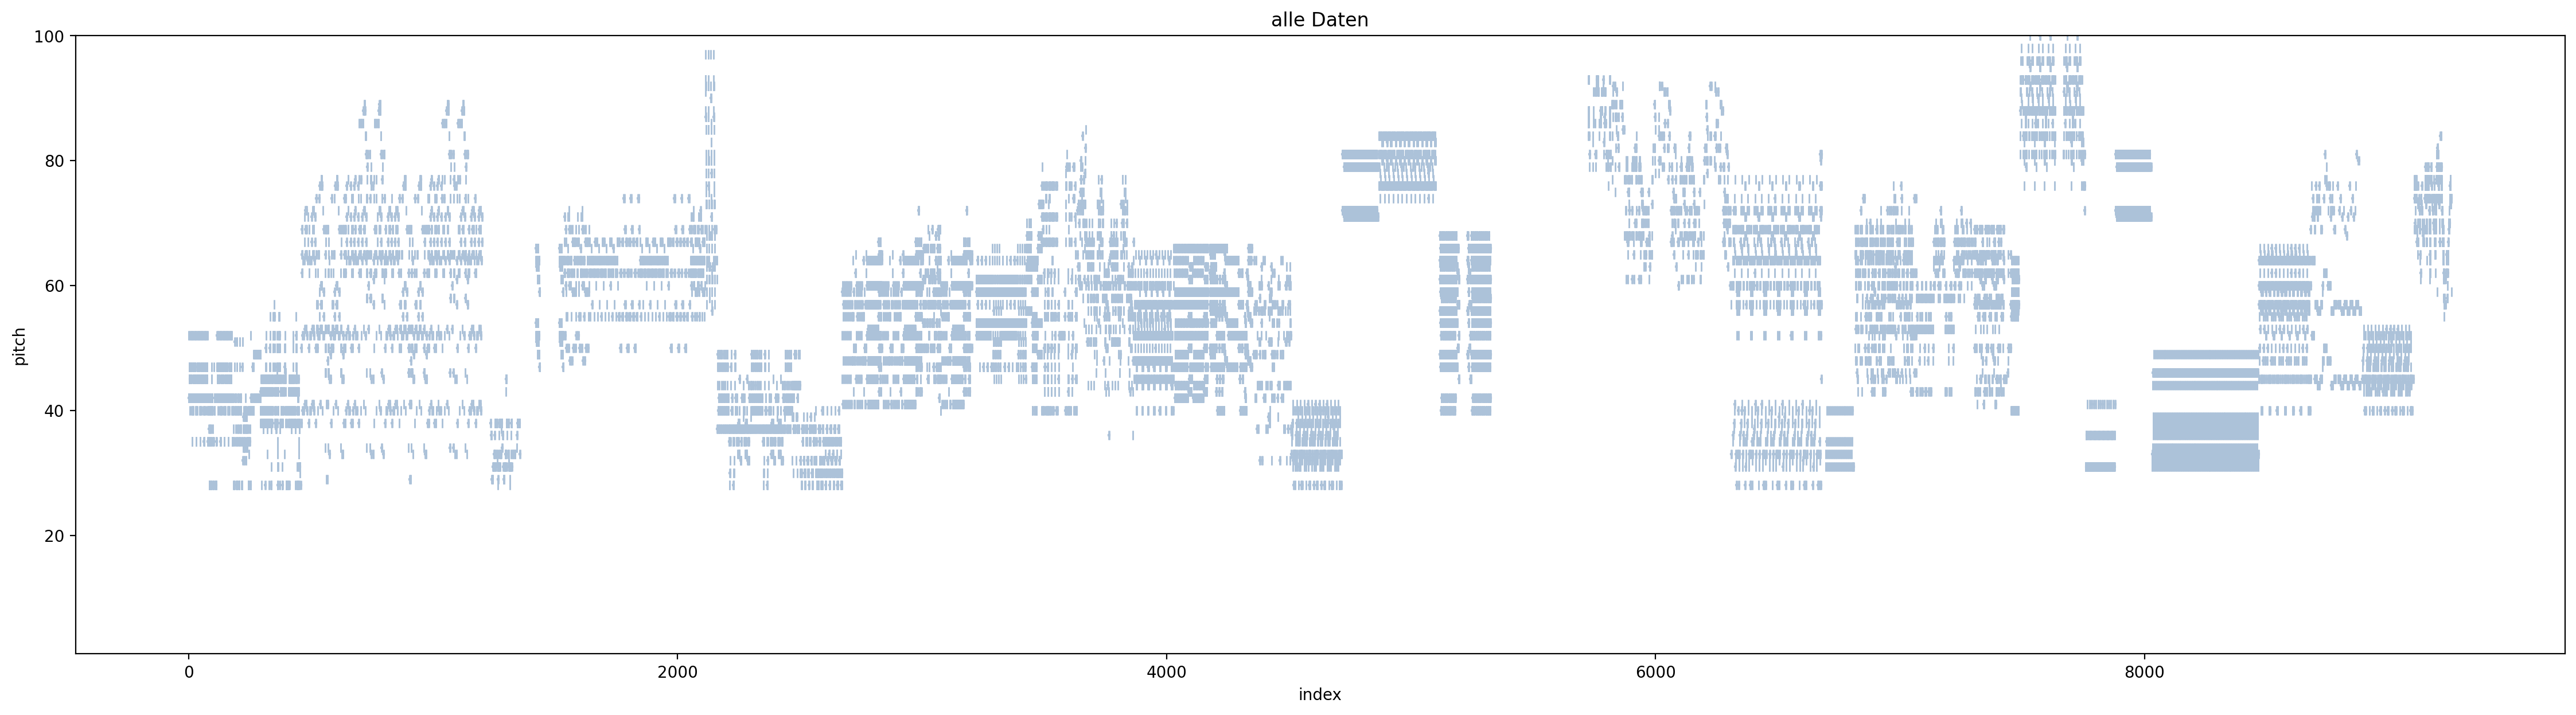

In [237]:
def plot_piano_roll(dataframes, count:int = None):
    if len(dataframes) > 1:
        title = f'All MIDI Data'
        count = 99999999999
    else:
        title = dataframes[0].name

    fig, ax1 = plt.subplots(figsize=(28, 7)) 

    for n, (notes, color) in enumerate(zip(dataframes, list(mcolors.XKCD_COLORS))):
        flat_start = []
        flat_end = []
    
        start = (notes['duration'].cumsum()).shift(periods=1)[:count]
        start[0] = 0.0
        end = (notes['duration'].cumsum())[:count]
    
        for p, s, e in zip(notes['note_pitches'][:count], start, end):
            if isinstance(p, np.ndarray):
                for n in range(len(p)): 
                    flat_start.append(s)
                    flat_end.append(e)
            else:
                flat_start.append(s)
                flat_end.append(e)
    
        flat_notes = np.hstack(notes['note_pitches'][:count].to_numpy())

        if n == 0:
            axn=ax1
        else:
            axn = ax1.twinx()
            axn.get_yaxis().set_visible(False)

        axn.plot([flat_start[0], flat_end[0]],[flat_notes[0], flat_notes[0]], color=color, marker="|", label=notes.name)
        axn.plot([flat_start[1:], flat_end[1:]],[flat_notes[1:], flat_notes[1:]], color=color, marker="|")
        axn.set_ylim([1, 100])
        axn.set_xlabel('index')
        axn.set_ylabel('pitch')
        
    plt.title(title)        
    plt.show()

plot_piano_roll([dataframe_all])

# explore sequences
create raw sequences for exploration

In [30]:
def create_sequences(df, seq_length, column_indx):

    print(f'extracting column:  "{df.columns[column_indx]}" !')
    
    xs, ys = [], []
    # Iterate over data indices
    for i in range(len(df) - seq_length):
      	# Define inputs
        x = df.iloc[i : (i+seq_length), column_indx]
        # Define target
        y = df.iloc[(i+seq_length), column_indx]
  
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

In [31]:
col_idx = [6]
seq_len = 8
X_train, y_train = create_sequences(dataframe_all, seq_len, col_idx)

extracting column:  "Index(['root_step'], dtype='object')" !


In [32]:
X_train_list = [f'{x}' for x in X_train.tolist()]
X_train_list_tar = [f'{x} --> {y}' for x, y in zip(X_train.tolist(), y_train.tolist())]
unique = np.unique(X_train_list, return_counts=True)
uniq = pd.Series(data=unique[1], index=unique[0])
uniq = uniq.sort_values(ascending=False)

df_trainmatrice = pd.DataFrame(data=y_train, columns=[f'y_{x}' for x in range(y_train.shape[1])], index=X_train_list)
df_trainmatrice= pd.get_dummies(df_trainmatrice[df_trainmatrice.columns], dtype=float)
df_trainmatrice = df_trainmatrice.groupby(df_trainmatrice.index).sum()

unique_tar = np.unique(X_train_list_tar, return_counts=True)
uniq_tar = pd.Series(data=unique_tar[1], index=unique_tar[0])
uniq_tar = uniq_tar.sort_values(ascending=False)

In [33]:
ntop = 20
print(f'Top {ntop} unique sequences')
uniq.head(ntop)

Top 20 unique sequences


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]         828
[[nan], [nan], [nan], [nan], [nan], [nan], [nan], [nan]]         125
[[nan], [4.0], [nan], [3.0], [nan], [5.0], [nan], [-5.0]]         98
[[4.0], [nan], [3.0], [nan], [5.0], [nan], [-5.0], [nan]]         98
[[nan], [3.0], [nan], [5.0], [nan], [-5.0], [nan], [-3.0]]        72
[[3.0], [nan], [5.0], [nan], [-5.0], [nan], [-3.0], [nan]]        72
[[1.0], [10.0], [2.0], [-10.0], [1.0], [1.0], [1.0], [7.0]]       62
[[2.0], [-10.0], [1.0], [1.0], [1.0], [7.0], [3.0], [-18.0]]      62
[[1.0], [1.0], [10.0], [2.0], [-10.0], [1.0], [1.0], [1.0]]       62
[[1.0], [1.0], [1.0], [7.0], [3.0], [-18.0], [1.0], [1.0]]        62
[[-10.0], [1.0], [1.0], [1.0], [7.0], [3.0], [-18.0], [1.0]]      62
[[1.0], [1.0], [1.0], [10.0], [2.0], [-10.0], [1.0], [1.0]]       62
[[10.0], [2.0], [-10.0], [1.0], [1.0], [1.0], [7.0], [3.0]]       62
[[1.0], [7.0], [3.0], [-18.0], [1.0], [1.0], [1.0], [10.0]]       61
[[7.0], [3.0], [-18.0], [1.0], [1.

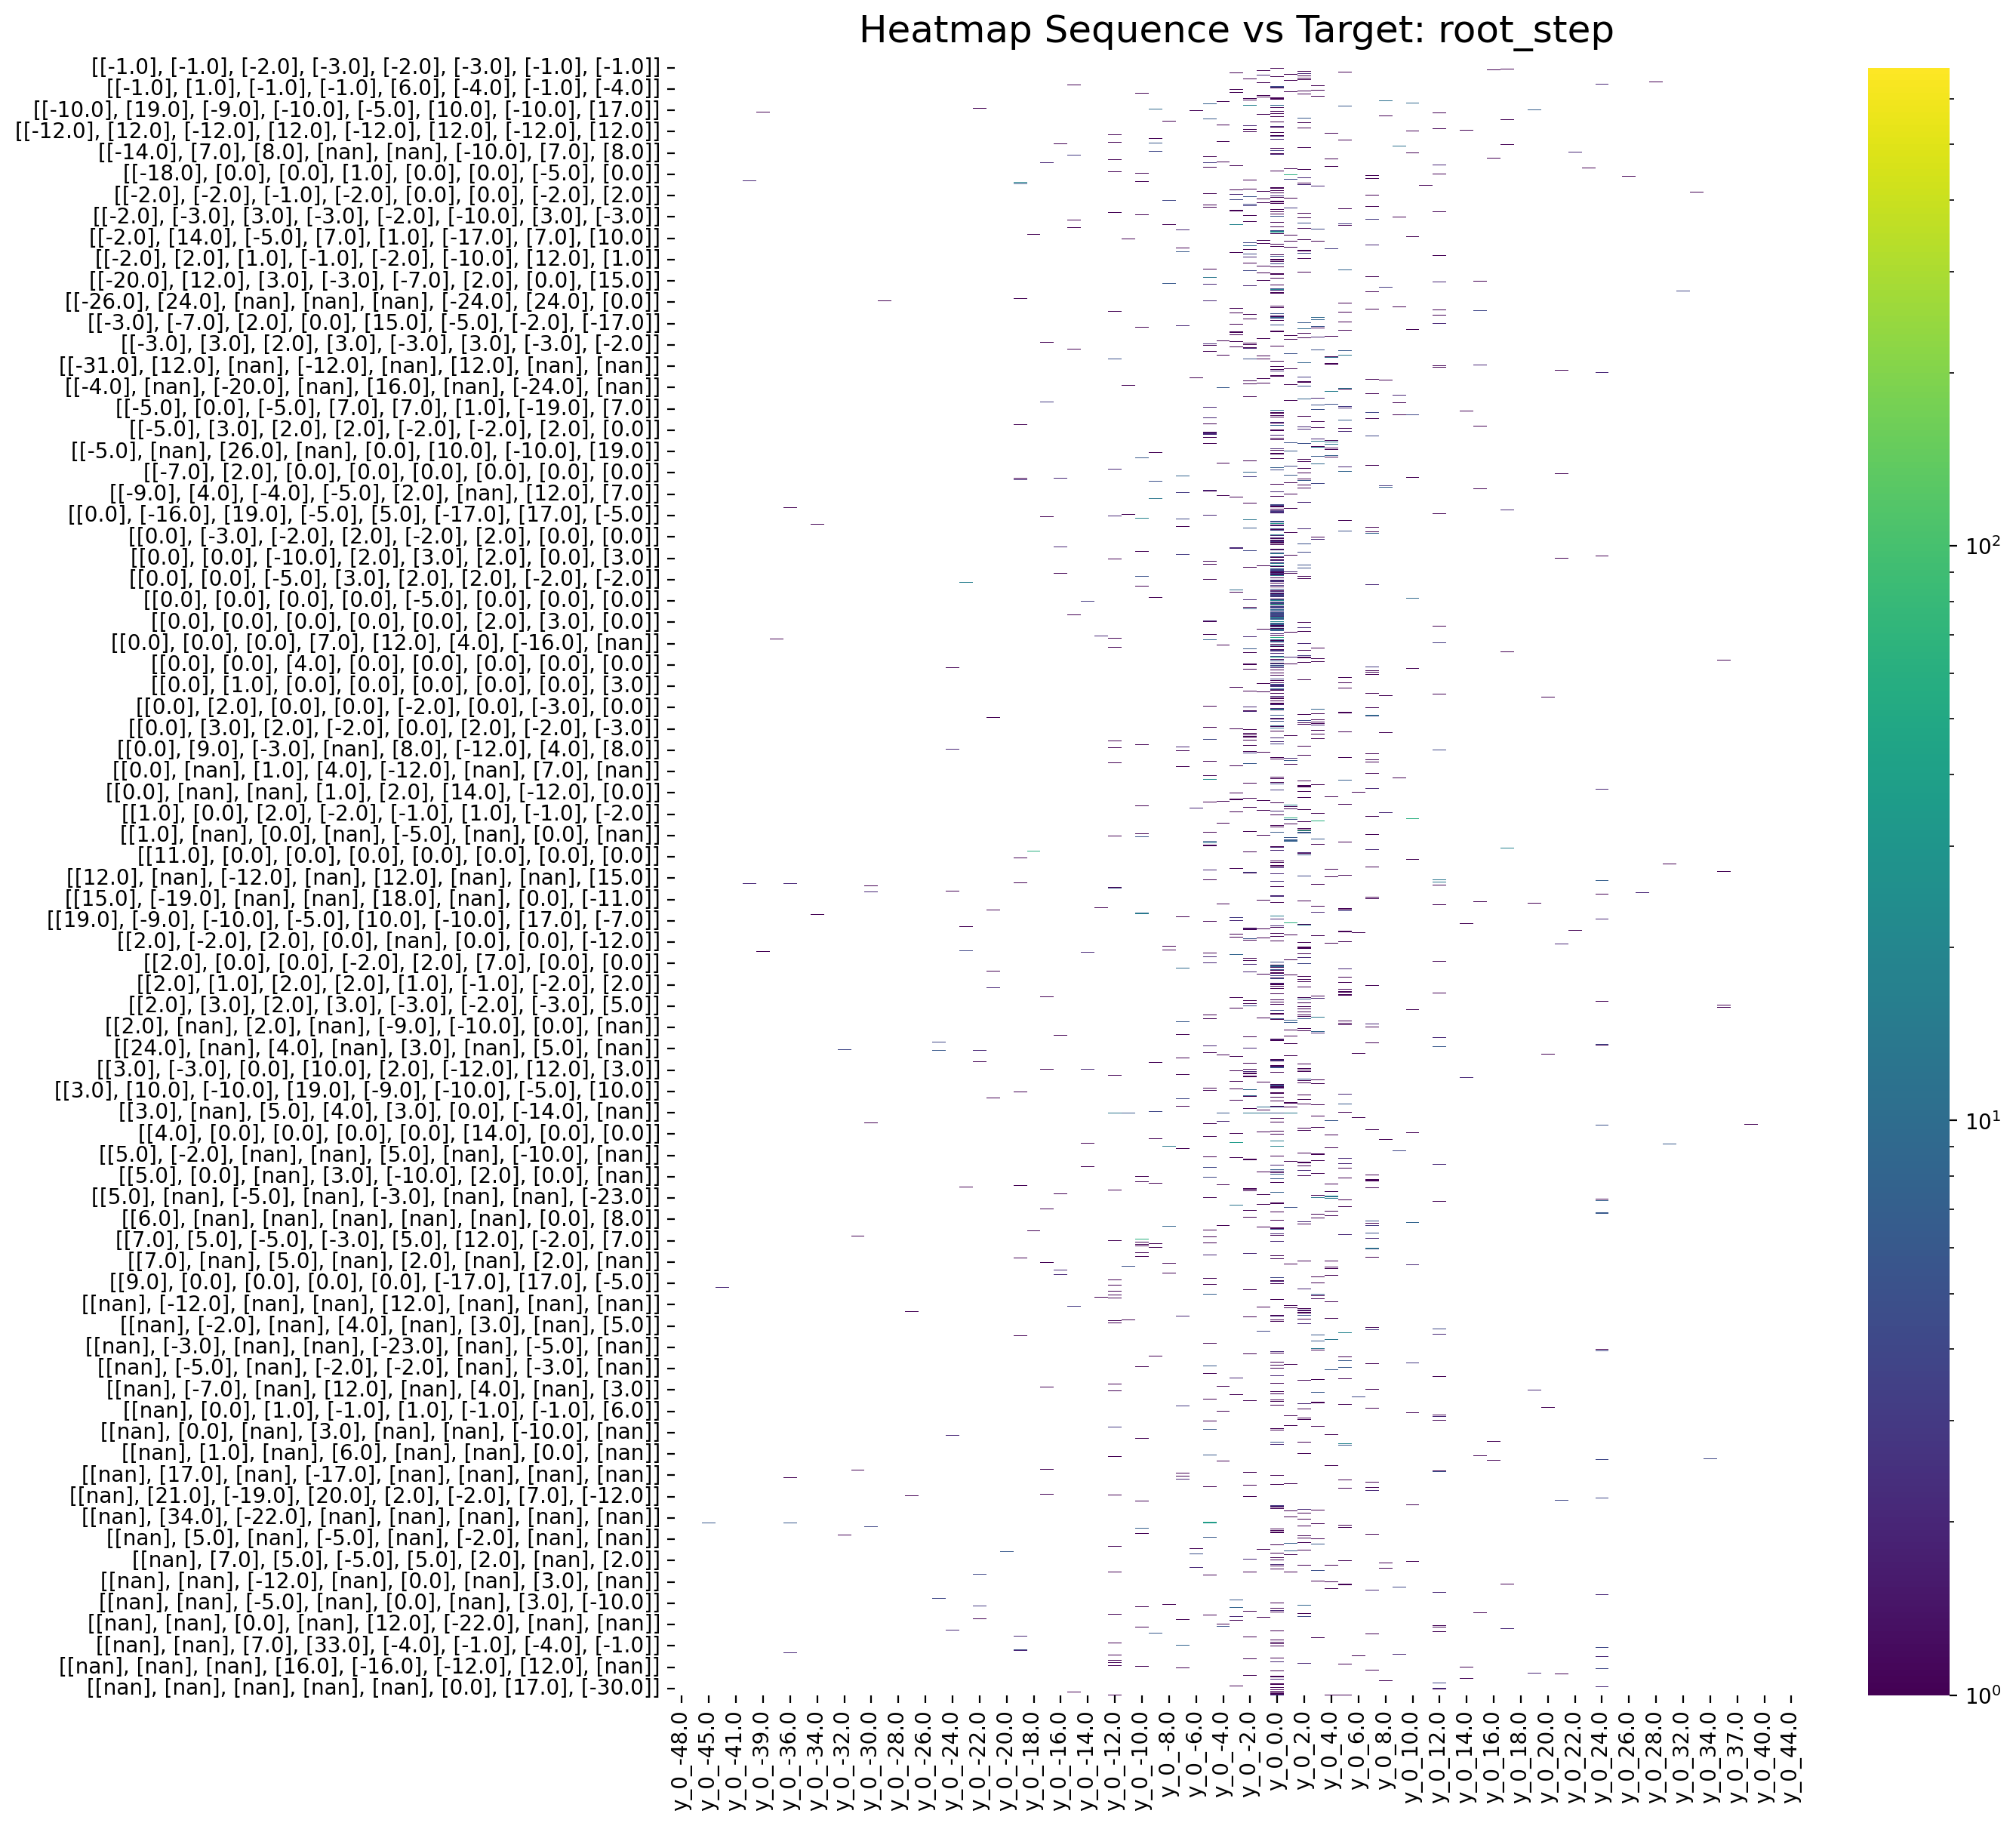

In [34]:
plt.figure(figsize=(12, 14))
heatmap = sns.heatmap(df_trainmatrice, annot=False, norm=mcolors.LogNorm(), cmap='viridis')
heatmap.set_title(f'Heatmap Sequence vs Target: {df.columns[col_idx][0]}', fontdict={'fontsize':18}, pad=12)
plt.show()

In [35]:
print(f'Top {ntop} unique sequences with target')
uniq_tar.head(ntop)

Top 20 unique sequences with target


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]] --> [0.0]         680
[[nan], [nan], [nan], [nan], [nan], [nan], [nan], [nan]] --> [nan]         119
[[nan], [4.0], [nan], [3.0], [nan], [5.0], [nan], [-5.0]] --> [nan]         98
[[4.0], [nan], [3.0], [nan], [5.0], [nan], [-5.0], [nan]] --> [-3.0]        72
[[nan], [3.0], [nan], [5.0], [nan], [-5.0], [nan], [-3.0]] --> [nan]        72
[[10.0], [2.0], [-10.0], [1.0], [1.0], [1.0], [7.0], [3.0]] --> [-18.0]     62
[[1.0], [1.0], [10.0], [2.0], [-10.0], [1.0], [1.0], [1.0]] --> [7.0]       62
[[-10.0], [1.0], [1.0], [1.0], [7.0], [3.0], [-18.0], [1.0]] --> [1.0]      62
[[1.0], [10.0], [2.0], [-10.0], [1.0], [1.0], [1.0], [7.0]] --> [3.0]       62
[[2.0], [-10.0], [1.0], [1.0], [1.0], [7.0], [3.0], [-18.0]] --> [1.0]      62
[[1.0], [1.0], [1.0], [10.0], [2.0], [-10.0], [1.0], [1.0]] --> [1.0]       62
[[1.0], [7.0], [3.0], [-18.0], [1.0], [1.0], [1.0], [10.0]] --> [2.0]       61
[[1.0], [1.0], [7.0], [3.0], [-18.0], [1.0], [1.0], 

## explore outlier

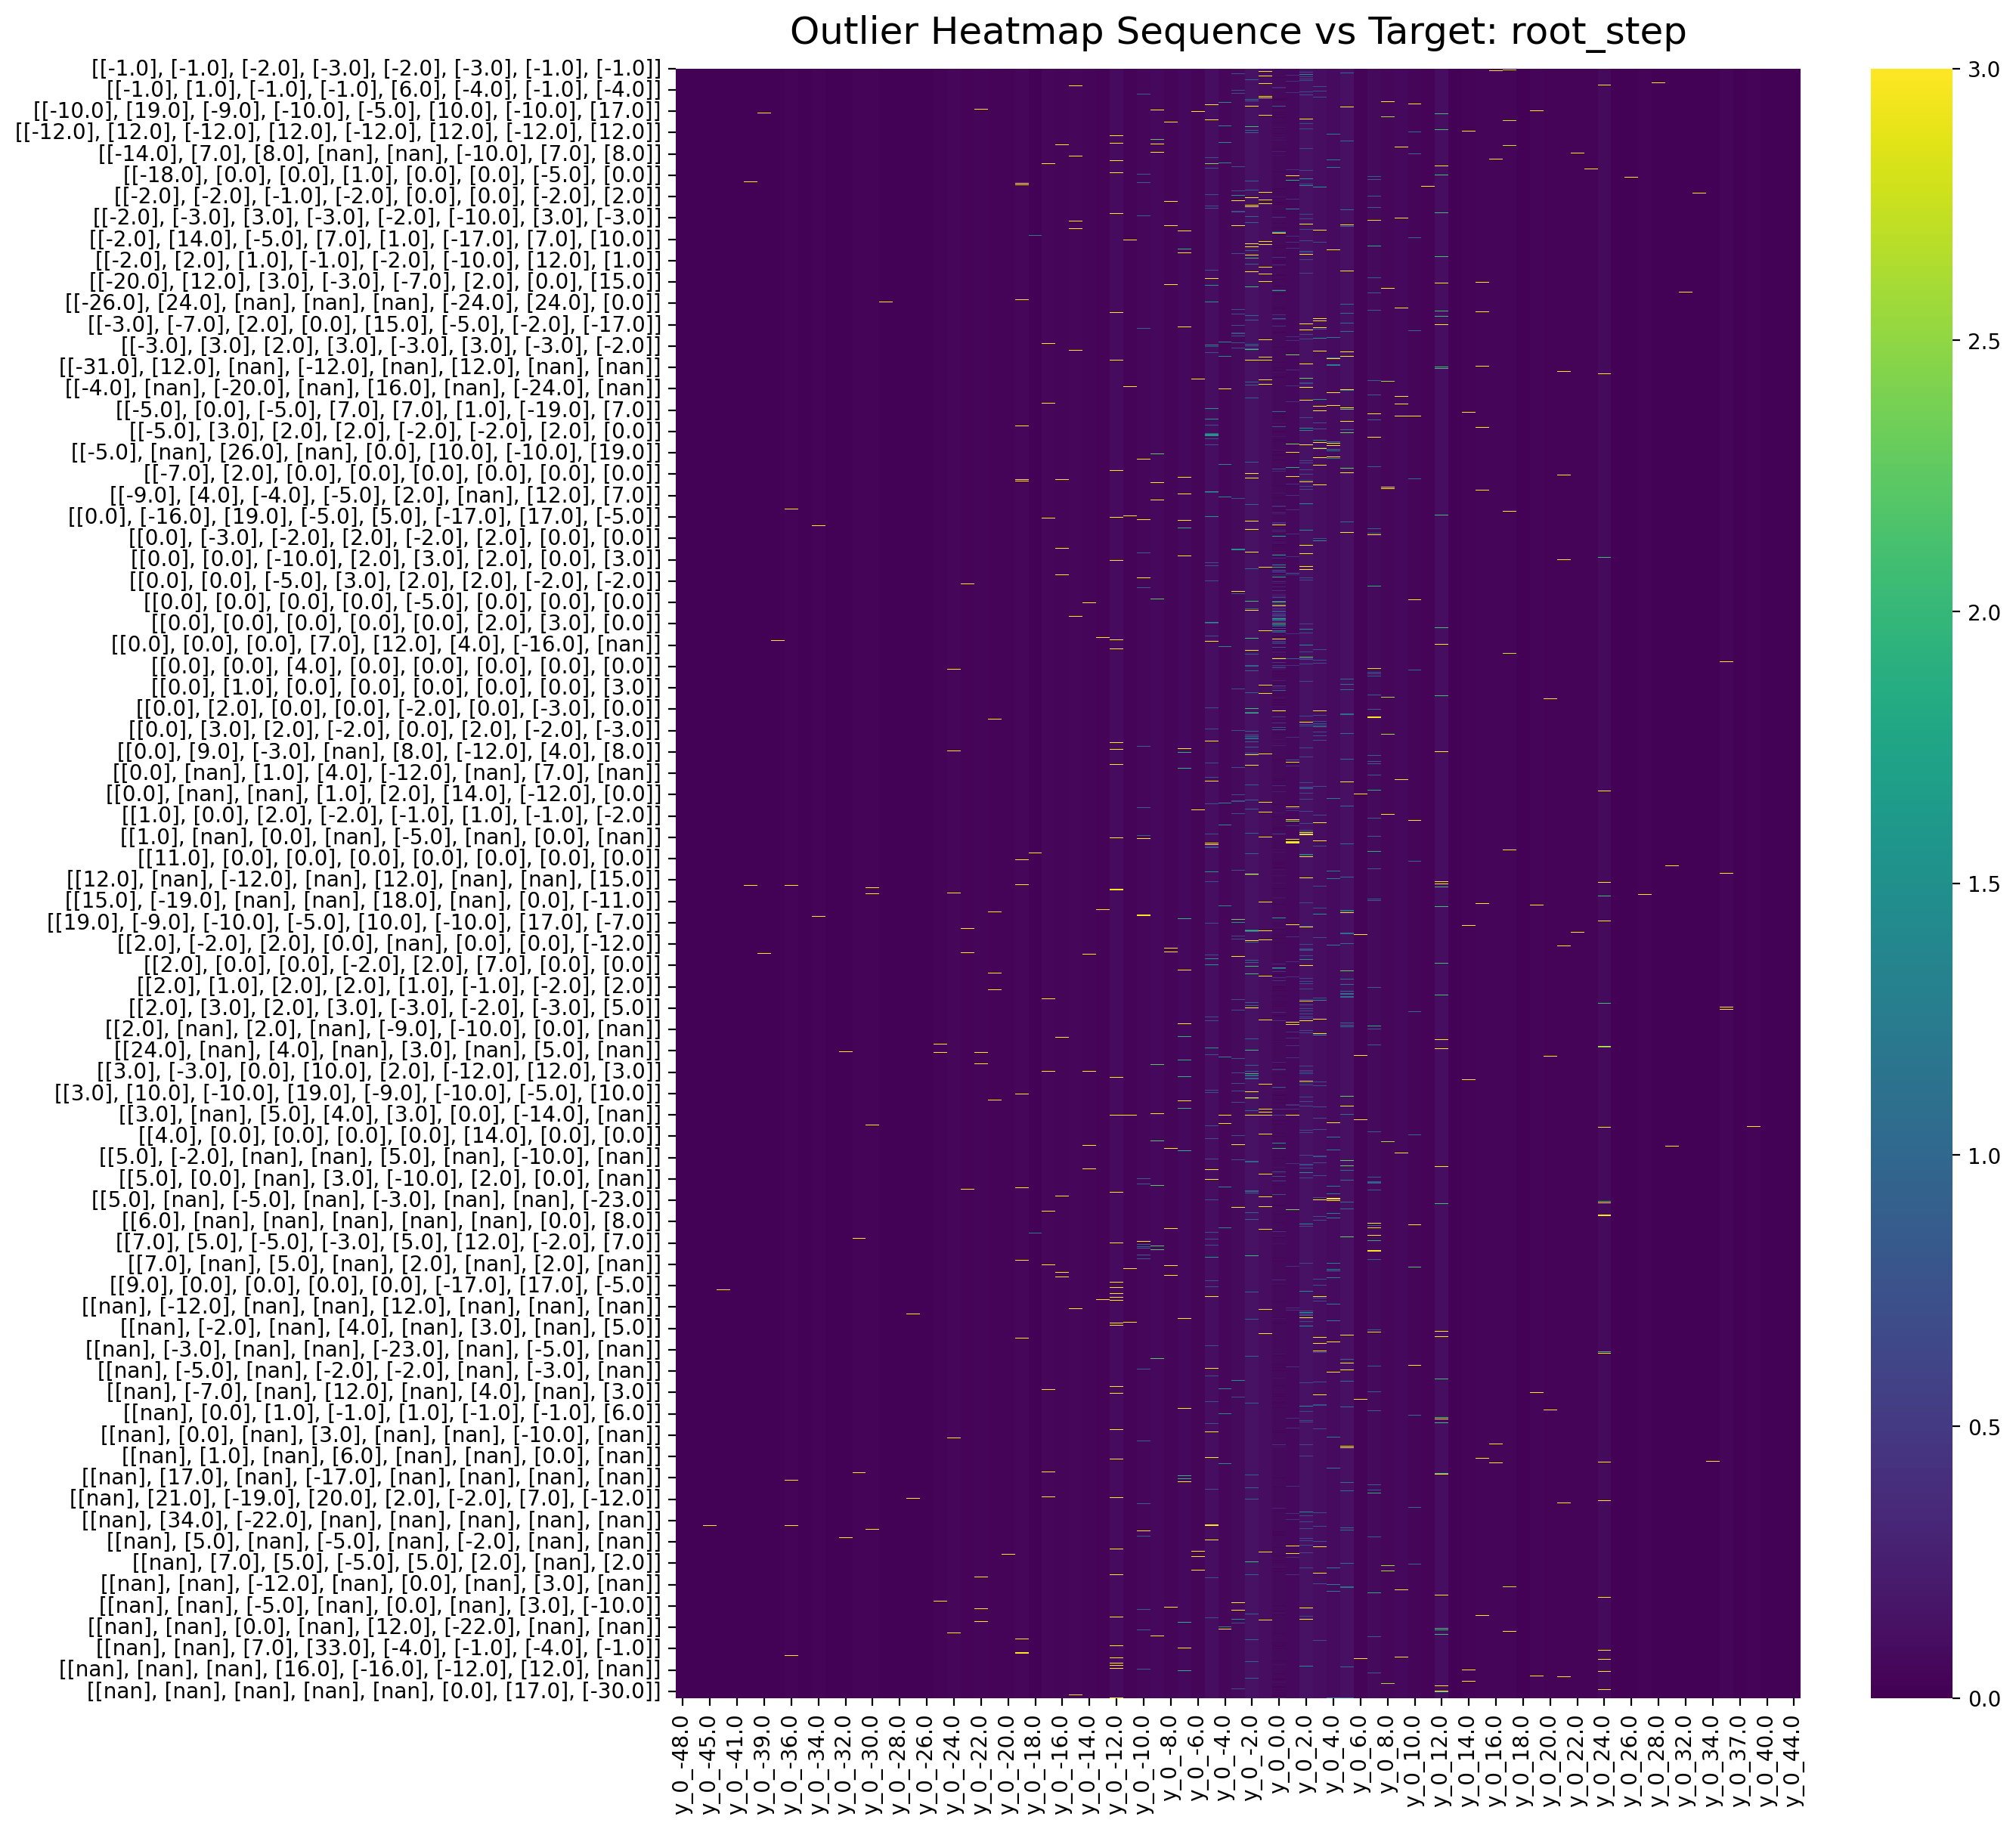

In [38]:
df_outlier = df_trainmatrice.copy()

for col in df_trainmatrice.columns:
    df_outlier[col] = np.abs(zscore(df_trainmatrice[col]))

df_outlier = np.abs(zscore(df_trainmatrice, axis = 0, ddof = 1))

plt.figure(figsize=(12, 14))
heatmap = sns.heatmap(df_outlier, annot=False, vmin = 0, vmax = 3, cmap='viridis')
heatmap.set_title(f'Outlier Heatmap Sequence vs Target: {df.columns[col_idx][0]}', fontdict={'fontsize':18}, pad=12)
plt.show()

# OHE encoded sequences
now create sequences in one-hot encoded format for machine learning

In [39]:
for col, idx in zip(dataframe_all.columns, range(len(dataframe_all.columns))):
    print(idx, col)

0 notes
1 note_pitches
2 duration
3 duration_step
4 root_note
5 root_pitch
6 root_step
7 chord_interval
8 cardinality
9 cardinality_step
10 forteClass
11 forteClass_step
12 inversion
13 inversion_step
14 pcOriginal
15 pcOriginal_step


In [40]:
col_idx = [2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
seq_len = 8

#print(dataframe_all.columns[idx])

X_train, y_train = np.array(()), np.array(())

mi = []
ma = []
ste = []

for idx in col_idx:
    uniq = np.unique(dataframe_all[dataframe_all.columns[idx]].values)
    
    i = np.nanmin(uniq)
    s = np.nanmin(np.diff(uniq))
    a = np.nanmax(uniq) + s
    mi.append(i)
    ma.append(a)
    ste.append(s)
    
    #print(uniq, i, a, s)

#print(mi, ma, ste)


def create_ohe_sequences(df, seq_length, column_indx, min_list, max_list, step_list, verbose):

    col_names = df.columns[column_indx]

    Xs, Ys, Fact, deFact = {}, {}, {}, {}
    
    for min, max, step, colname in zip(min_list, max_list, step_list, col_names):
    
        ohe_values = np.arange(min, max, step)
        ohe_values = np.append(ohe_values, values=[np.nan])
        ohe_replace = [x for x in range(len(ohe_values))]

        if verbose > 0:
            print(f'extracting sequences with len: {seq_length} from column: "{colname}", replacing {len(ohe_values)} values!')
        
        factorize_dict = dict(itertools.zip_longest(*[iter(ohe_values)], ohe_replace, fillvalue="-1"))
        defactorize_dict = dict(itertools.zip_longest(*[iter(ohe_replace)], ohe_values, fillvalue="-1"))

        df_factorized = df[colname].replace(factorize_dict)
    
        encoder = LabelBinarizer()
        encoder.fit(ohe_replace)
    
        df_transformed = encoder.transform(df_factorized)

        #print(df_transformed)
    
        xs, ys = [], []
        # Iterate over data indices
        for i in range((len(df_transformed) - seq_length)):
          	# Define inputs
            x = df_transformed[i : (i + seq_length)]
            # Define target
            y = df_transformed[(i + seq_length)]
      
            xs.append(x)
            ys.append(y)

        Xs[colname] = np.array(xs)
        Ys[colname] = np.array(ys)
        Fact[colname] = factorize_dict
        deFact[colname] = defactorize_dict
        
        if verbose > 0:
            print(f'extracted {len(xs)} sequences from column: "{colname}"!')
        
    return Xs, Ys, Fact, deFact

X_train, y_train, factorizing_dict, defactorize_dict = create_ohe_sequences(dataframe_all, seq_len, col_idx, mi, ma, ste, 1)
#X_train, y_train, factorizing_dict, defactorize_dict = create_factorized_sequences(dataframe_all, seq_len, col_idx, mi, ma, ste)

extracting sequences with len: 8 from column: "duration", replacing 34 values!
extracted 18634 sequences from column: "duration"!
extracting sequences with len: 8 from column: "duration_step", replacing 66 values!
extracted 18634 sequences from column: "duration_step"!
extracting sequences with len: 8 from column: "root_pitch", replacing 75 values!
extracted 18634 sequences from column: "root_pitch"!
extracting sequences with len: 8 from column: "root_step", replacing 94 values!
extracted 18634 sequences from column: "root_step"!
extracting sequences with len: 8 from column: "cardinality", replacing 6 values!
extracted 18634 sequences from column: "cardinality"!
extracting sequences with len: 8 from column: "cardinality_step", replacing 8 values!
extracted 18634 sequences from column: "cardinality_step"!
extracting sequences with len: 8 from column: "forteClass", replacing 36 values!
extracted 18634 sequences from column: "forteClass"!
extracting sequences with len: 8 from column: "for

### get all sequences and target nan (Rest)
sequences where all x-values of a sequence are nan and y-target is also nan

In [41]:
for (Xkey, Xval), (ykey, yval) in zip(X_train.items(), y_train.items()):
    where_all_nan = (np.sum(Xval[ : , : , -1], axis=1) == Xval.shape[1]) & (yval[:,-1] == 1)
    print(f'{Xkey}: {len(Xval[where_all_nan])} nan sequences | {len(Xval[where_all_nan]) / len(Xval) * 100:.5}% of data!')

duration: 0 nan sequences | 0.0% of data!
duration_step: 0 nan sequences | 0.0% of data!
root_pitch: 119 nan sequences | 0.63862% of data!
root_step: 119 nan sequences | 0.63862% of data!
cardinality: 119 nan sequences | 0.63862% of data!
cardinality_step: 119 nan sequences | 0.63862% of data!
forteClass: 119 nan sequences | 0.63862% of data!
forteClass_step: 119 nan sequences | 0.63862% of data!
inversion: 119 nan sequences | 0.63862% of data!
inversion_step: 119 nan sequences | 0.63862% of data!
pcOriginal: 119 nan sequences | 0.63862% of data!
pcOriginal_step: 119 nan sequences | 0.63862% of data!


we should consider removing them!!

In [42]:
X_train_clean, y_train_clean = {}, {}


print('original:')
for (Xkey, Xval), (ykey, yval) in zip(X_train.items(), y_train.items()):
    print(Xkey, len(Xval))
    X_train_clean[Xkey] = Xval[~where_all_nan]
    y_train_clean[ykey] = yval[~where_all_nan]

print('\n\ncleansed:')
for (Xkey, Xval), (ykey, yval) in zip(X_train_clean.items(), y_train_clean.items()):
    print(Xkey, len(Xval))

original:
duration 18634
duration_step 18634
root_pitch 18634
root_step 18634
cardinality 18634
cardinality_step 18634
forteClass 18634
forteClass_step 18634
inversion 18634
inversion_step 18634
pcOriginal 18634
pcOriginal_step 18634


cleansed:
duration 18515
duration_step 18515
root_pitch 18515
root_step 18515
cardinality 18515
cardinality_step 18515
forteClass 18515
forteClass_step 18515
inversion 18515
inversion_step 18515
pcOriginal 18515
pcOriginal_step 18515


### get all sequences with missing values after encoding

In [43]:
for (Xkey, Xval), (ykey, yval) in zip(X_train_clean.items(), y_train_clean.items()):
    #print(Xkey)

    where_missing_data = (np.sum(np.sum(Xval[ : , : , :], axis=2), axis=1) < Xval.shape[1]) | (np.sum(yval, axis=1) < 1)
    
    print(f'{Xkey}: {len(Xval[where_missing_data])} sequences with missing value after encoding | {len(Xval[where_missing_data]) / len(Xval) * 100:.5}% of data!')

duration: 0 sequences with missing value after encoding | 0.0% of data!
duration_step: 0 sequences with missing value after encoding | 0.0% of data!
root_pitch: 0 sequences with missing value after encoding | 0.0% of data!
root_step: 0 sequences with missing value after encoding | 0.0% of data!
cardinality: 0 sequences with missing value after encoding | 0.0% of data!
cardinality_step: 0 sequences with missing value after encoding | 0.0% of data!
forteClass: 0 sequences with missing value after encoding | 0.0% of data!
forteClass_step: 0 sequences with missing value after encoding | 0.0% of data!
inversion: 0 sequences with missing value after encoding | 0.0% of data!
inversion_step: 0 sequences with missing value after encoding | 0.0% of data!
pcOriginal: 0 sequences with missing value after encoding | 0.0% of data!
pcOriginal_step: 0 sequences with missing value after encoding | 0.0% of data!


## define tensor dataset

In [44]:
class MidiDataset(TensorDataset):
    def __init__(self, mididata_x: dict, mididata_y: dict):
        super().__init__()
        for (keyx, x), (keyy, y) in zip(mididata_x.items(), mididata_y.items()):
            if keyx == 'duration':
                self.duration_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'duration_step':
                self.duration_step_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'root_pitch':
                self.root_pitch_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'root_step':
                self.root_step_data = torch.from_numpy(x).float().to(DEVICE)           
            elif keyx == 'cardinality':
                self.cardinality_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'cardinality_step':
                self.cardinality_step_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'forteClass':
                self.forteClass_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'forteClass_step':
                self.forteClass_step_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'inversion':
                self.inversion_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'inversion_step':
                self.inversion_step_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'pcOriginal':
                self.pcOriginal_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'pcOriginal_step':
                self.pcOriginal_step_data = torch.from_numpy(x).float().to(DEVICE)

            if keyy == 'duration':
                self.duration_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'duration_step':
                self.duration_step_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'root_pitch':
                self.root_pitch_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'root_step':
                self.root_step_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'cardinality':
                self.cardinality_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'cardinality_step':
                self.cardinality_step_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'forteClass':
                self.forteClass_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'forteClass_step':
                self.forteClass_step_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'inversion':
                self.inversion_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyx == 'inversion_step':
                self.inversion_step_label = torch.from_numpy(y).float().to(DEVICE)       
            elif keyy == 'pcOriginal':
                self.pcOriginal_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'pcOriginal_step':
                self.pcOriginal_step_label = torch.from_numpy(y).float().to(DEVICE)

        assert(self.duration_data.shape[0] == self.duration_label.shape[0])

    def __len__(self):
        return self.duration_data.shape[0]

    def __getitem__(self, idx):
        data = {}
        ## data
        if hasattr(self,'root_pitch_data'):
            data['root_pitch_data'] = (self.root_pitch_data[idx])         
        if hasattr(self,'root_step_data'):
            data['root_step_data'] = (self.root_step_data[idx])
        if hasattr(self,'duration_data'):
            data['duration_data'] = (self.duration_data[idx])
        if hasattr(self,'duration_step_data'):
            data['duration_step_data'] = (self.duration_step_data[idx])
        if hasattr(self,'pcOriginal_data'):
            data['pcOriginal_data'] = (self.pcOriginal_data[idx])
        if hasattr(self,'pcOriginal_step_data'):
            data['pcOriginal_step_data'] = (self.pcOriginal_step_data[idx])
        if hasattr(self,'cardinality_data'):
            data['cardinality_data'] = (self.cardinality_data[idx])
        if hasattr(self,'cardinality_step_data'):
            data['cardinality_step_data'] = (self.cardinality_step_data[idx])
        if hasattr(self,'forteClass_data'):
            data['forteClass_data'] = (self.forteClass_data[idx])
        if hasattr(self,'forteClass_step_data'):
            data['forteClass_step_data'] = (self.forteClass_step_data[idx])
        if hasattr(self,'inversion_data'):
            data['inversion_data'] = (self.inversion_data[idx])
        if hasattr(self,'inversion_step_data'):
            data['inversion_step_data'] = (self.inversion_step_data[idx])


        label = {}
        ## labels
        if hasattr(self,'root_pitch_label'):
            label['root_pitch_label'] = (self.root_pitch_label[idx])         
        if hasattr(self,'root_step_label'):
            label['root_step_label'] = (self.root_step_label[idx])
        if hasattr(self,'duration_label'):
            label['duration_label'] = (self.duration_label[idx])
        if hasattr(self,'duration_step_label'):
            label['duration_step_label'] = (self.duration_step_label[idx])
        if hasattr(self,'pcOriginal_label'):
            label['pcOriginal_label'] = (self.pcOriginal_label[idx])
        if hasattr(self,'pcOriginal_step_label'):
            label['pcOriginal_step_label'] = (self.pcOriginal_step_label[idx])
        if hasattr(self,'cardinality_label'):
            label['cardinality_label'] = (self.cardinality_label[idx])
        if hasattr(self,'cardinality_step_label'):
            label['cardinality_step_label'] = (self.cardinality_step_label[idx])
        if hasattr(self,'forteClass_label'):
            label['forteClass_label'] = (self.forteClass_label[idx])
        if hasattr(self,'forteClass_step_label'):
            label['forteClass_step_label'] = (self.forteClass_step_label[idx])
        if hasattr(self,'inversion_label'):
            label['inversion_label'] = (self.inversion_label[idx])
        if hasattr(self,'inversion_step_label'):
            label['inversion_step_label'] = (self.inversion_step_label[idx])
        
        return data, label

**let's hope we have enough VRAM**
<br>
create Dataset object and move it to the vram.

In [45]:
# Create TensorDataset
dataset_all = MidiDataset(
    X_train_clean, y_train_clean
)

print(f'count of all data: {len(dataset_all)}')

count of all data: 18515


## split dataset

In [46]:
generator1 = torch.Generator().manual_seed(42)


train_size = int(0.7 * len(dataset_all))

test_size = (len(dataset_all) - train_size)
val_size = test_size // 2

dataset_train, dataset_test = random_split(dataset_all, [train_size, test_size], generator=generator1)
dataset_val, dataset_test = random_split(dataset_test, [val_size, (test_size - val_size)], generator=generator1)

print(f'train size: {len(dataset_train)}\ntest size: {len(dataset_test)}\nvalidation size: {len(dataset_val)}')

train size: 12960
test size: 2778
validation size: 2777


# define model

In [47]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_lstm_layer, sequence_len, batch_size, momentum, dropout, data_embedding, num_embeddings, input_output_sizes):
        super(Net, self).__init__()

        
        ## Input: batch_size * seq_length
        ## Output: batch_size * seq_length * embedding_dimension
        
        
        #self.cardinality_embedding = nn.Embedding(embedding_size, sequence_len)
        #self.forteClass_embedding = nn.Embedding(embedding_size, sequence_len)
        #self.inversion_embedding = nn.Embedding(embedding_size, sequence_len)
        #self.pcOriginal_embedding = nn.Embedding(embedding_size, sequence_len)

        
        self.batch_size = batch_size
        self.momentum = momentum
        self.dropout = dropout
        self.data_embedding = data_embedding
        self.num_lstm_layer = num_lstm_layer
        self.hidden_size = hidden_size
        
        self.LSTM_1 = nn.LSTM(
            input_size=input_size,
            hidden_size=int(self.hidden_size*1.5),
            dropout = self.dropout,
            num_layers=self.num_lstm_layer*2,
            batch_first=True,
        )
        self.LSTM_2 = nn.LSTM(
            input_size=int(self.hidden_size*1.5),
            hidden_size=int(self.hidden_size),
            num_layers=self.num_lstm_layer,
            batch_first=True,
        )
       
        for (key, out_size) in input_output_sizes.items():
            if key == 'duration':
                if self.data_embedding:
                    self.duration_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=out_size)
                self.duration_fc = nn.Sequential(
                    nn.BatchNorm1d(int(self.hidden_size), eps=1e-05, momentum=self.momentum), 
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(int(self.hidden_size), self.hidden_size // 2),
                    nn.ELU(),
                    nn.BatchNorm1d(self.hidden_size // 2, eps=1e-05, momentum=self.momentum),
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(self.hidden_size // 2, out_size),
                    nn.Softmax(), 
                )
                
                self.duration_accuracy = Accuracy(task="multiclass", num_classes=out_size)
                self.duration_out_size = out_size
                
            elif key == 'root_step':
                if self.data_embedding:
                    self.root_step_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=out_size)
                self.root_step_fc = nn.Sequential(
                    nn.BatchNorm1d(int(self.hidden_size), eps=1e-05, momentum=self.momentum),
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(int(self.hidden_size), self.hidden_size // 2),
                    nn.ELU(),
                    nn.BatchNorm1d(self.hidden_size // 2, eps=1e-05, momentum=self.momentum),
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(self.hidden_size // 2, out_size),
                    nn.Softmax(), 
                )
                
                self.root_step_accuracy = Accuracy(task="multiclass", num_classes=out_size)
                self.root_step_out_size = out_size
            elif key == 'cardinality':
                if self.data_embedding:
                    self.cardinality_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=out_size)
                self.cardinality_fc = nn.Sequential(
                    nn.BatchNorm1d(int(self.hidden_size), eps=1e-05, momentum=self.momentum), 
                    nn.Dropout(p=self.dropout, inplace=False),
                    nn.Linear(int(self.hidden_size), self.hidden_size // 2),
                    nn.ELU(),
                    nn.BatchNorm1d(self.hidden_size // 2, eps=1e-05, momentum=self.momentum),
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(self.hidden_size // 2, out_size),
                    nn.Softmax(), 
                )
                
                self.cardinality_accuracy = Accuracy(task="multiclass", num_classes=out_size)
                self.cardinality_out_size = out_size
                
            elif key == 'forteClass':
                if self.data_embedding:
                    self.forteClass_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=out_size)
                self.forteClass_fc = nn.Sequential(
                    nn.BatchNorm1d(int(self.hidden_size), eps=1e-05, momentum=self.momentum), 
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(int(self.hidden_size), self.hidden_size // 2),
                    nn.ELU(),
                    nn.BatchNorm1d(self.hidden_size // 2, eps=1e-05, momentum=self.momentum),
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(self.hidden_size // 2, out_size),
                    nn.Softmax(), 
                )
                
                self.forteClass_accuracy = Accuracy(task="multiclass", num_classes=out_size)
                self.forteClass_out_size = out_size

            elif key == 'inversion':
                if self.data_embedding:
                    self.inversion_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=out_size)
                self.inversion_fc = nn.Sequential(
                    nn.BatchNorm1d(int(self.hidden_size), eps=1e-05, momentum=self.momentum), 
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(int(self.hidden_size), self.hidden_size // 2),
                    nn.ELU(),
                    nn.BatchNorm1d(self.hidden_size // 2, eps=1e-05, momentum=self.momentum),
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(self.hidden_size // 2, out_size),
                    nn.Softmax(), 
                )
                
                self.inversion_accuracy = Accuracy(task="multiclass", num_classes=out_size)
                self.inversion_out_size = out_size
                

    def forward(self, batch_idx, data):

        data_list = []
       
        for (key, dat) in data.items():
            if key == 'duration_data':
                duration_data = dat
                data_list.append(dat)
            elif key == 'duration_step_data':
                duration_step = dat
                data_list.append(dat)
            elif key == 'root_pitch_data':
                root_pitch_data = dat
                data_list.append(dat)
            elif key == 'root_step_data':
                root_step_data = dat
                data_list.append(dat)
            elif key == 'cardinality_data':
                cardinality_data = dat
                data_list.append(dat)
            elif key == 'cardinality_step_data':
                cardinality_step_data = dat
                data_list.append(dat)
            elif key == 'forteClass_data':
                forteClass_data = dat
                data_list.append(dat)
            elif key == 'forteClass_step_data':
                forteClass_step_data = dat
                data_list.append(dat)
            elif key == 'inversion_data':
                inversion_data = dat
                data_list.append(dat)
            elif key == 'inversion_step_data':
                inversion_step_data = dat
                data_list.append(dat)
            elif key == 'pcOriginal_data':
                pcOriginal_data = dat
                data_list.append(dat)
            elif key == 'pcOriginal_step_data':
                pcOriginal_step_data = dat
                data_list.append(dat)
        
        #embedd root pitch and duration
        #print(X_note_pitch.shape, X_note_duration.shape)
        if self.data_embedding:
            root_pitch_embedded = self.root_pitch_embedding(root_pitch_data)
            root_step_embedded = self.root_step_embedding(root_step_data) 
            duration_embedded = self.duration_embedding(duration_data)
            duration_step_embedded = self.duration_embedding(duration_step_data)
            pcOriginal_data_embedded = None
            
            x = torch.cat((root_pitch_embedded, root_step_embedded, duration_embedded, duration_step_embedded), dim = 2)
            
        else:
            x = torch.cat((duration_data, duration_step, root_pitch_data, root_step_data, cardinality_data, cardinality_step_data, forteClass_data, forteClass_step_data, inversion_data, inversion_step_data, pcOriginal_data, pcOriginal_step_data), dim = 2)
        

        ## Initialize long-term memory
        if batch_idx == 0:
            self.h0 = torch.zeros(self.num_lstm_layer*2, x.shape[0], int(self.hidden_size*1.5)).to(DEVICE)
            self.c0 = torch.zeros(self.num_lstm_layer*2, x.shape[0], int(self.hidden_size*1.5)).to(DEVICE)
            self.h1 = torch.zeros(self.num_lstm_layer, x.shape[0], int(self.hidden_size)).to(DEVICE)
            self.c1 = torch.zeros(self.num_lstm_layer, x.shape[0], int(self.hidden_size)).to(DEVICE)

        #print(x.shape, self.h0.shape, self.c0.shape)
        # Pass all inputs to lstm layers
        out_lstm_1, _ = self.LSTM_1(x, (self.h0, self.c0))
        out_lstm_2, _ = self.LSTM_2(out_lstm_1, (self.h1, self.c1))
        
        
        # pass lstm output to fully connected layers
        out_root_step = self.root_step_fc(out_lstm_2[:, -1, :])
        out_duration = self.duration_fc(out_lstm_2[:, -1, :])
        out_cardinality = self.cardinality_fc(out_lstm_2[:, -1, :])
        out_forteClass = self.forteClass_fc(out_lstm_2[:, -1, :])
        out_inversion = self.inversion_fc(out_lstm_2[:, -1, :])
        
        return out_root_step, out_duration, out_cardinality, out_forteClass, out_inversion

    def fit(self):
        pass
        



## define hyperparameters

In [48]:
## output sizes of network for each output to predict
input_output_sizes = dict(map(lambda key, value : (key, len(value.values())) , factorizing_dict.keys(), factorizing_dict.values()))
print(f'network inputs sizes: {input_output_sizes}')

## total input size of first lstm layer
input_size = np.sum([x for k, x in input_output_sizes.items()])# if k != 'root_pitch'])
print(f'network total input size: {input_size}')

network inputs sizes: {'duration': 34, 'duration_step': 66, 'root_pitch': 75, 'root_step': 94, 'cardinality': 6, 'cardinality_step': 8, 'forteClass': 36, 'forteClass_step': 57, 'inversion': 4, 'inversion_step': 6, 'pcOriginal': 13, 'pcOriginal_step': 24}
network total input size: 423


In [49]:
n_batches = 50
num_epochs = 2000
learning_rate= 0.6


best_params = {
    'num_lstm_layer': 1,
    #embedding_size = min(50, m+1// 2). Where m is the number of categories so if you have m=10 you will have an embedding size of 5.
    'num_embeddings': np.minimum(50, input_size + 1 // 2),
    'data_embedding': False,
    'momentum' : 0.01, ## 0.99 in tensorflow
    'dropout': 0.33,
    'sequence_len': seq_len,
    'batch_size': len(dataset_train) // n_batches,
    'hidden_size': int(input_size // 1.4),
    'input_size': input_size,
    'input_output_sizes' : input_output_sizes
}

for param, val in best_params.items():
    print(f'{param}: {val}')
    

**create dataloader for training**
<br>
dataloader split the datasets into batches of (almost) equal size

In [51]:
dataloader_train = DataLoader(
  dataset_train, shuffle=False, batch_size=best_params['batch_size']#, num_workers = 4
)

dataloader_validation = DataLoader(
  dataset_val, shuffle=False, batch_size=best_params['batch_size']#, num_workers = 4
)

# train

**create model network**
<br>
create instance of model network and pass the best hyperparameters

In [52]:
## create net
net = Net(**best_params).to(DEVICE)
print(net)

Net(
  (LSTM_1): LSTM(423, 453, num_layers=2, batch_first=True, dropout=0.33)
  (LSTM_2): LSTM(453, 302, batch_first=True)
  (duration_fc): Sequential(
    (0): BatchNorm1d(302, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (1): Dropout(p=0.33, inplace=False)
    (2): Linear(in_features=302, out_features=151, bias=True)
    (3): ELU(alpha=1.0)
    (4): BatchNorm1d(151, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (5): Dropout(p=0.33, inplace=False)
    (6): Linear(in_features=151, out_features=34, bias=True)
    (7): Softmax(dim=None)
  )
  (duration_accuracy): MulticlassAccuracy()
  (root_step_fc): Sequential(
    (0): BatchNorm1d(302, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (1): Dropout(p=0.33, inplace=False)
    (2): Linear(in_features=302, out_features=151, bias=True)
    (3): ELU(alpha=1.0)
    (4): BatchNorm1d(151, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (5): Dropout(p=0.33, i

In [53]:
all_root_steps = torch.from_numpy(np.array(list(defactorize_dict["root_step"].values()))).float().to(DEVICE)

def calc_rateofchange(mean_losses):
    if len(mean_losses) < 2: return 0
    #x = np.log(np.abs(np.prod(np.diff(mean_losses) * 1e3)))
    return np.diff(mean_losses)[0]
    #return 1 / (1 + np.exp(-x))
    #return  if len(mean_losses) > 1 else 0

def shift_pitch_from_steps(base_roots, root_step_data):
    '''helper function to predict the next root pitch by shifting the tensor by predicted root_steps'''
    base_roots_shifted = base_roots.clone()
    
    root_step_counts = root_step_data.round()
    root_step_sums = all_root_steps * root_step_counts[:, None]
    root_step_shift = torch.nansum(root_step_sums, dim=2).squeeze(1)
    
    for idx, (br, stshift) in enumerate(zip(base_roots, root_step_shift)):
        shift = int(stshift.item())
        if shift == 0: continue
        base_roots_shifted[idx] = torch.roll(br, shifts=shift)

    return base_roots_shifted

############################################################################################################################

rateofchange_batches = []
rateofchange_val_batches = []
mean_val_batch_losses = []
mean_batch_losses = []
epoch_losses = []



criterion0 = nn.CrossEntropyLoss()
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()
criterion3 = nn.CrossEntropyLoss()
criterion4 = nn.CrossEntropyLoss()
criterion5 = nn.CrossEntropyLoss()


optimizer = SGD(net.parameters(), lr=learning_rate)#, momentum=0.9,  weight_decay=0.02)

with tqdm(range(num_epochs), unit="epoch") as tepoch:
    tepoch.set_description(f"Training")
    for epoch in tepoch:
        batch_losses = []
        net.train()
        for batch_idx, (data, label) in enumerate(dataloader_train):
            ## exclude last "incomplete" batch
            if len(data['root_pitch_data']) == best_params['batch_size']:
                optimizer.zero_grad()
                ## predict network outputs
                out_root_step, out_duration, out_cardinality, out_forteClass, out_inversion = net(batch_idx, data)

                loss_root_step = criterion0(out_root_step, label['root_step_label'])
                loss_duration = criterion1(out_duration, label['duration_label'])
                loss_cardinality = criterion2(out_cardinality, label['cardinality_label'])
                loss_forteClass = criterion3(out_forteClass, label['forteClass_label'])
                loss_inversion = criterion4(out_inversion, label['inversion_label'])

                ## predict root pitch using last steps
                #out_root_pitch = shift_pitch_from_steps(data['root_pitch_data'][:, -1, :], out_root_step) 
                #loss_root_pitch = criterion5(out_root_pitch, label['root_pitch_label'])                
                
                # Compute total loss
                loss = loss_root_step + loss_duration + loss_cardinality + loss_forteClass + loss_inversion# + loss_root_pitch
                loss.backward()
                try:
                    batch_losses.append(loss.item())
                    optimizer.step()
                except Exception as e:
                    #print(e)
                    print(loss.item())
                    optimizer.step()
                    
        val_batch_losses = []        
        net.eval()
        with torch.no_grad():
            for batch_idx, (data, label) in enumerate(dataloader_validation):
                if len(data['root_pitch_data']) == best_params['batch_size']:
                    out_root_step, out_duration, out_cardinality, out_forteClass, out_inversion = net(batch_idx, data)
                    ## validation losses
                    loss_root_step = criterion0(out_root_step, label['root_step_label'])
                    loss_duration = criterion1(out_duration, label['duration_label'])
                    loss_cardinality = criterion2(out_cardinality, label['cardinality_label'])
                    loss_forteClass = criterion3(out_forteClass, label['forteClass_label'])
                    loss_inversion = criterion4(out_inversion, label['inversion_label'])

                    ## predict root pitch using last steps
                    #out_root_pitch = shift_pitch_from_steps(data['root_pitch_data'][:, -1, :], out_root_step) 
                    #loss_root_pitch = criterion5(out_root_pitch, label['root_pitch_label'])

                    loss = loss_root_step + loss_duration + loss_cardinality + loss_forteClass + loss_inversion# + loss_root_pitch
                    val_batch_losses.append(loss.item())
        
        mean_batch_loss = np.mean(batch_losses)
        mean_val_batch_loss = np.mean(val_batch_losses)
        #print(mean_batch_loss,mean_batch_losses[-2:], np.diff(mean_batch_losses[-2:]))
        mean_batch_losses.append(mean_batch_loss)
        mean_val_batch_losses.append(mean_val_batch_loss)
        rateofchange_batch = calc_rateofchange(mean_batch_losses[-2:]) 
        rateofchange_val_batch = calc_rateofchange(mean_val_batch_losses[-2:])

        rateofchange_batches.append(rateofchange_val_batch)
        rateofchange_val_batches.append(rateofchange_val_batch)

        epochd = {'Train loss': f'{mean_batch_loss:.4f} ({rateofchange_batch:.4f})',
                'Validation loss': f'{mean_val_batch_loss:.4f} ({rateofchange_val_batch:.4f})'
                 }
        epoch_losses.append(batch_losses)
        tepoch.set_postfix(epochd)    
    

Training: 100%|█| 2000/2000 [2:41:09<00:00,  4.83s/epoch, Train loss=10.8887 (0.0008), Validation loss=11.2183 (0.0023)


In [54]:
print(np.mean(epoch_losses))

11.127749521083832


## plot training performance

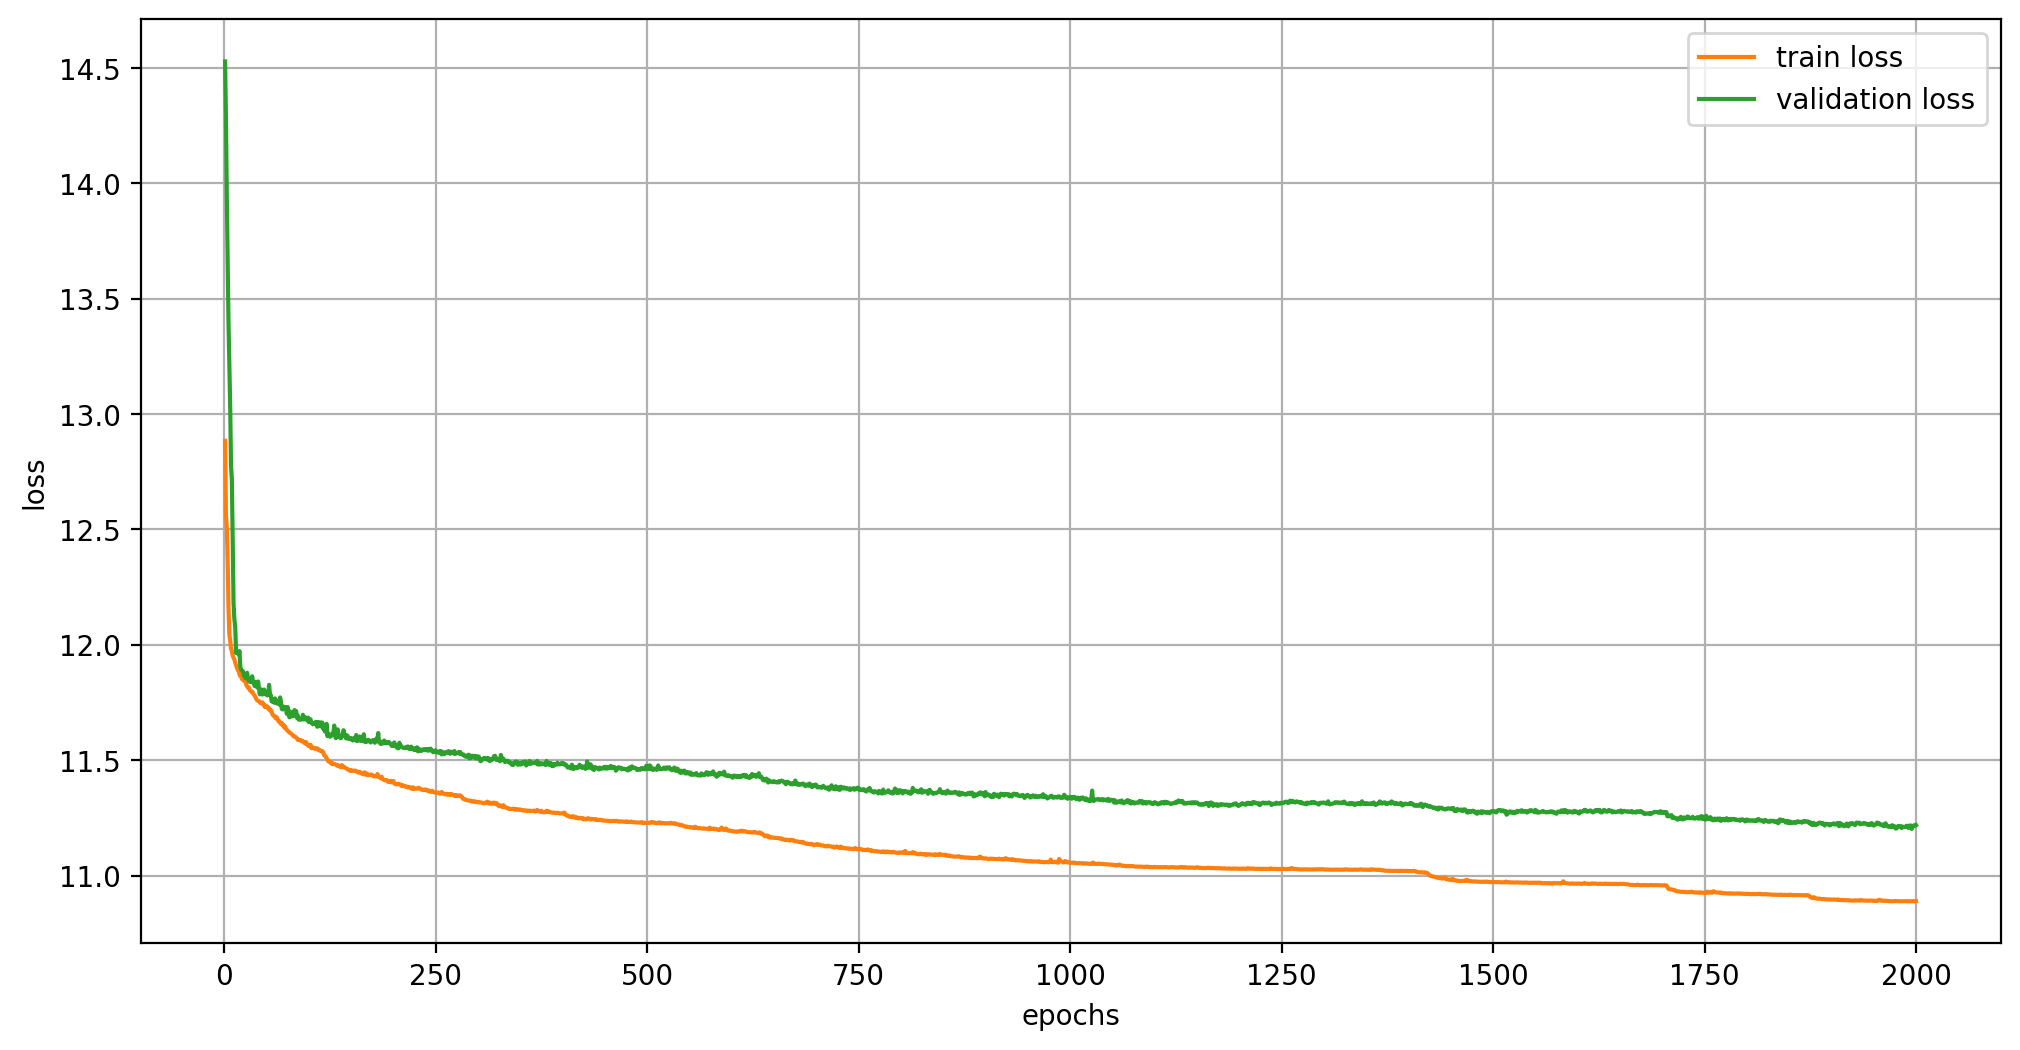

In [55]:
fig = plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, num_epochs + 1, 1), mean_batch_losses, color='tab:orange', label='train loss')
plt.plot(np.arange(1, num_epochs + 1, 1), mean_val_batch_losses, color='tab:green', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

## print weights and biases

In [57]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
LSTM_1.weight_ih_l0 	 torch.Size([1812, 423])
LSTM_1.weight_hh_l0 	 torch.Size([1812, 453])
LSTM_1.bias_ih_l0 	 torch.Size([1812])
LSTM_1.bias_hh_l0 	 torch.Size([1812])
LSTM_1.weight_ih_l1 	 torch.Size([1812, 453])
LSTM_1.weight_hh_l1 	 torch.Size([1812, 453])
LSTM_1.bias_ih_l1 	 torch.Size([1812])
LSTM_1.bias_hh_l1 	 torch.Size([1812])
LSTM_2.weight_ih_l0 	 torch.Size([1208, 453])
LSTM_2.weight_hh_l0 	 torch.Size([1208, 302])
LSTM_2.bias_ih_l0 	 torch.Size([1208])
LSTM_2.bias_hh_l0 	 torch.Size([1208])
duration_fc.0.weight 	 torch.Size([302])
duration_fc.0.bias 	 torch.Size([302])
duration_fc.0.running_mean 	 torch.Size([302])
duration_fc.0.running_var 	 torch.Size([302])
duration_fc.0.num_batches_tracked 	 torch.Size([])
duration_fc.2.weight 	 torch.Size([151, 302])
duration_fc.2.bias 	 torch.Size([151])
duration_fc.4.weight 	 torch.Size([151])
duration_fc.4.bias 	 torch.Size([151])
duration_fc.4.running_mean 	 torch.Size([151])
duration_fc.4.running_var 	 torch.

## Save/Load model state_dict

**Save:**

In [58]:
net_weights_filename = 'state_dict.pth'

savepath = Path.cwd().joinpath('nets')
net_weights_filepath = savepath.joinpath(net_weights_filename)

torch.save(net.state_dict(), net_weights_filepath)


**Load:**

In [59]:
net_loaded = Net(**best_params).to(DEVICE)
net_loaded.load_state_dict(torch.load(net_weights_filepath))
net_loaded.eval()

Net(
  (LSTM_1): LSTM(423, 453, num_layers=2, batch_first=True, dropout=0.33)
  (LSTM_2): LSTM(453, 302, batch_first=True)
  (duration_fc): Sequential(
    (0): BatchNorm1d(302, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (1): Dropout(p=0.33, inplace=False)
    (2): Linear(in_features=302, out_features=151, bias=True)
    (3): ELU(alpha=1.0)
    (4): BatchNorm1d(151, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (5): Dropout(p=0.33, inplace=False)
    (6): Linear(in_features=151, out_features=34, bias=True)
    (7): Softmax(dim=None)
  )
  (duration_accuracy): MulticlassAccuracy()
  (root_step_fc): Sequential(
    (0): BatchNorm1d(302, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (1): Dropout(p=0.33, inplace=False)
    (2): Linear(in_features=302, out_features=151, bias=True)
    (3): ELU(alpha=1.0)
    (4): BatchNorm1d(151, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (5): Dropout(p=0.33, i

# evaluation

## predict on testdata
predict output labels of test data and compare them to their true label

In [60]:
test_batchsize = len(dataset_test) // n_batches

dataloader_test = DataLoader(
    dataset_test, shuffle=False, batch_size = test_batchsize#, num_workers = 4
)

def evaluate_model(model, dataloader_test):
    # Define accuracy metrics
    #acc_root_note = Accuracy(task="multiclass", num_classes=30)
    #acc_chord_interval = Accuracy(task="multiclass", num_classes=6)

    cnf_matrices_root_pitch = []
    cnf_matrices_duration = []
    cnf_matrices_root_pitch = []
    cnf_matrices_root_step = [] 
    cnf_matrices_cardinality = []
    cnf_matrices_forteClass = []
    cnf_matrices_inversion = []


    model.eval()
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(dataloader_test):
            # Obtain model outputs
            #print(batch_idx
            if len(data['root_pitch_data']) == test_batchsize:
 
                out_root_step, out_duration, out_cardinality, out_forteClass, out_inversion = net_loaded(batch_idx, data)    
                #print(out_inversion.shape,out_inversion, out_inversion.argmax(dim=1))
                y_preds_root_step = out_root_step.argmax(dim=1).cpu()
                y_preds_duration = out_duration.argmax(dim=1).cpu()
                y_preds_cardinality = out_cardinality.argmax(dim=1).cpu()
                y_preds_forteClass = out_forteClass.argmax(dim=1).cpu()
                y_preds_inversion = out_inversion.argmax(dim=1).cpu()
                y_preds_root_pitch = shift_pitch_from_steps(data['root_pitch_data'][:, -1, :], out_root_step).argmax(dim=1).cpu()

                y_trues_root_step = label['root_step_label'].argmax(dim=1).cpu()
                y_trues_duration = label['duration_label'].argmax(dim=1).cpu()
                y_trues_cardinality = label['cardinality_label'].argmax(dim=1).cpu()
                y_trues_forteClass = label['forteClass_label'].argmax(dim=1).cpu()
                y_trues_inversion = label['inversion_label'].argmax(dim=1).cpu()
                y_trues_root_pitch = label['root_pitch_label'].argmax(dim=1).cpu()


                cnf_matrices_root_pitch.append(confusion_matrix(y_preds_root_pitch, y_trues_root_pitch, labels=list(defactorize_dict['root_pitch'].keys())))
                cnf_matrices_root_step.append(confusion_matrix(y_preds_root_step, y_trues_root_step, labels=list(defactorize_dict['root_step'].keys())))
                cnf_matrices_duration.append(confusion_matrix(y_preds_duration, y_trues_duration, labels=list(defactorize_dict['duration'].keys())))
                cnf_matrices_cardinality.append(confusion_matrix(y_preds_cardinality, y_trues_cardinality, labels=list(defactorize_dict['cardinality'].keys())))
                cnf_matrices_forteClass.append(confusion_matrix(y_preds_forteClass, y_trues_forteClass, labels=list(defactorize_dict['forteClass'].keys())))
                cnf_matrices_inversion.append(confusion_matrix(y_preds_inversion, y_trues_inversion, labels=list(defactorize_dict['inversion'].keys())))

        
        cnf_matrices_root_pitch = np.sum(cnf_matrices_root_pitch, axis=0)
        cnf_matrices_root_step = np.sum(cnf_matrices_root_step, axis=0)
        cnf_matrices_duration = np.sum(cnf_matrices_duration, axis=0)
        cnf_matrices_cardinality = np.sum(cnf_matrices_cardinality, axis=0)
        cnf_matrices_forteClass = np.sum(cnf_matrices_forteClass, axis=0)
        cnf_matrices_inversion = np.sum(cnf_matrices_inversion, axis=0)
        
        return cnf_matrices_duration, cnf_matrices_root_pitch, cnf_matrices_root_step , cnf_matrices_cardinality, cnf_matrices_forteClass, cnf_matrices_inversion

cnf_matrices = evaluate_model(net, dataloader_test)

## evaluate

**plot confusion matrices**
<br>
evaluate the trained model predicted output labels against the true labels in confusion matrices. Perfect classification would result in a diagonal line

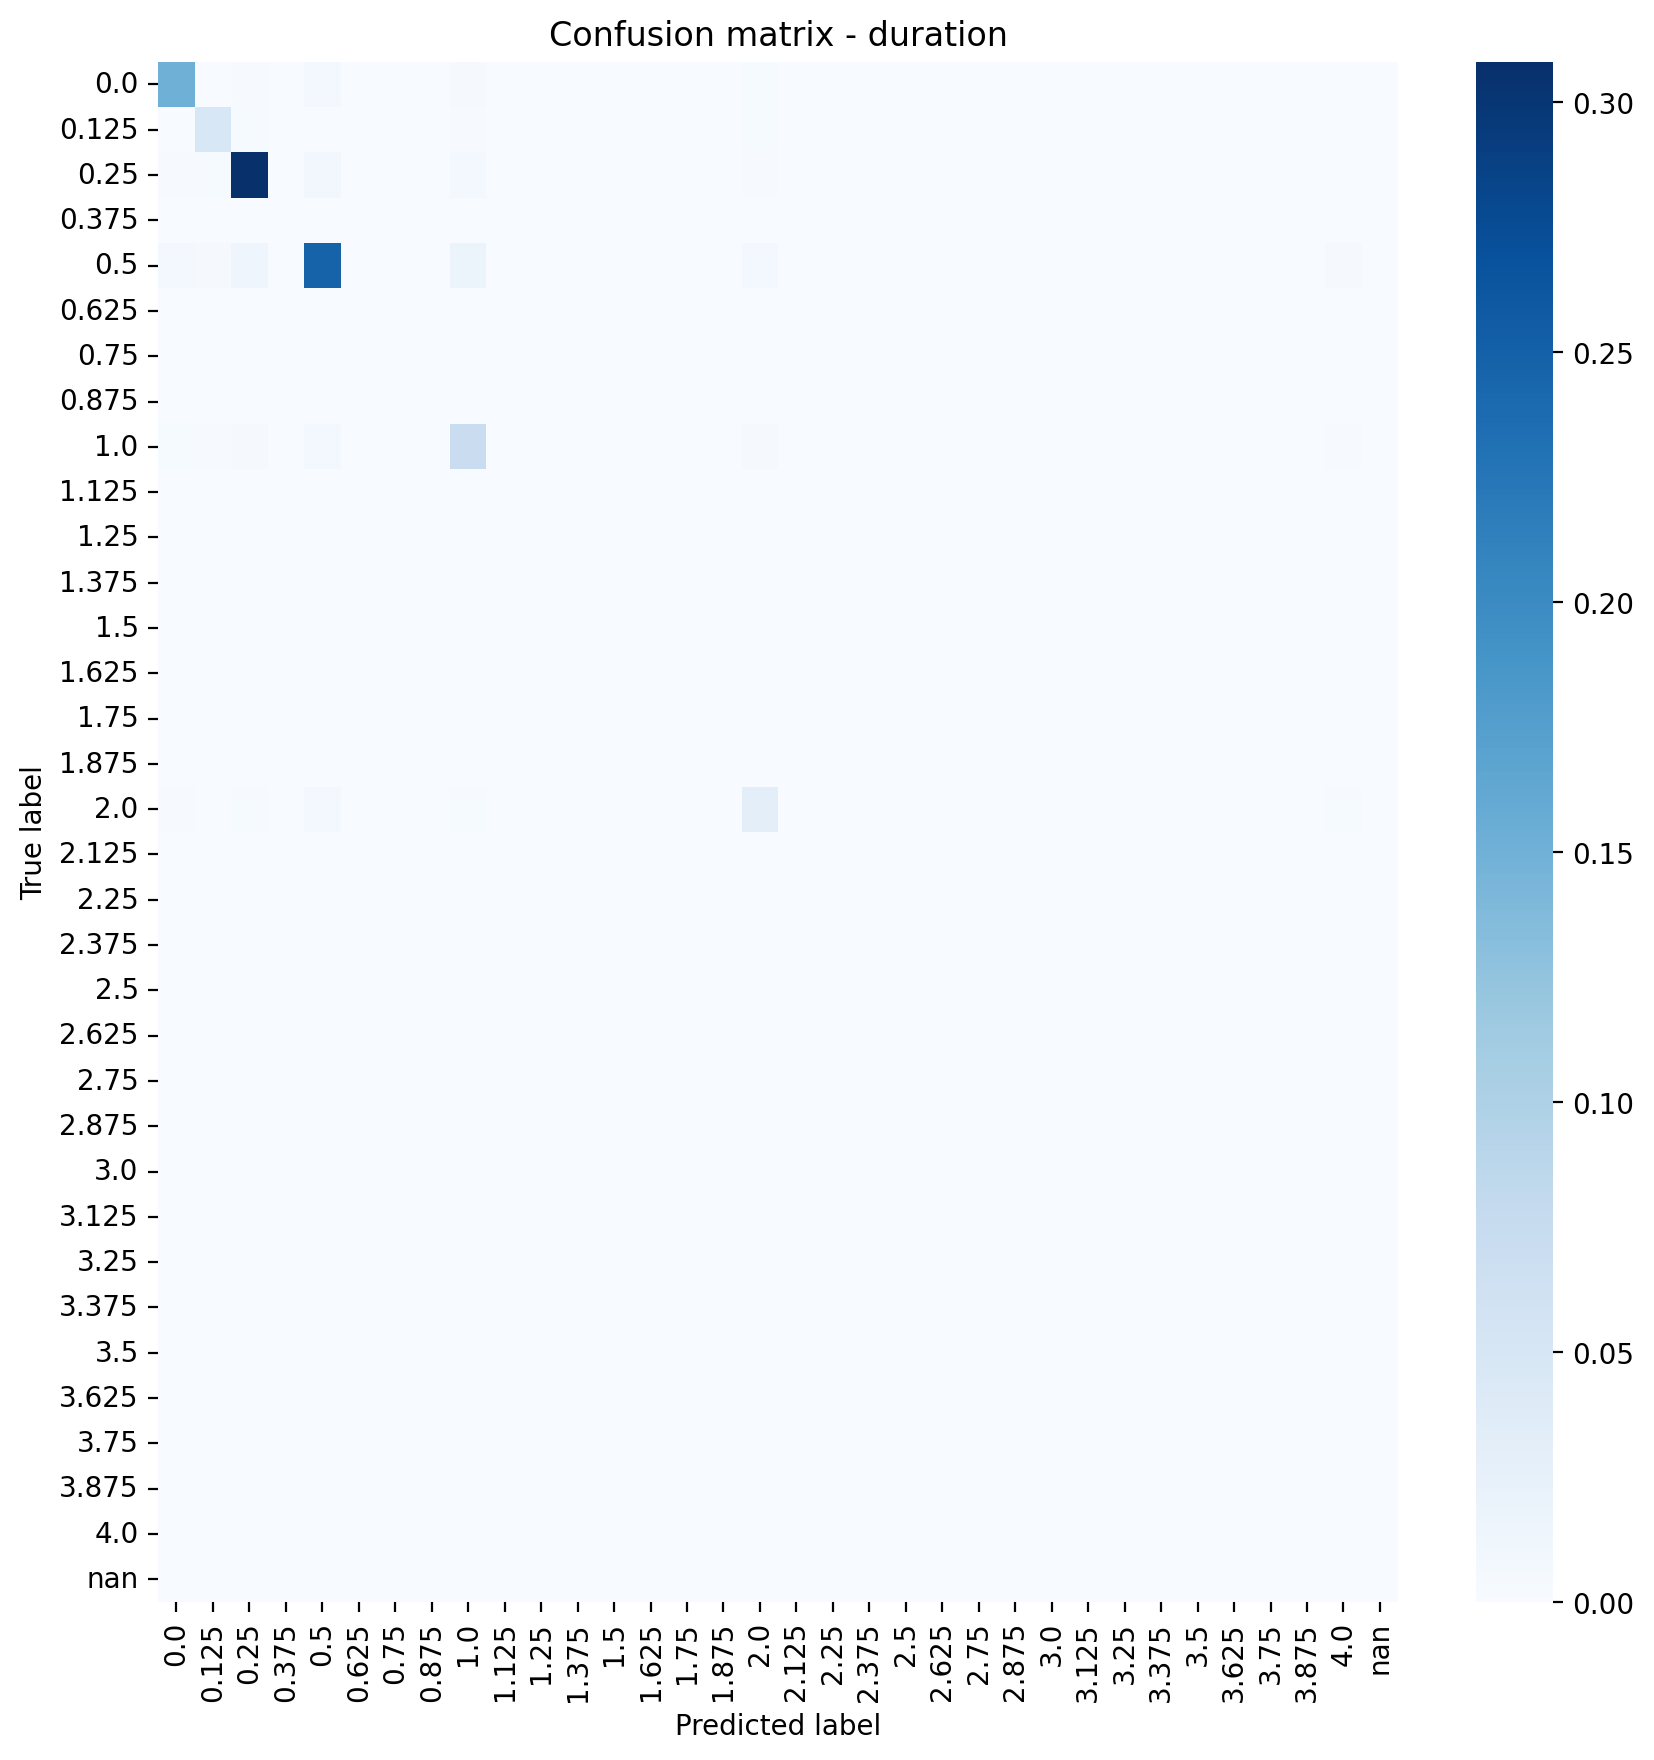

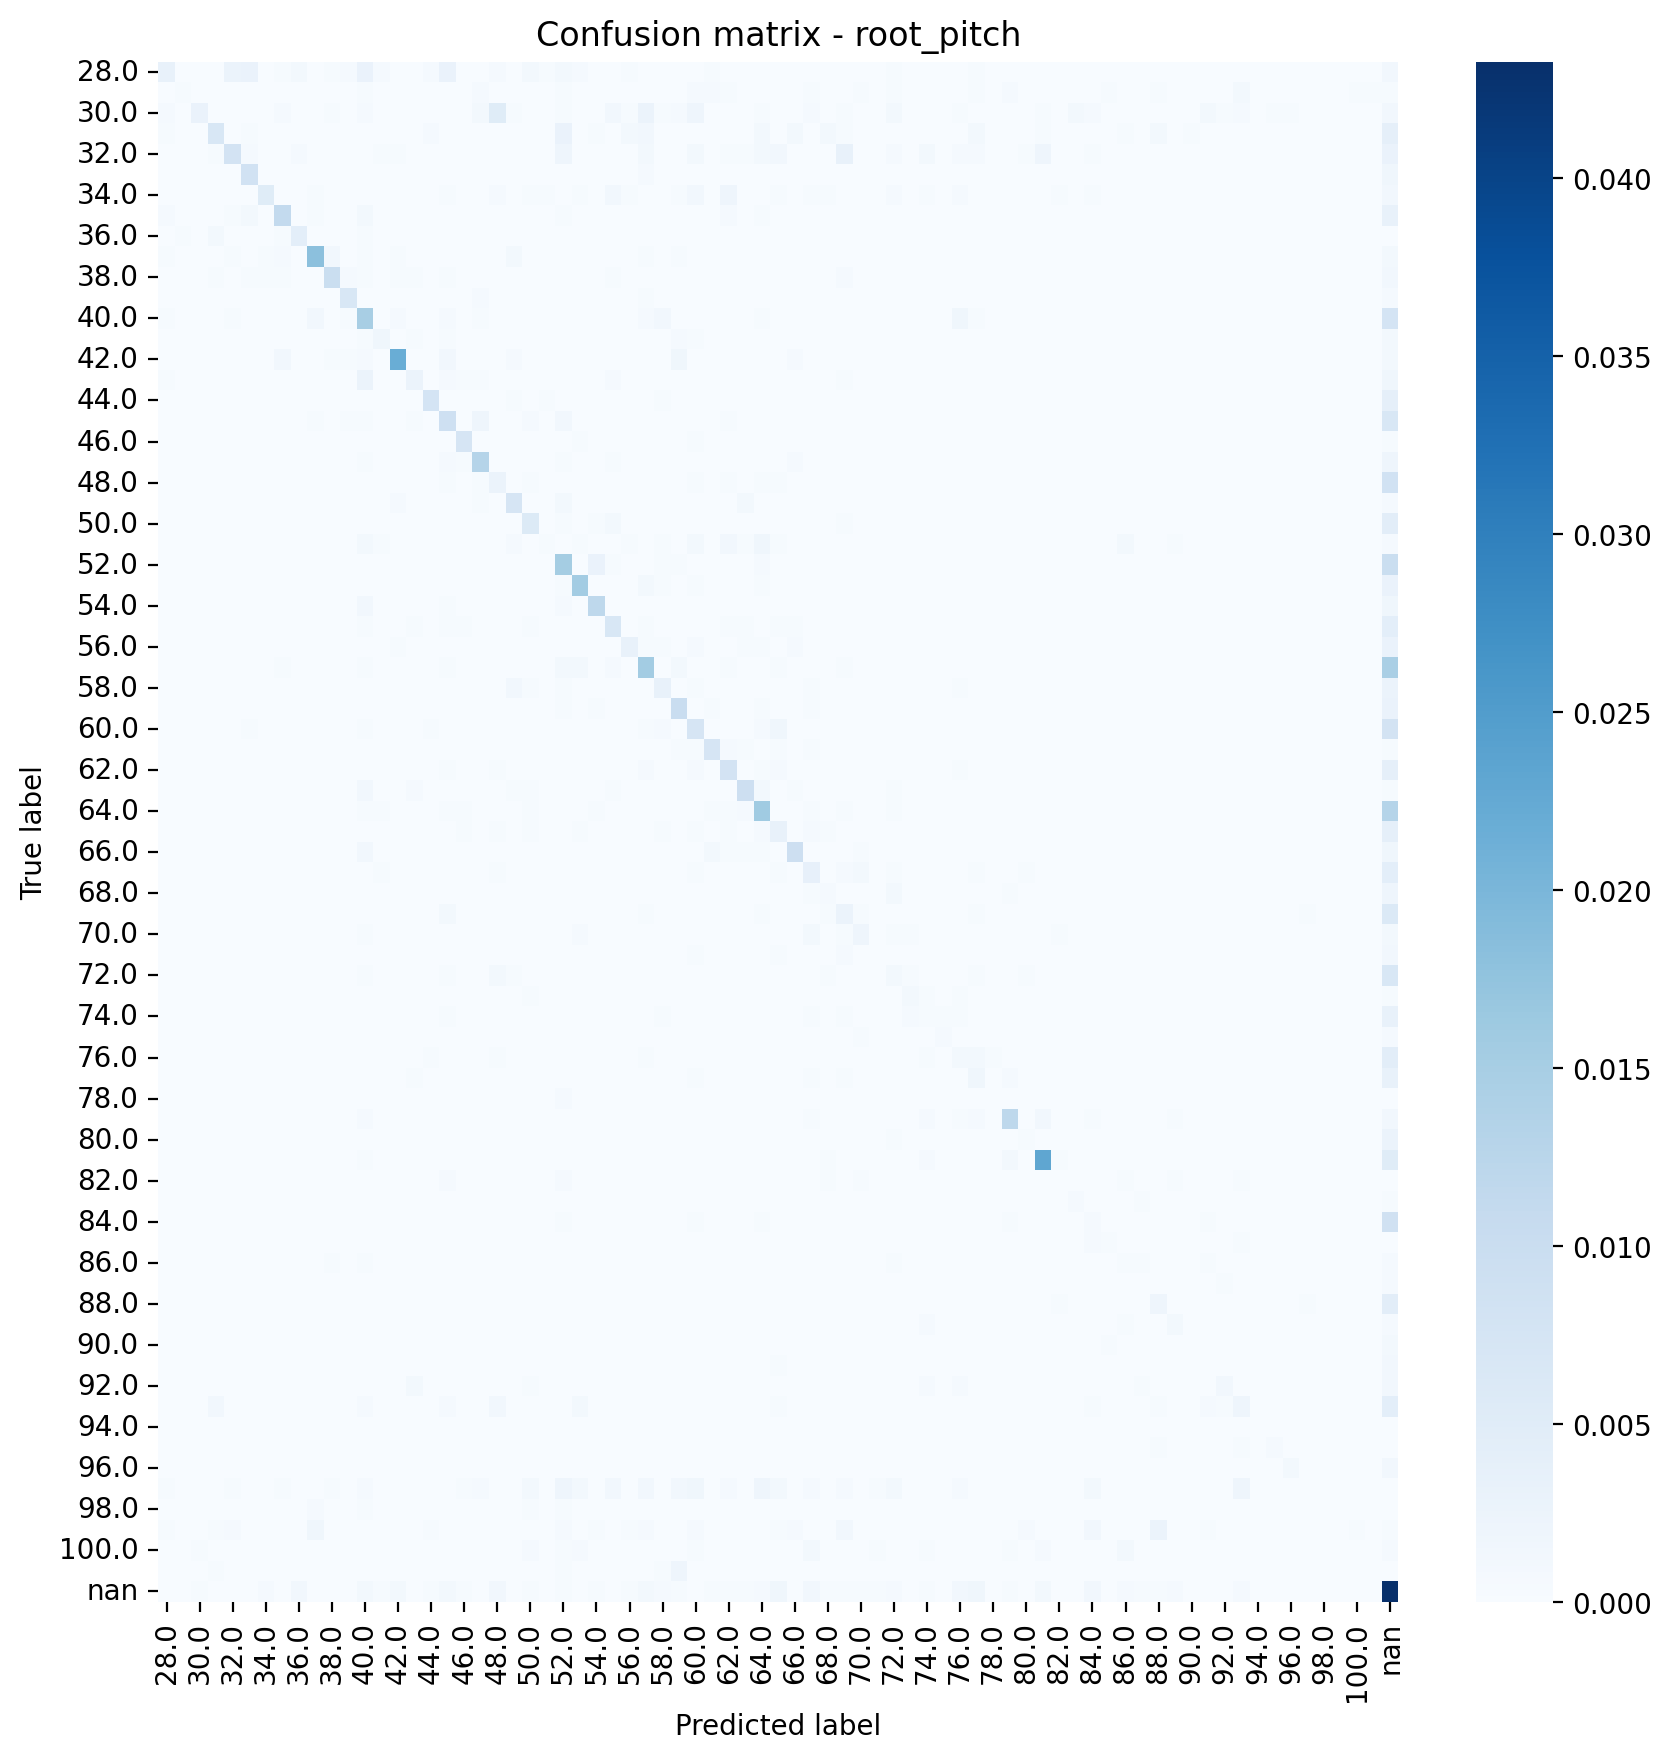

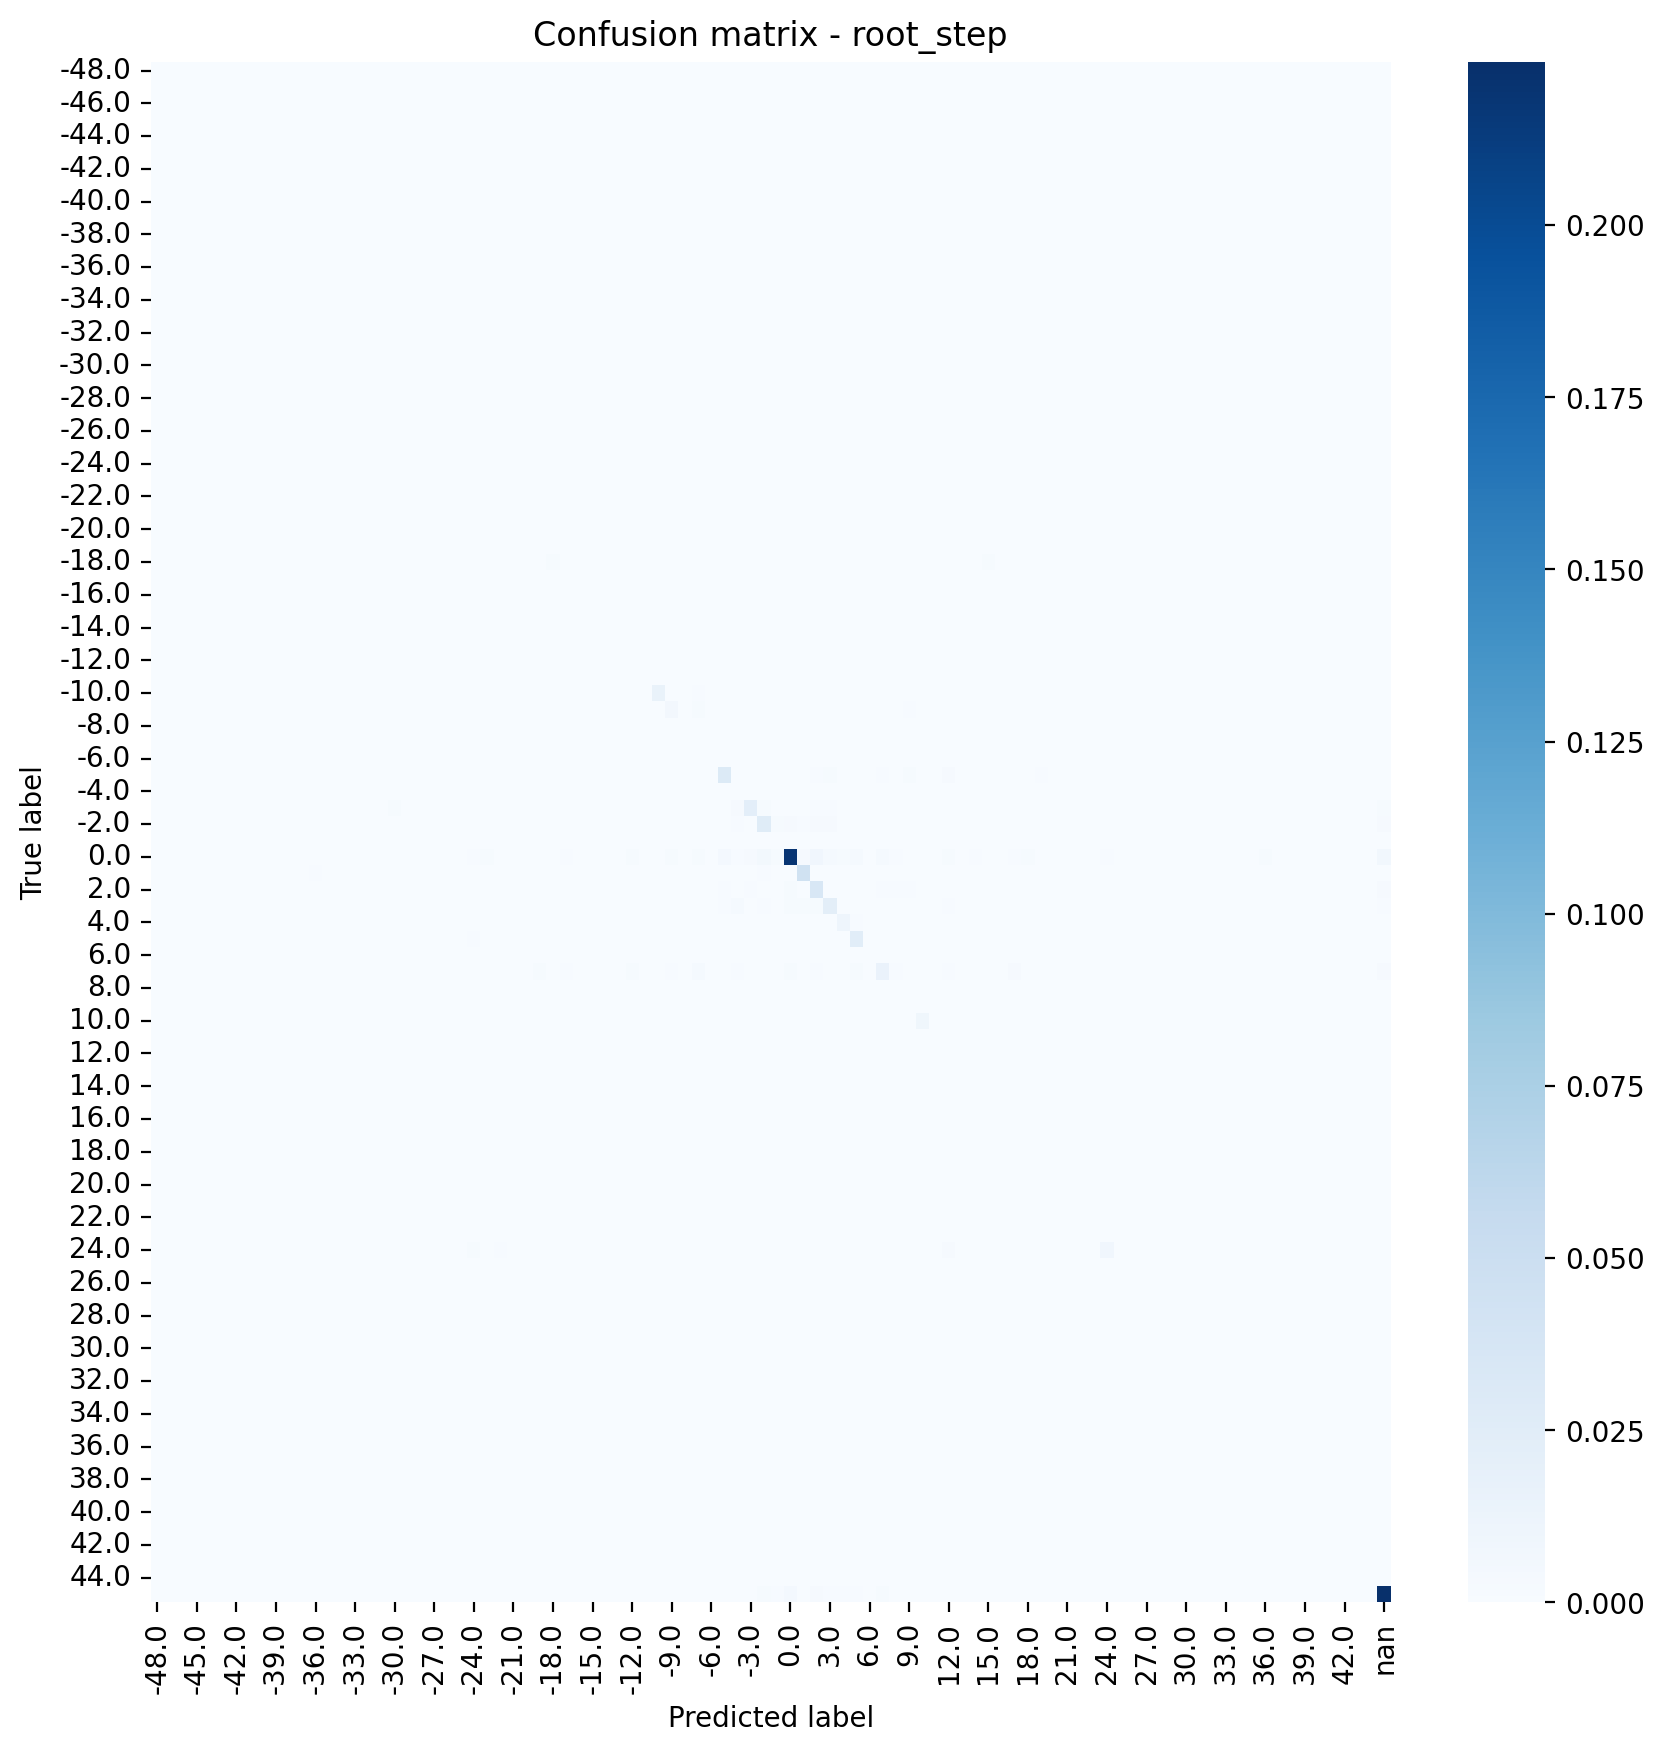

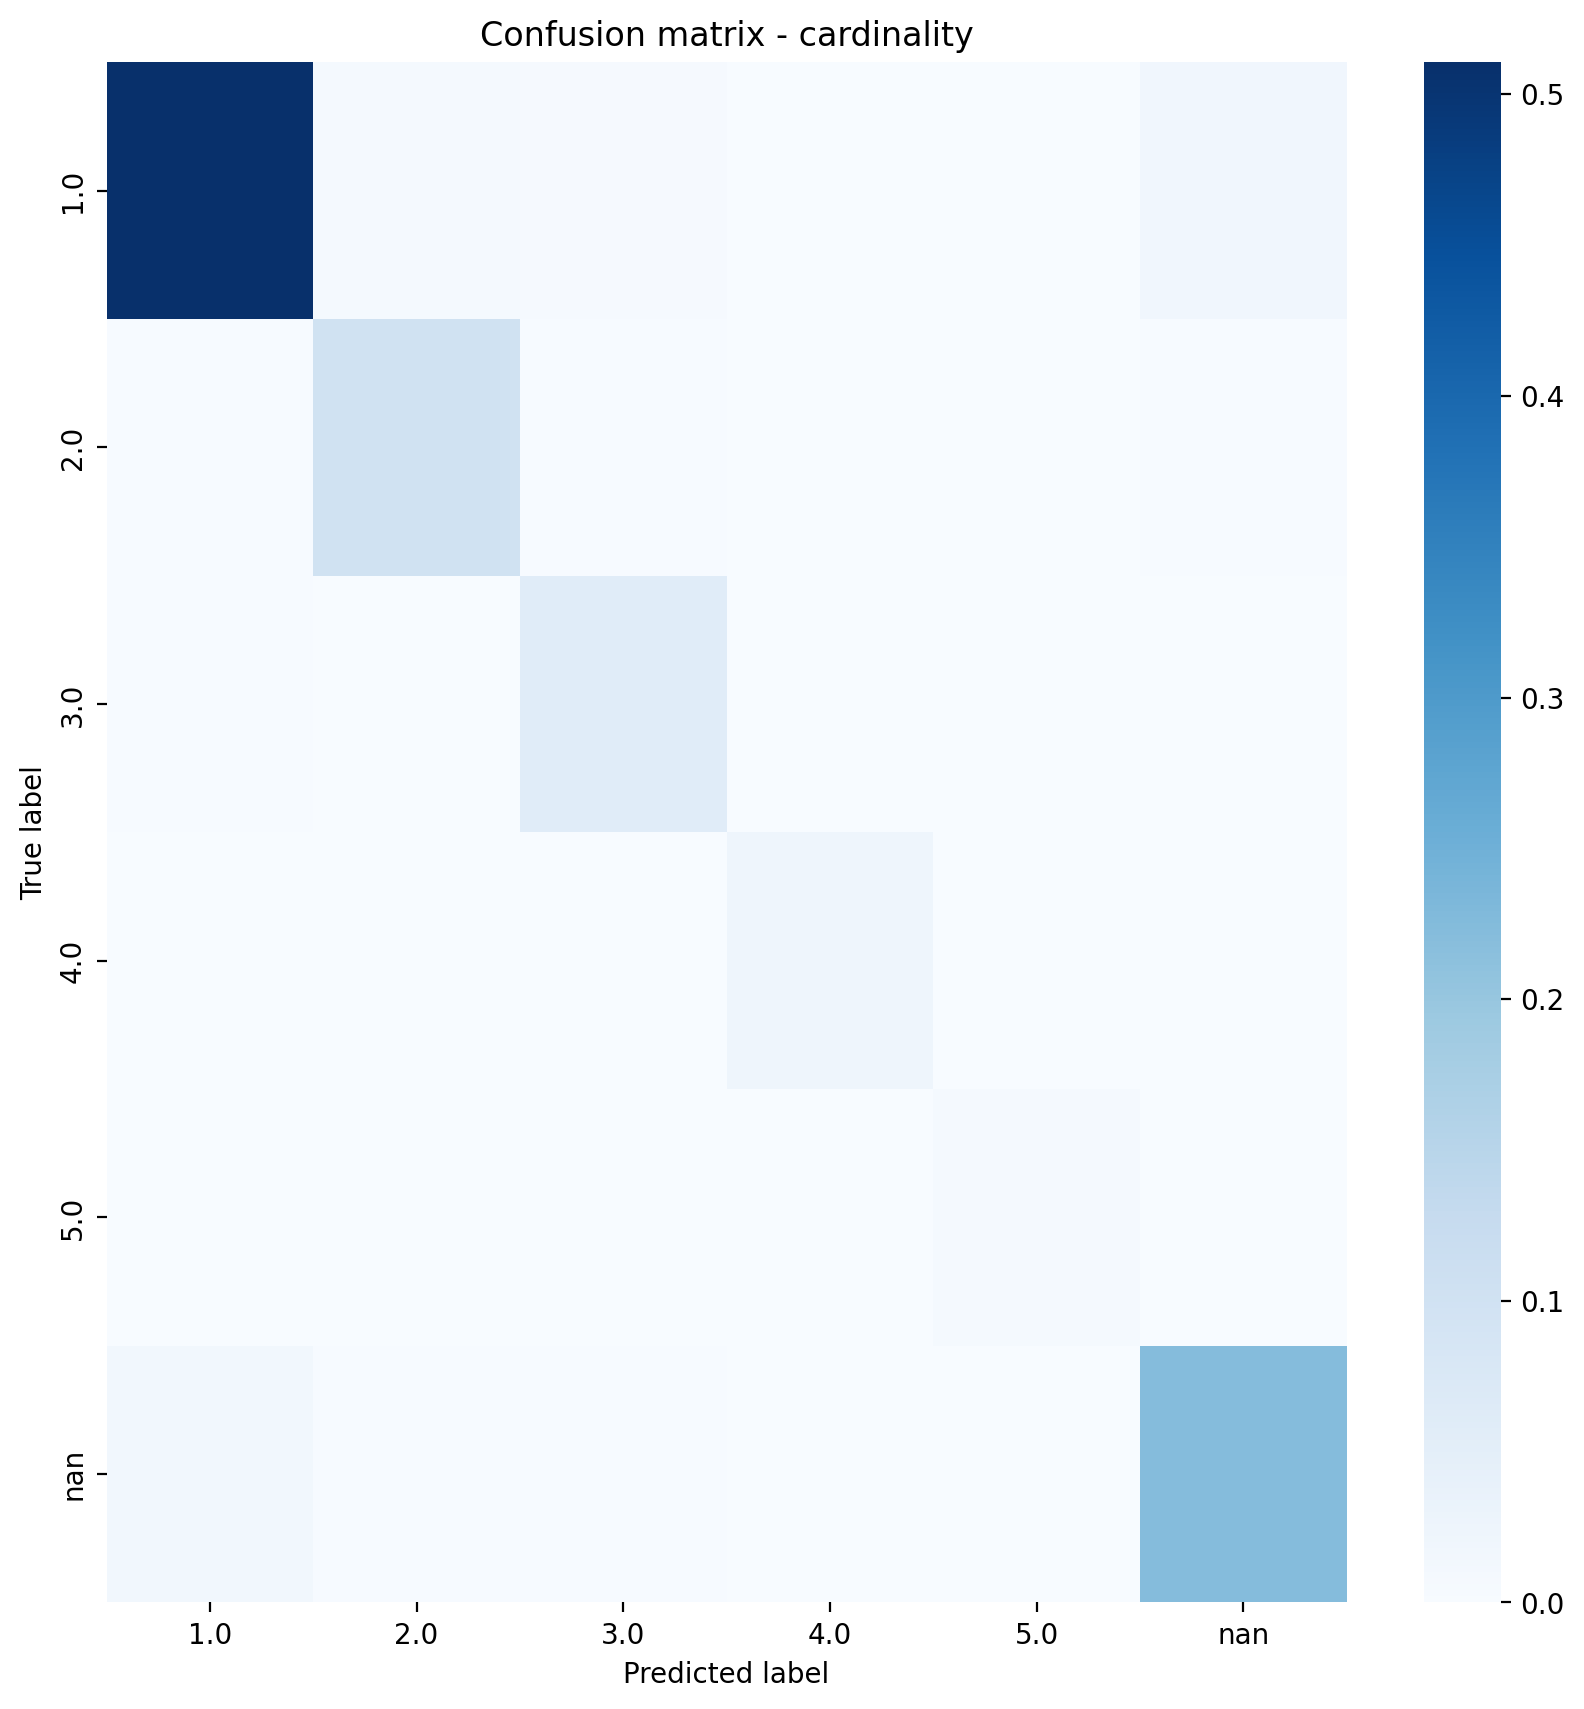

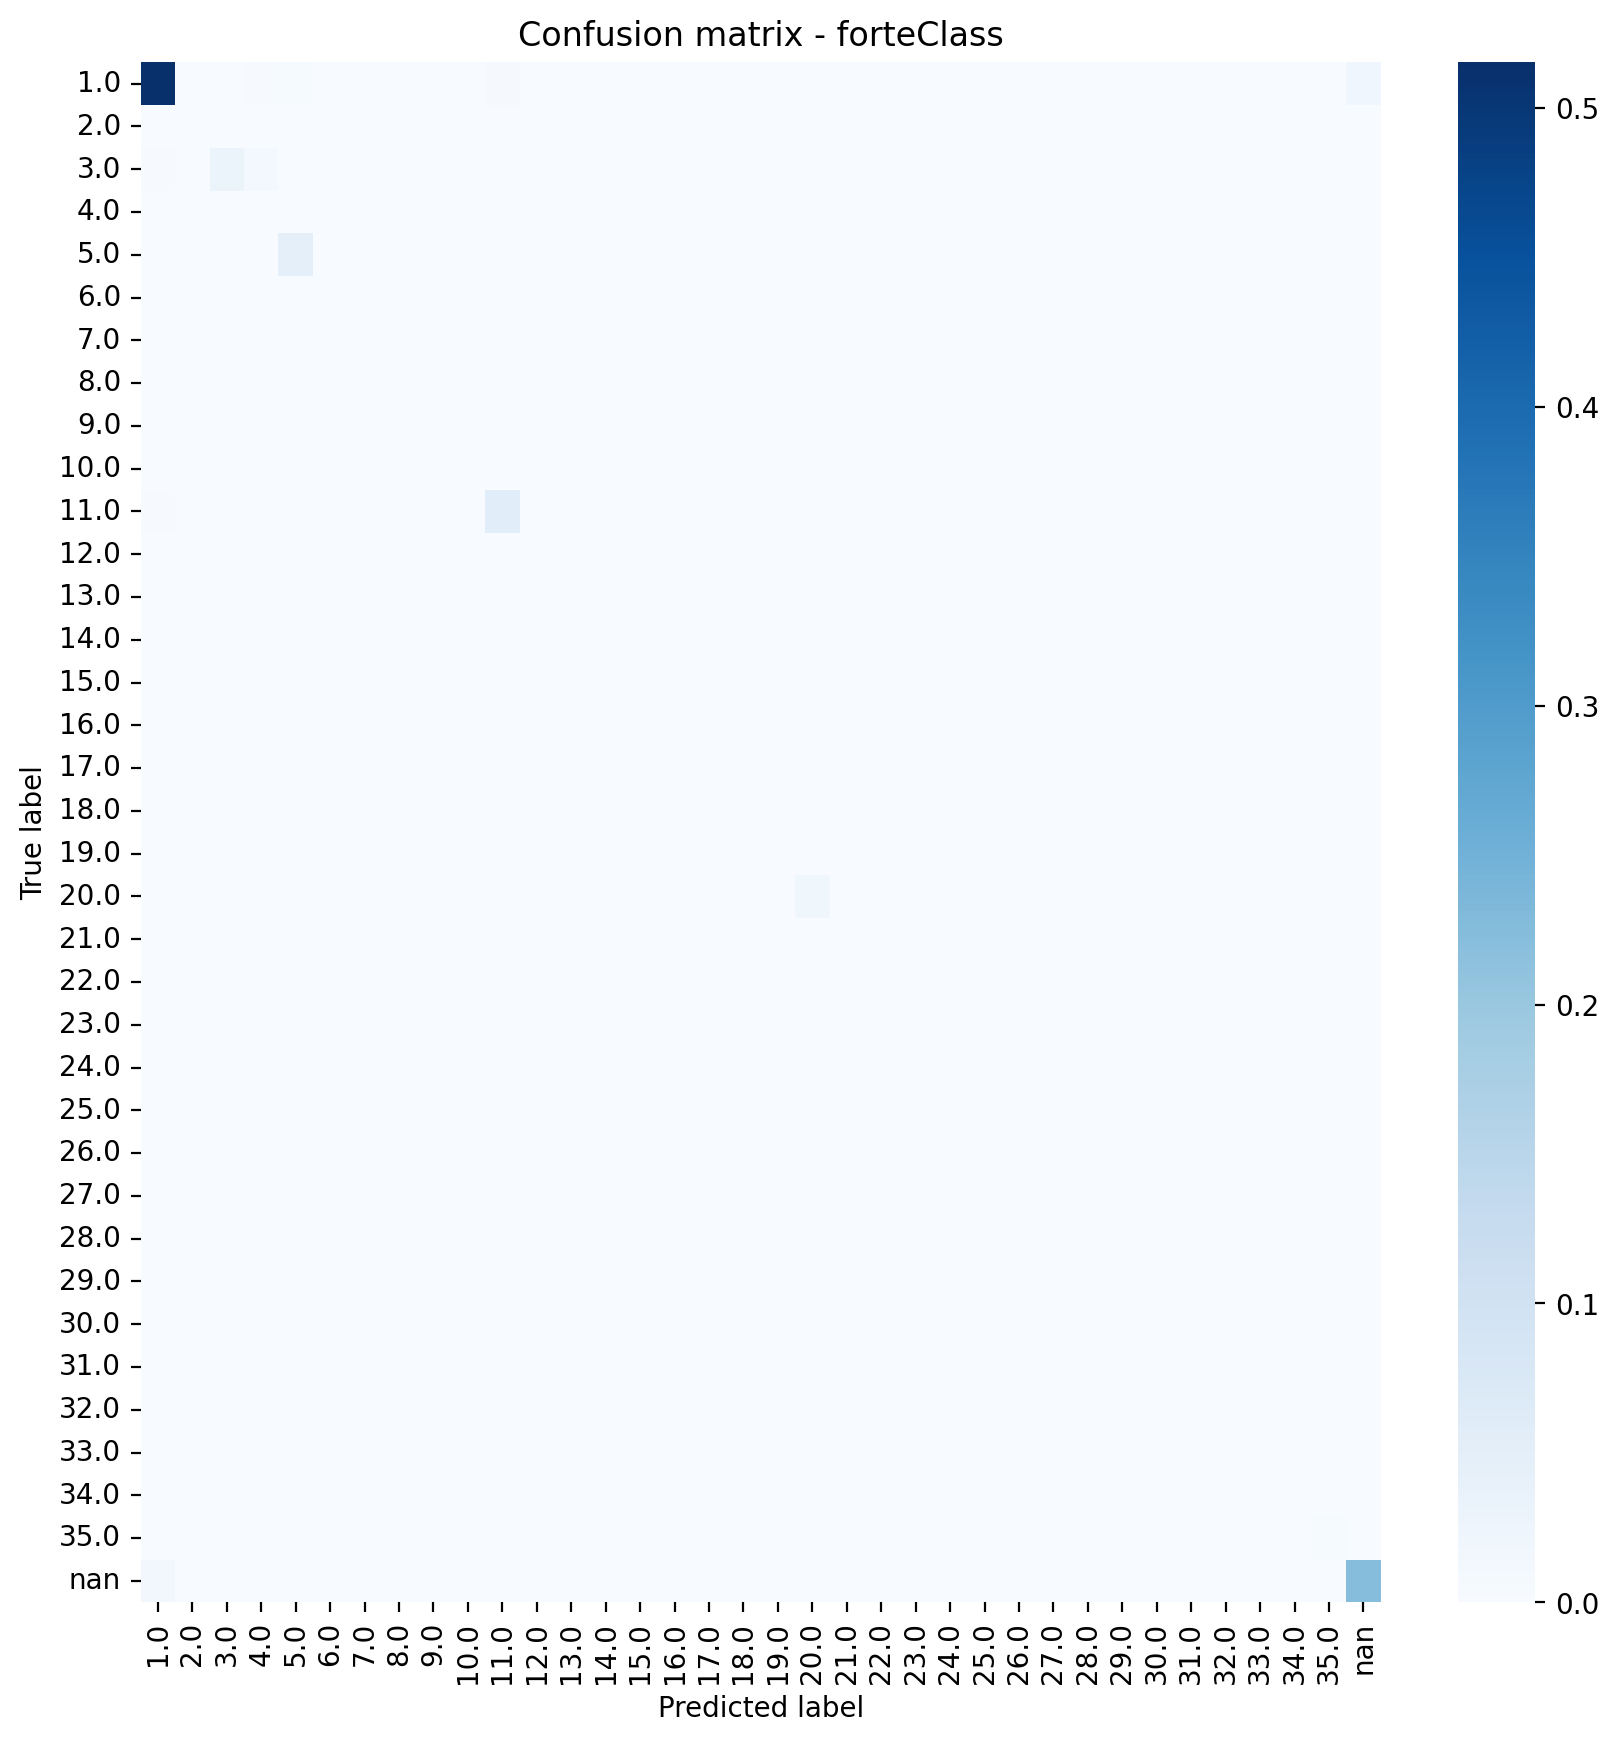

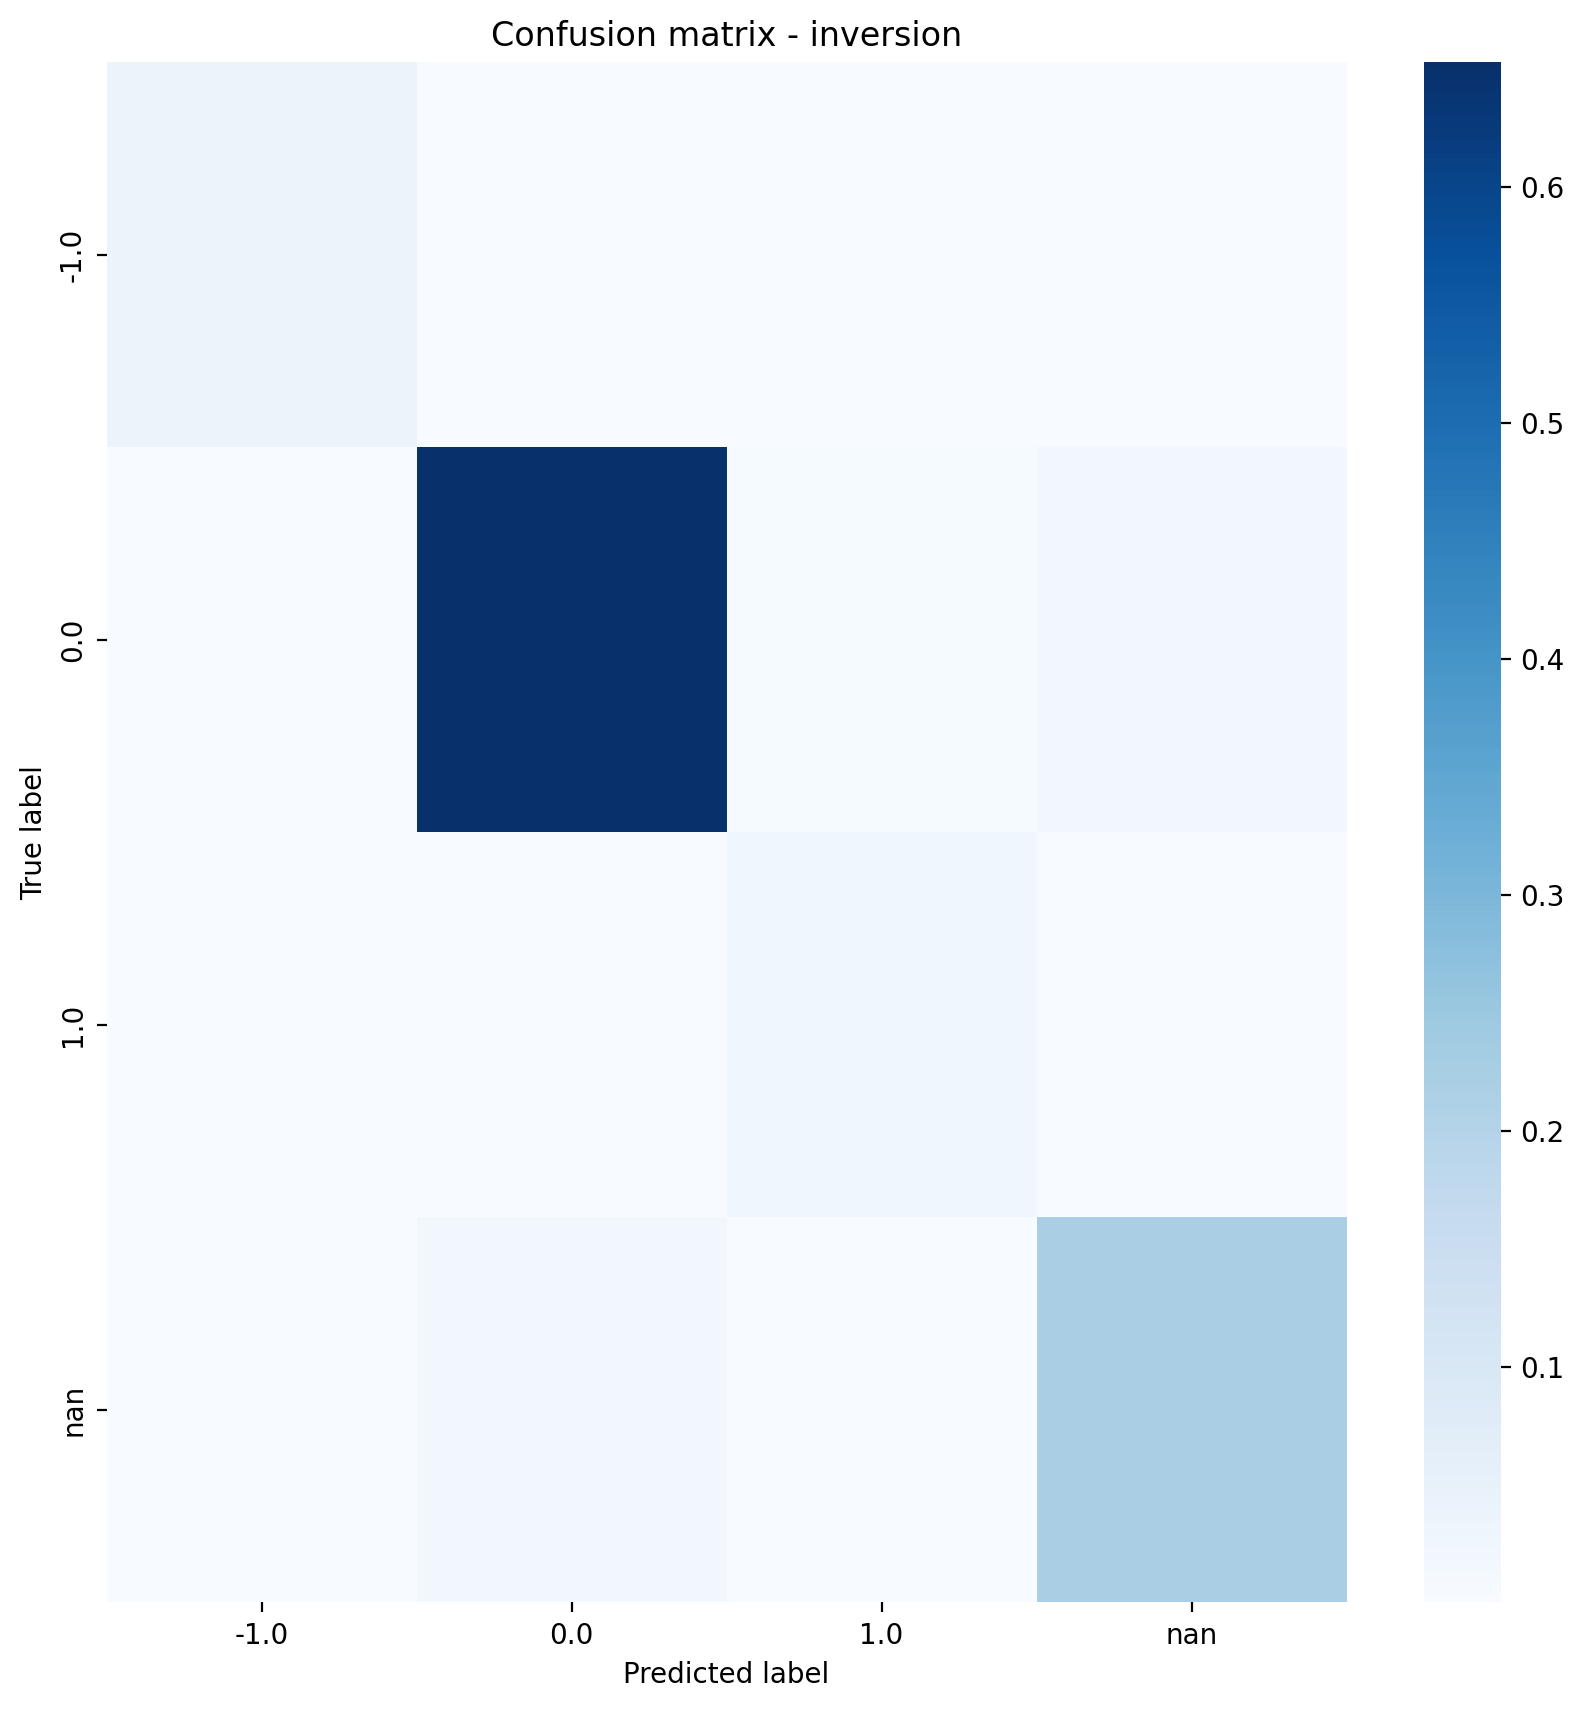

In [61]:
for cnf_matrix, target in zip(cnf_matrices, ['duration', 'root_pitch', 'root_step', 'cardinality', 'forteClass', 'inversion']):

    value_dict = defactorize_dict[target]

    def format_fn(tick_val, tick_pos):
        if int(tick_val) in range(len(value_dict)):
            return value_dict[int(tick_val)]
        else:
            return ''

    plt.figure(figsize=(10, 10))
    
        
    heatmap = sns.heatmap(cnf_matrix/np.sum(cnf_matrix), annot=False, fmt='.2%', cmap='Blues')
    heatmap.set_title(f'Confusion matrix - {target}')
    heatmap.set_ylabel(f'True label')
    heatmap.yaxis.set_major_formatter(format_fn)
    heatmap.set_xlabel(f'Predicted label')
    heatmap.xaxis.set_major_formatter(format_fn)
    if cnf_matrix.shape[0] > 10:
        heatmap.tick_params(axis='x', rotation=90)
        heatmap.tick_params(axis='y', rotation=0)
    plt.show()

**print predicted output samples**
<br>
feed the model with some test data and print the predicted human readable outputs

# create a sequence with predicted MIDI data

**prepare initial sequence**
<br>
create initial empty sequence of lenght ´seq_len` with last note/chord information being user chosen

In [322]:
seq_len = int(input('Enter the sequence lenght: ').strip() or '8')
start_pitch = int(input('Enter the starting pitch: ').strip() or '69')
start_duration = float(input('Enter the starting duration as fraction: ').strip() or '0.5')

note_pitches = [start_pitch]

start_chord = chord.Chord([start_pitch], duration=duration.Duration(start_duration))

(cardinality, forteClass, inversion, pcOriginal) = start_chord.chordTablesAddress


predict_start_data = {
        'note_pitches' : [np.nan if x <= seq_len - 2 else note_pitches for x in range(seq_len + 1)],
        'duration' : [0.25 if x <= seq_len - 2 else start_duration for x in range(seq_len + 1)],
        'duration_step' : [0. if x <= seq_len - 2 else start_duration - 0.25 for x in range(seq_len + 1)],
        'root_pitch': [np.nan if x <= seq_len - 2 else start_pitch for x in range(seq_len + 1)],
        'root_step': [np.nan if x <= seq_len - 2 else 0. for x in range(seq_len + 1)],

        'cardinality': [np.nan if x <= seq_len - 2 else cardinality for x in range(seq_len + 1)],
        'cardinality_step': [np.nan if x <= seq_len - 2 else 0 for x in range(seq_len + 1)],
        'forteClass': [np.nan if x <= seq_len - 2 else forteClass for x in range(seq_len + 1)],
        'forteClass_step': [np.nan if x <= seq_len - 2 else 0 for x in range(seq_len + 1)],
        'inversion': [np.nan if x <= seq_len - 2 else inversion for x in range(seq_len + 1)],
        'inversion_step': [np.nan if x <= seq_len - 2 else 0 for x in range(seq_len + 1)],
        'pcOriginal': [np.nan if x <= seq_len - 2 else pcOriginal for x in range(seq_len + 1)],
        'pcOriginal_step': [np.nan if x <= seq_len - 2 else 0 for x in range(seq_len + 1)]
}

df_predict_initial = pd.DataFrame(data = predict_start_data, index=list(range(seq_len + 1)))


Enter the sequence lenght:  10
Enter the starting pitch:  77
Enter the starting duration as fraction:  0.125


**predict further outputs**
<br>
predict one output at a time using all previous outputs as sequenced information

In [323]:
prediction_sequence_len = 1000
print(f'predicting MIDI sequence of lenght: {prediction_sequence_len}')


df_predict = df_predict_initial.copy()
#df_predicted = pd.DataFrame(columns=df_predict_initial.columns, index=[0])

net.eval()
with torch.no_grad():
    with tqdm(range(prediction_sequence_len), unit="sequence") as tsequence:
        tsequence.set_description(f"predict sequence")
        for predict_epoch in tsequence:
            #print(predict_epoch)
            df_predicted = df_predict.iloc[-(seq_len + 1): ].reset_index(drop=True)
    
            note_pitches = []
            
            X_predict_train, _, __, defactorize_dict_predict  = create_ohe_sequences(df_predicted, seq_len, list(range(len(df_predict.columns)))[1:], mi, ma, ste, 0)
    
            #print('X_predict_ root_step:', X_predict_train["root_step"],'X_predict_ root_pitch:', X_predict_train["root_pitch"])
            
            #if predict_epoch == 0:
            df_predict = df_predict.drop(df_predict.index[-1], axis = 0)
                
            
           
            dataloader_predict_train = DataLoader(
                MidiDataset(X_predict_train, _), shuffle=False, batch_size = 1
            )
            
            for batch_idx, (data, label) in enumerate(dataloader_predict_train):
    
                #for key, val in data.items():
                #    print(key, val.shape)
                
                out_root_step, out_duration, out_cardinality, out_forteClass, out_inversion = net(batch_idx, data)    
        
                y_preds_root_step = defactorize_dict["root_step"][out_root_step.argmax(dim=1).item()]
                y_preds_duration = defactorize_dict["duration"][out_duration.argmax(dim=1).item()]
                y_preds_cardinality = defactorize_dict["cardinality"][out_cardinality.argmax(dim=1).item()]
                y_preds_forteClass = defactorize_dict["forteClass"][out_forteClass.argmax(dim=1).item()]
                y_preds_inversion = defactorize_dict["inversion"][out_inversion.argmax(dim=1).item()]
    
                #print(out_root_step.round(), y_preds_root_step)
                
                y_preds_root_pitch = defactorize_dict["root_pitch"][shift_pitch_from_steps(data['root_pitch_data'][:, -1, :], out_root_step).argmax(dim=1).item()]
            '''
            print( f'round {predict_epoch + 1}:')
            print( f'root_pitch: {y_preds_root_pitch}')
            print( f'root_step: {y_preds_root_step}')
            print( f'duration: {y_preds_duration}')
            print( f'cardinality: {y_preds_cardinality}')
            print( f'forteClass: {y_preds_forteClass}')
            print( f'inversion: {y_preds_inversion}')
            print()
            '''
            try:
                assert y_preds_root_step**y_preds_root_step > 0
                
                chord_vec = chord.tables.addressToIntervalVector((int(y_preds_cardinality), int(y_preds_forteClass), int(y_preds_inversion)))
                predict_chord = chord.fromIntervalVector(chord_vec)
                
                predict_chord.root().ps = y_preds_root_pitch
                predict_chord.duration = duration.Duration(y_preds_duration)
    
                note_pitches.append(np.array([p.ps for p in predict_chord.pitches]))
    
                (cardinality, forteClass, inversion, pcOriginal) = predict_chord.chordTablesAddress
    
                predict_data = {
                    'note_pitches' : note_pitches,
                    'duration' : y_preds_duration,
                    'duration_step' : y_preds_duration - df_predict['duration'].iloc[-1],
                    'root_pitch': y_preds_root_pitch,
                    'root_step': y_preds_root_step,
                    'cardinality': y_preds_cardinality,
                    'cardinality_step': y_preds_cardinality - df_predict['cardinality'].iloc[-1],
                    'forteClass': y_preds_forteClass,
                    'forteClass_step': y_preds_forteClass - df_predict['forteClass'].iloc[-1],
                    'inversion': y_preds_inversion,
                    'inversion_step': y_preds_inversion - df_predict['inversion'].iloc[-1],
                    'pcOriginal': pcOriginal,
                    'pcOriginal_step': pcOriginal - df_predict['pcOriginal'].iloc[-1]
                }
            except Exception:
                predict_data = {
                    'note_pitches' : [np.nan],
                    'duration' : y_preds_duration,
                    'duration_step' : y_preds_duration - df_predict['duration'].iloc[-1],
                    'root_pitch': np.nan,
                    'root_step': np.nan,
                    'cardinality': np.nan,
                    'cardinality_step': np.nan,
                    'forteClass': np.nan,
                    'forteClass_step': np.nan,
                    'inversion': np.nan,
                    'inversion_step': np.nan,
                    'pcOriginal': np.nan,
                    'pcOriginal_step': np.nan
                }
        ##########################################################################
            
            
            
            df_predict_data = pd.DataFrame(predict_data, index=[0])
    
           #print('df_predict_data:\n',df_predict_data)
            
            df_predict = pd.concat([df_predict, df_predict_data, df_predict_data], ignore_index=True)
            tsequence_d = {'last predicted pitch': f'{y_preds_root_pitch:.1f}',
                            'last predicted duration': f'{y_preds_duration:.3f}'
                             }
            tsequence.set_postfix(tsequence_d) 
        
## drop nan at the beginning      
df_predict = df_predict.drop(list(range(6)), axis = 0)


df_predict

predicting MIDI sequence of lenght: 1000


predict sequence: 100%|███████| 1000/1000 [00:49<00:00, 20.31sequence/s, predicted pitch=nan, predicted duration=1.000]


note_pitches  duration  duration_step  root_pitch  root_step  \
6             NaN     0.250          0.000         NaN        NaN   
7             NaN     0.250          0.000         NaN        NaN   
8             NaN     0.250          0.000         NaN        NaN   
9            [77]     0.125         -0.125        77.0        0.0   
10         [80.0]     2.000          1.875        80.0        3.0   
...           ...       ...            ...         ...        ...   
1006          NaN     1.000          0.000         NaN        NaN   
1007          NaN     1.000          0.000         NaN        NaN   
1008          NaN     1.000          0.000         NaN        NaN   
1009          NaN     1.000          0.000         NaN        NaN   
1010          NaN     1.000          0.000         NaN        NaN   

      cardinality  cardinality_step  forteClass  forteClass_step  inversion  \
6             NaN               NaN         NaN              NaN        NaN   
7             NaN               NaN         NaN              NaN        NaN   
8             NaN               NaN         NaN              NaN        NaN   
9             1.0               0.0         1.0              0.0        0.0   
10            1.0               0.0         1.0              0.0        0.0   
...           ...               ...         ...              ...        ...   
1006          NaN               NaN         NaN              NaN        NaN   
1007          NaN               NaN         NaN              NaN        NaN   
1008          NaN               NaN         NaN              NaN        NaN   
1009          NaN               NaN         NaN              NaN        NaN   
1010          NaN               NaN         NaN              NaN        NaN   

      inversion_step  pcOriginal  pcOriginal_step  
6                NaN         NaN              NaN  
7                NaN         NaN              NaN  
8                NaN         NaN              NaN  
9                0.0         5.0              0.0  
10               0.0         8.0              3.0  
...              ...         ...              ...  
1006             NaN         NaN              NaN  
1007             NaN         NaN              NaN  
1008             NaN         NaN              NaN  
1009             NaN         NaN              NaN  
1010             NaN         NaN              NaN  

[1005 rows x 13 columns]

In [324]:
df_predict.describe()

duration  duration_step  root_pitch  root_step  cardinality  \
count  1005.000000    1005.000000   61.000000  61.000000         61.0   
mean      0.983209       0.000746   46.836066   5.918033          1.0   
std       0.179176       0.196218   17.132017   6.778139          0.0   
min       0.000000      -2.000000   29.000000 -10.000000          1.0   
25%       1.000000       0.000000   34.000000   2.000000          1.0   
50%       1.000000       0.000000   41.000000   5.000000          1.0   
75%       1.000000       0.000000   53.000000   7.000000          1.0   
max       2.000000       2.000000   95.000000  24.000000          1.0   

       cardinality_step  forteClass  forteClass_step  inversion  \
count              45.0        61.0             45.0       61.0   
mean                0.0         1.0              0.0        0.0   
std                 0.0         0.0              0.0        0.0   
min                 0.0         1.0              0.0        0.0   
25%                 0.0         1.0              0.0        0.0   
50%                 0.0         1.0              0.0        0.0   
75%                 0.0         1.0              0.0        0.0   
max                 0.0         1.0              0.0        0.0   

       inversion_step  pcOriginal  pcOriginal_step  
count            45.0   61.000000        45.000000  
mean              0.0    5.721311        -0.444444  
std               0.0    2.967216         4.444381  
min               0.0    0.000000       -10.000000  
25%               0.0    3.000000        -5.000000  
50%               0.0    5.000000         0.000000  
75%               0.0    8.000000         2.000000  
max               0.0   11.000000         7.000000

# plot piano roll of predicted MIDI sequence

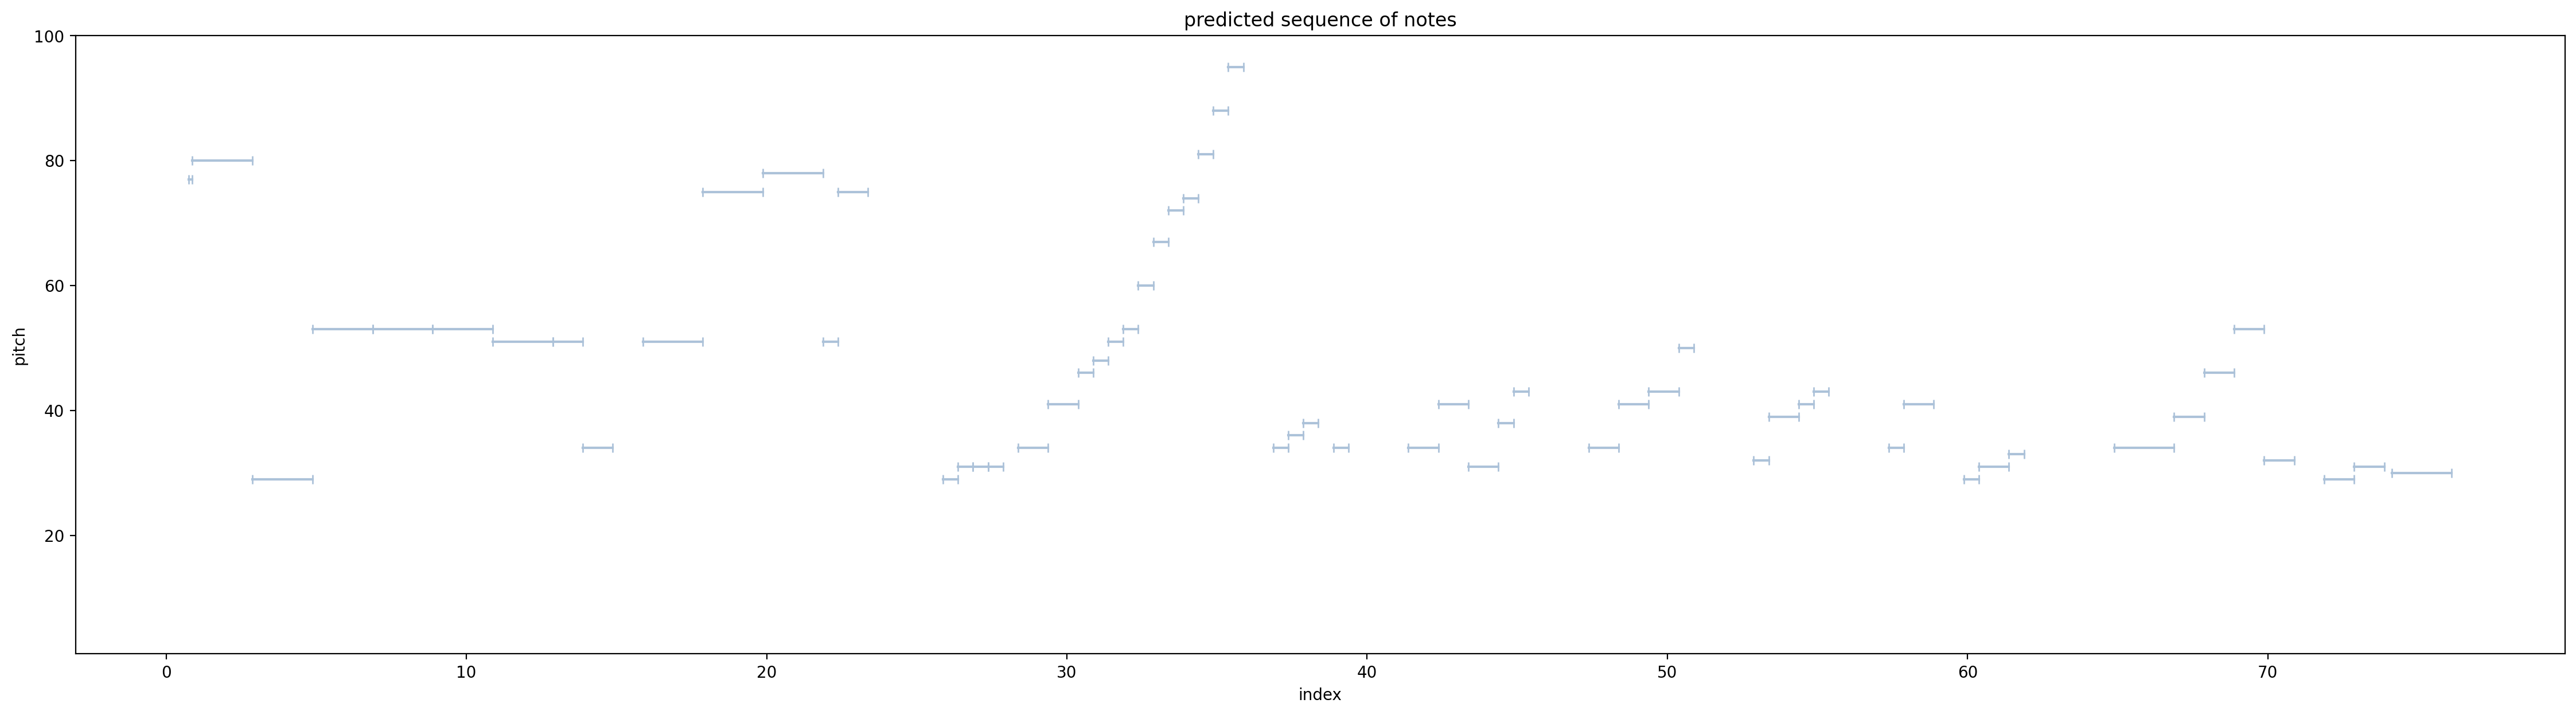

In [325]:
df_predict.name = 'predicted sequence of notes'
plot_piano_roll([df_predict])

<hr style="border: solid 3px blue;">

# convert MIDI sequence to file

In [331]:
ts = datetime.now().strftime("%m%d%Y_%H%M%S")

midi_filename = f'output_{ts}.mid'
midi_savepath = Path.cwd().joinpath('outputs')
midi_filepath = midi_savepath.joinpath(midi_filename)

midi_stream = stream.Stream()

midi_columns = ['note_pitches', 'duration']


print(f'output file: {midi_filepath}')

for (note_pitches, dura) in df_predict[midi_columns].values:
    chord_notes = []
    try:
        for note_pitch in note_pitches:
            # pattern is a chord
            new_note = note.Note(note_pitch)
            new_note.duration = duration.Duration(dura)
            new_note.storedInstrument = instrument.Marimba()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
    except TypeError:
    # pattern is a rest
        new_note = note.Rest()
        new_note.duration = duration.Duration(dura)
        new_note.storedInstrument = instrument.Marimba()
        midi_stream.append(new_note)


midi_stream.write('midi', fp=midi_filepath)

output file: D:\Documents\Uni\Maschinelles Lernen\music generation\outputs\output_07072024_204759.mid


WindowsPath('D:/Documents/Uni/Maschinelles Lernen/music generation/outputs/output_07072024_204759.mid')